# Relevance Prediction

In [ ]:
import numpy as np
import pandas as pd
from nltk.stem.porter import *
import re
import random

random.seed(1)
stemmer = PorterStemmer()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the files as dataframes

In [ ]:
'''
Importing data from drive
'''

df_train = pd.read_csv('/content/drive/MyDrive/NLTP_data/train.csv', encoding="ISO-8859-1")
df_pro_desc = pd.read_csv('/content/drive/MyDrive/NLTP_data/product_descriptions.csv')
df_attributes = pd.read_csv('/content/drive/MyDrive/NLTP_data/attributes.csv')

In [ ]:
#Dataframe that contains the Brands' id with their names
df_brands = df_attributes[df_attributes.name == "MFG Brand Name"][["product_uid", "value"]].rename(columns={"value": "brand"})
df_brands.head(10)

,product_uid,brand
9,100001.0,Simpson Strong-Tie
37,100002.0,BEHR Premium Textured DeckOver
69,100003.0,STERLING
93,100004.0,Grape Solar
122,100005.0,Delta
163,100006.0,Whirlpool
204,100007.0,Lithonia Lighting
236,100008.0,Teks
256,100009.0,House of Fara
283,100010.0,Valley View Industries


In [ ]:
df_brands.shape

(86250, 2)

## Custom Dictionary

This is a custom dictionary for fixing typos, taken from https://www.kaggle.com/steubk/fixing-typos

In [ ]:
custom_dict={
'steele stake': 'steel stake',
'gas mowe': 'gas mower',
'metal plate cover gcfi': 'metal plate cover gfci',
'lawn sprkinler': 'lawn sprinkler',
'ourdoor patio tile': 'outdoor patio tile',
'6 teir shelving': '6 tier shelving',
'storage shelve': 'storage shelf',
'American Standard Bone round toliet': 'American Standard Bone round toilet',
'6 stell': '6 steel',
'fece posts metal': 'fence posts metal',
'cushions outdoorlounge': 'cushions outdoor lounge',
'pricepfister kitchen faucet g135': 'price pfister kitchen faucet g135',
'glaciar bay toiled': 'glacier bay toilet',
'glacie bay dual flush': 'glacier bay dual flush',
'glacier bay tiolet tank lid': 'glacier bay toilet tank lid',
'handycap toilets': 'handicap toilets',
'high boy tolet': 'highboy toilet',
'gas wayer heaters': 'gas water heaters',
'basemetnt window': 'basement window',
'rustollum epoxy': 'rustoleum epoxy',
'air /heaterconditioner window': 'air /heat conditioner window',
'spliter ac unit': 'splitter ac unit',
'berh deck over': 'behr deck over',
'28 snow thower': '28 snow thrower',
'base board molding boundle': 'baseboard molding bundle',
'1 infloor flange': '1 in floor flange',
'10 window sping rod': '10 window spring rod',
'combo powertool kit': 'combo power tool kit',
'desalt impact 18': 'dewalt impact 18',
'rigid lithium ion batteries fuego drill': 'ridgid lithium ion batteries fuego drill',
'fiberglass repir kit': 'fiberglass repair kit',
'portable air condtioners': 'portable air conditioners',
'wall pannels': 'wall panels',
'2X4 SRUDS': '2X4 STUDS',
'frostking window shrink film': 'frost king window shrink film',
'Florescent Light Bulbs': 'Fluorescent Light Bulbs',
'violet flourescent light': 'violet fluorescent light',
'lawn mower- electic': 'lawn mower- electric',
'closetmade': 'closetmaid',
'greecianmarble floor tile': 'grecian marble floor tile',
'join compound wall tile': 'joint compound wall tile',
'montagnia contina floor tile': 'montagna cortina floor tile',
'porcelin floor tile 6x24': 'porcelain floor tile 6x24',
'three wayy': 'three way',
'incide wall heater': 'inside wall heater',
'westminster pedistal combo': 'westminster pedestal combo',
'water softners': 'water softeners',
'miricale': 'miracle',
'sliding windos locks': 'sliding window locks',
'20v dewalt kombo': '20v dewalt combo',
'DEWALT VACCUM': 'DEWALT VACUUM',
'lithium 20 dewalt': 'lithium 20v dewalt',
'water heather': 'water heater',
'riobi blower vac 9056': 'ryobi blower vac 9056',
'DRAWEER PULLS': 'DRAWER PULLS',
'bagged cinder mulch': 'bagged cedar mulch',
'hindges': 'hinges',
'chair rail hieght': 'chair rail height',
'celling light': 'ceiling light',
'tub repair kit procelian': 'tub repair kit porcelain',
'dewalr tools': 'dewalt tools',
'zinc plated flatbraces': 'zinc plated flat braces',
'cieling': 'ceiling',
'control celing fan': 'control ceiling fan',
'roll roofing lap cemet': 'roll roofing lap cement',
'cedart board': 'cedar board',
'lg stcking kit': 'lg stacking kit',
'ajustable ladder feet': 'adjustable ladder feet',
'milwakee M12': 'milwaukee M12',
'garden sprayer non pump': 'garden sprayer no pump',
'roof rdge flashing': 'roof edge flashing',
'cable prime line emergensy open': 'cable prime line emergency open',
'roybi l18v': 'ryobi l18v',
'milwaukee 18-volt lithium-ion cordlessrotary hammerss': 'milwaukee 18-volt lithium-ion cordless rotary hammers',
'bath sinnk': 'bath sink',
'bathro sinks': 'bathroom sinks',
'bathroom  pedelal sink': 'bathroom pedestal sink',
'epoxy concrete pain': 'epoxy concrete paint',
'pool suppll': 'pool supply',
'3-3 galvinized tubing': '3-3 galvanized tubing',
'portable air conditionar and heater': 'portable air conditioner and heater',
'vynal windows': 'vinyl windows',
'aluminun tread plate': 'aluminum tread plate',
'3/4 vlve': '3/4 valve',
'kitchen ceiling lightening': 'kitchen ceiling lighting',
'led fixtues for the kitchen': 'led fixtures for the kitchen',
'wall design cermic': 'wall design ceramic',
'door chim buttons': 'door chime buttons',
'plastice corrugated panels': 'plastic corrugated panels',
'doors gaurds': 'doors guards',
'24 inche sink and vanity for bath': '24 inch sink and vanity for bath',
'24 swantone vanity top': '24 swanstone vanity top',
'40 wattsolar charged lights': '40 watt solar charged lights',
'buikids toilet seat': 'buy kids toilet seat',
'toliet seats': 'toilet seats',
'land scaping timbers': 'landscaping timbers',
'everblit heavy duty canvas dropcloth': 'everbilt heavy duty canvas drop cloth',
'3/4 sharkbits': '3/4 sharkbite',
'bath rom toilets': 'bathroom toilets',
'alumanam  sheets': 'aluminum sheets',
'huskvarna': 'husqvarna',
'treate 2x4': 'treated 2x4',
'12000 btuair conditioners window': '12000 btu air conditioners window',
'air conditioner vbration': 'air conditioner vibration',
'heith-zenith motion lights': 'heath-zenith motion lights',
'small paint rollerss': 'small paint rollers',
'fencde posts': 'fence posts',
'knoty pine fencing': 'knotty pine fencing',
'metal sheet underpenning': 'metal sheet underpinning',
'plastic untility shelves': 'plastic utility shelves',
'christmass  lights': 'christmas lights',
'garlend lights': 'garland lights',
'ceilig fan mount': 'ceiling fan mount',
'paito table and chairs': 'patio table and chairs',
'glacier bay one pice flapper': 'glacier bay one piece flapper',
'dcanvas drop cloth': 'canvas drop cloth',
'lawn mowre covers': 'lawn mower covers',
'vaccum for dw745': 'vacuum for dw745',
'Club cadet primer bulb': 'Cub cadet primer bulb',
'interior door lcoks': 'interior door locks',
'dremel toll kit': 'dremel tool kit',
'round up nozzle replacment': 'roundup nozzle replacement',
'ceder mulch': 'cedar mulch',
'sikalatexr concrete vonding adhesive': 'sikalatex concrete bonding adhesive',
'rigid air compressor': 'ridgid air compressor',
'garge doors': 'garage doors',
'ridding mowers': 'riding mowers',
'ridiing lawnmower': 'riding lawn mower',
'sliding mirror bathroom medicn cabinets': 'sliding mirror bathroom medicine cabinets',
'pastic qtr round': 'plastic quarter round',
'robutussin dh 835 replacement wick': 'robitussin dh 835 replacement wick',
'brick wall panles': 'brick wall panels',
'kitchen floor tikles': 'kitchen floor tiles',
'buffer polishewr': 'buffer polisher',
'keorsene heater wicks': 'kerosene heater wicks',
'1x6 cedar boaed': '1x6 cedar board',
'infered heaters': 'infrared heaters',
'1-1/2in. x 1ft. blk pipe': '1-1/2in. x 1 ft. black pipe',
'show me all 60 inch vaniteis': 'show me all 60 inch vanities',
'cieling fan': 'ceiling fan',
'instant  waater heater gas lp': 'instant water heater gas lp',
'woodebn fence panels': 'wooden fence panels',
'hardiboard siding': 'hardie board siding',
'craft an lawn mower': 'craftsman lawn mower',
'kohler wellworth tpoilet': 'kohler wellworth toilet',
'moen dhower faucet': 'moen shower faucet',
'dewalt hand toolsg saw cordless': 'dewalt hand tools saw cordless',
'hindged l bracket': 'hinged l bracket',
'ceiling fan canopie for flst ceiling': 'ceiling fan canopy for flat ceiling',
'furnance vent delfector': 'furnace vent deflector',
'flourescent shop light': 'fluorescent shop light',
'bateries': 'batteries',
'bath wall tile chanpayne': 'bath wall tile champagne',
'floor ceramick': 'floor ceramic',
'stone are mb11': 'stone care mb11',
'traffic master porcelin ceramic tile portland stone': 'trafficmaster porcelain ceramic tile portland stone',
'celing fans hampton bay': 'ceiling fans hampton bay',
'outdoor ceilikng fan with light': 'outdoor ceiling fan with light',
'36in vinale fence': '36in vinyl fence',
'extention ladder little gaint': 'extension ladder little giant',
'closet rod 8 n9ickel': 'closet rod 8 nickel',
'closetmaid wire eight itier organizer': 'closetmaid wire eight tier organizer',
'shorten pendent lighting': 'shorten pendant lighting',
'chainlink gate': 'chain link gate',
'4 flourescent': '4 fluorescent',
'lithium batties': 'lithium batteries',
'24x73 book shelve case white': '24x73 bookshelf case white',
'linoliuml adhesive': 'linoleum adhesive',
'vynal flooring': 'vinyl flooring',
'vynal grip strip': 'vinyl grip strip',
'hagchet': 'hatchet',
'frameless mirro mount': 'frameless mirror mount',
'microwarve cart': 'microwave cart',
'mosia grout sealer': 'mosaic grout sealer',
'backsplach': 'backsplash',
'dimable ceiling strip lights': 'dimmable ceiling strip lights',
'lithum leaf blower': 'lithium leaf blower',
'rayoby batteries': 'ryobi batteries',
'pressure washerparts': 'pressure washer parts',
'rigid 18v lituim ion nicad': 'ridgid 18v lithium ion nicad',
'artric air portable': 'arctic air portable',
'8ft wht veranda post sleeve': '8 ft white veranda post sleeve',
'vynal fence': 'vinyl fence',
'solar naturlas salt': 'solar naturals salt',
'metl flashing': 'metal flashing',
'dog fence batt': 'dog fence battery',
'onda pressure washer': 'honda pressure washer',
'pressue washer': 'pressure washer',
'fridgdare air conditioners': 'frigidaire air conditioners',
'double pain windows': 'double pane windows',
'round flat topmetal post caps': 'round flat top metal post caps',
'1/2\' plyweood': '1/2\' plywood',
'ddummy door knobs interior': 'dummy door knobs interior',
'robi battery lawn trimmer': 'ryobi battery lawn trimmer',
'weewacker edger': 'weed wacker edger',
'prunning shears': 'pruning shears',
'steel enrty doors': 'steel entry doors',
'forimca': 'formica',
'satin nickle door hinge 4 in': 'satin nickel door hinge 4 in',
'garden hose repir cuplings': 'garden hose repair couplings',
'1/3 hoursepower garbage disposal': '1/3 horsepower garbage disposal',
'chicken wire 16 gauze': 'chicken wire 16 gauge',
'wheelbarow': 'wheelbarrow',
'didger': 'dodger',
'hhigh efficiency round toilet in white': 'high efficiency round toilet in white',
'accordian door venetian': 'accordion door venetian',
'patio flurniture covers': 'patio furniture covers',
'through thewall air conditioner': 'through the wall air conditioner',
'Whirpool washer': 'Whirlpool washer',
'4x6treaded wood': '4x6 treated wood',
'preature treated lumber 2in. x12in.x12 ft.': 'pressure treated lumber 2in. x 12 in.x 12 ft.',
'closetmade wood': 'closetmaid wood',
'steam cleanerm mop': 'steam cleaner mop',
'steqamers': 'steamers',
'pendant shads': 'pendant shades',
'battery operated flashingm light': 'battery operated flashing light',
'metal flexable water hose': 'metal flexible water hose',
'air filter for lawn equitment': 'air filter for lawn equipment',
'fiber glass pip insulation': 'fiberglass pipe insulation',
'insallation': 'installation',
'insullation': 'insulation',
'contracor string light': 'contractor string light',
'gas furnace and hotwater': 'gas furnace and hot water',
'rust oleum cabinet stain kit': 'rustoleum cabinet stain kit',
'sjhelf': 'shelf',
'small brackets for selves': 'small brackets for shelves',
'hecurles': 'hercules',
'anderson window grate': 'andersen window grate',
'anderson windows': 'andersen windows',
'lasron slider windows': 'larson slider windows',
'samsung 25.6 french door refridgerator': 'samsung 25.6 french door refrigerator',
'closet doors oganizers': 'closet doors organizers',
'koehler cimarron bathroom sink': 'kohler cimarron bathroom sink',
'kohler pedestal sink cimeron': 'kohler pedestal sink cimarron',
'cover for pole structue': 'cover for pole structure',
'drils': 'drills',
'surface mount channe': 'surface mount channel',
'outside corner- dentil': 'outside corner- dental',
'14heightx24withx15depth air conditioner': '14 heightx24 with 15 depth air conditioner',
'r30 demin insulation': 'r30 denim insulation',
'6 metal tee posts': '6 metal t posts',
'metal fence postsd': 'metal fence posts',
'aluminum l cahnnel': 'aluminum l channel',
'conner trim moulding': 'corner trim moulding',
'cornor board': 'corner board',
'pvc planel glue': 'pvc panel glue',
'3 in 1 vacum, ryobi': '3 in 1 vacuum, ryobi',
'toliet bowl rebuilding kits': 'toilet bowl rebuilding kits',
'swing set accesories': 'swing set accessories',
'ventenatural gas heater': 'vented natural gas heater',
'square ube wood': 'square cube wood',
'swivrl wood anchors': 'swivel wood anchors',
'ge gridle': 'ge griddle',
'pendant shafe': 'pendant shade',
'3/8 pipe galvinized': '3/8 pipe galvanized',
'vaporbarrier, crawl space': 'vapor barrier, crawl space',
'self sealant membrane': 'self sealing membrane',
'husky work bemch': 'husky work bench',
'vanity light fictures': 'vanity light fixtures',
'bed frames headboaed': 'bed frames headboard',
'replace plasticbathroom  towel holder': 'replace plastic bathroom towel holder',
'whirlpool diswasher weather stripping': 'whirlpool dishwasher weather stripping',
'36 inch front dooe with casing': '36 inch front door with casing',
'glass back doorr': 'glass back door',
'pre hu door': 'pre hung door',
'backsplash paneks': 'backsplash panels',
'jeffery court mozaic tile': 'jeffrey court mosaic tile',
'floo shets': 'floor sheets',
'gazhose for dryer machine': 'gas hose for dryer machine',
'electric fireplacewater heaters': 'electric fireplace water heaters',
'ceiling mounted lighting fixures': 'ceiling mounted lighting fixtures',
'tools bloowers': 'tools blowers',
'artifical ground cover': 'artificial ground cover',
'waxhers and electric dryers': 'washers and electric dryers',
'outdoor tilees': 'outdoor tiles',
'owens corning ashingles': 'owens corning shingles',
'peper towel holder wall mount': 'paper towel holder wall mount',
'genecrac generators': 'generac generators',
'robyi gas weeder': 'ryobi gas weeder',
'acrtlic tape': 'acrylic tape',
'foam insulaion panels': 'foam insulation panels',
'rumbl;estone': 'rumblestone',
'famed sliding door $289.00': 'framed sliding door $289.00',
'padio door': 'patio door',
'cement boards ciding': 'cement boards siding',
'upholstry': 'upholstery',
'miror interior doors': 'mirror interior doors',
'recessed medicien cabinet': 'recessed medicine cabinet',
'bulked washed sand and gravel': 'bulk washed sand and gravel',
'sheet stock floorinh': 'sheet stock flooring',
'polycarbonite': 'polycarbonate',
'dedwalt cordless drill': 'dewalt cordless drill',
'ryobi power chalking gun': 'ryobi power caulking gun',
'poulan pro lawn motor blades': 'poulan pro lawn mower blades',
'diining set outdoor': 'dining set outdoor',
'granite countertop glu': 'granite countertop glue',
'cyculer saw': 'circular saw',
'kitchenaid frenchdoor ref': 'kitchenaid french door ref',
'rigid wet dry vac': 'ridgid wet dry vac',
'whirlpool caprios 4.3': 'whirlpool cabrio 4.3',
'micro wave ovens': 'microwave ovens',
'8 valleta edger': '8 valletta edger',
'decking hardsware': 'decking hardware',
'utility traiter': 'utility trailer',
'ceilin storage': 'ceiling storage',
'white wall  bathroon cabinets': 'white wall bathroom cabinets',
'tsnkless hot water heater': 'tankless hot water heater',
'weed killer consertrated': 'weed killer concentrate',
'milwaukee ha,,er drill': 'milwaukee hammer drill',
'23 ince': '23 inch',
'stone outside tile': 'stone outdoor tile',
'galvanized outdoor celing fan': 'galvanized outdoor ceiling fan',
'oil rubbered bronze dor': 'oil rubbed bronze door',
'vynik tiles peel  stick': 'vinyl tiles peel stick',
'window aircondiioner 12000 but': 'window air conditioner 12000 btu',
'60 lb hi strength concrete': '60 lb high strength concrete',
'plexy glass 24 x 24': 'plexiglass 24 x 24',
'porch liht fixture': 'porch light fixture',
'moving trollie': 'moving trolley',
'shoipping cart': 'shopping cart',
'accesory bags': 'accessory bags',
'garage door 70 lb extention spring': 'garage door 70 lb extension spring',
'riobi shop vac filter': 'ryobi shop vac filter',
'wet carpet cleaninig': 'wet carpet cleaning',
'pvd electrical conduit': 'pvc electrical conduit',
'roller up window blinds': 'roll up window blinds',
'uplihght': 'uplight',
'metal shelfs': 'metal shelves',
'dewalt 20v recepicating saw': 'dewalt 20v reciprocating saw',
'outdooor carpet': 'outdoor carpet',
'step latter': 'step ladder',
'kitchen cabinte hardware blue knob': 'kitchen cabinet hardware blue knob',
'pivotangle lock hinge': 'pivot angle lock hinge',
'plasticl panels': 'plastic panels',
'varigated fiber board': 'variegated fiber board',
'battery chages': 'battery charges',
'1/2 inch blk iron coupling': '1/2 inch black iron coupling',
'defiant led armer max': 'defiant led armormax',
'defiant led ight': 'defiant led light',
'led flashlightts': 'led flashlights',
'pfister pasedena 4 center set faucet': 'pfister pasadena 4 center set faucet',
'meguire plastic cleaner': 'meguiars plastic cleaner',
'single board pannel': 'single board panel',
'foundation fent covers': 'foundation vent covers',
'bottom freezer refrdgerators': 'bottom freezer refrigerators',
'colbolt drill bits': 'cobalt drill bits',
'soundfroofing material': 'soundproofing material',
'hanging light masn gar': 'hanging light mason jar',
'drywall mudd': 'drywall mud',
'delta bathroom falcet': 'delta bathroom faucet',
'ridgid 10000 watt': 'rigid 10000 watt',
'pvc edgetape white': 'pvc edge tape white',
'fireplace mantle': 'fireplace mantel',
'drop in sink ovel': 'drop in sink oval',
'40ft aluminumm ladder': '40 ft aluminum ladder',
'rigid shop vac filter': 'ridgid shop vac filter',
'moen single handle valvue rebuild': 'moen single handle valve rebuild',
'hunter ceiling fans accesories strip': 'hunter ceiling fans accessories strip',
'wheel barrel': 'wheelbarrow',
'16 aluminuim ladder': '16 aluminum ladder',
'1/2\' olastic pipe': '1/2\' plastic pipe',
'moen 7570 single hanlel faucet': 'moen 7570 single handle faucet',
'padtio heater': 'patio heater',
'rachet scret drivers': 'ratchet screwdrivers',
'water fountain nozle': 'water fountain nozzle',
'rigid sander': 'ridgid sander',
'anderson 4000 windows': 'andersen 4000 windows',
'doublew stainless': 'double stainless',
'milwakee m12 cordless heated jacket': 'milwaukee m12 cordless heated jacket',
'french door scree doorsscreen door': 'french door screen doors screen door',
'samsung refridegrator': 'samsung refrigerator',
'flurorescent   light bulbs': 'fluorescent light bulbs',
'phillips 40t12cw plus florescent tube': 'phillips 40t12cw plus fluorescent tube',
'black and decker timmer parts st4500': 'black and decker trimmer parts st4500',
'gas range slide inove': 'gas range slide in love',
'baldwin lock stets': 'baldwin lock sets',
'6 ft ceder fence': '6 ft cedar fence',
'storeage': 'storage',
'beckett fountin pump': 'beckett fountain pump',
'polyeurethane exterior': 'polyurethane exterior',
'ceiling pannel': 'ceiling panel',
'70 celing fan': '70 ceiling fan',
'vynil barackets': 'vinyl brackets',
'moen kitchen fauchet': 'moen kitchen faucet',
'ridgid model wd1680 filter': 'rigid model wd1680 filter',
'point of use electtric': 'point of use electric',
'stell finished french patio door': 'steel finished french patio door',
'lg elec laundry suite': 'lg electric laundry suite',
'outdoor screem': 'outdoor screen',
'patio chair cushions/marth stewart': 'patio chair cushions/martha stewart',
'24 hollow core closet dor': '24 hollow core closet door',
'rigid miter saw': 'ridgid miter saw',
'ruotor table': 'router table',
'airconditioner decoritive  cover unit': 'air conditioner decorative cover unit',
'miwaukee 18v battery and charger': 'milwaukee 18v battery and charger',
'potable air conditioner': 'portable air conditioner',
'perhung 30x80 interior door': 'prehung 30 x 80 interior door',
'6 dewalt skill saw': '6 dewalt skil saw',
'1x8x8 toung and grove': '1x8x8 tongue and groove',
'river feather door threashold': 'river feather door threshold',
'range connnector': 'range connector',
'ligt fixture covers': 'light fixture covers',
'window flasheing': 'window flashing',
'backet metal': 'bracket metal',
'horizantel fence panel': 'horizontal fence panel',
'rug pad 8 x  10': 'rug pad 8x10',
'frigadaire appliances': 'frigidaire appliances',
'bath si k cabinets': 'bath sink cabinets',
'8x10 outside storage': '8x10 outdoor storage',
'earthgrow mulch': 'earthgro mulch',
'10 60 tooth blde': '10 60 tooth blade',
'sink faucet with soap dispencer': 'sink faucet with soap dispenser',
'ridgid job max attatchmens': 'ridgid jobmax attachments',
'ridgid wrachet head': 'ridgid ratchet head',
'celliling light': 'ceiling light',
'waterroo concrete paint': 'waterproof concrete paint',
'americian standard champion 4 toliets': 'american standard champion 4 toilets',
'4 ftawning frame': '4 ft awning frame',
'restour for concrete': 'restore for concrete',
'econo florecent bulb': 'econo fluorescent bulb',
'florecent bulb holder': 'fluorescent bulb holder',
'light fictures': 'light fixtures',
'lihonia 4 led work light': 'lithonia 4 led work light',
'interrior frnch doors': 'interior french doors',
'hamptom bay cusion': 'hampton bay cushion',
'wndows': 'windows',
'porcalain thinset': 'porcelain thinset',
'versabon 50lb': 'versabond 50 lb',
'table for outsde': 'table for outside',
'hoinda gas edger': 'honda gas edger',
'installing sockets for flor': 'installing sockets for floor',
'laguna porcelin tile': 'laguna porcelain tile',
'showe heads in oil rubbed bronze': 'shower heads in oil rubbed bronze',
'chase lounge cushions': 'chaise lounge cushions',
'electric detector in simming pool water': 'electric detector in swimming pool water',
'elongagated toilet seat': 'elongated toilet seat',
'towbehind lawn spreaders': 'tow behind lawn spreaders',
'cable poter': 'cable porter',
'fraiming nailer electric': 'framing nailer electric',
'12 x 12 porcelian floor and wall tile': '12 x 12 porcelain floor and wall tile',
'marrazi': 'marazzi',
'range hoodu': 'range hood',
'whirpool range': 'whirlpool range',
'subway title 3 x 6': 'subway tile 3 x 6',
'untique stone': 'antique stone',
'post sleeveee': 'post sleeve',
'dinning chair seats': 'dining chair seats',
'christmas lights icicle colerful': 'christmas lights icicle colorful',
'colpay garage door molding': 'clopay garage door molding',
'light for public ligthining': 'light for public lightning',
'slate timberland shingle': 'slate timberline shingle',
'cicular saw blad': 'circular saw blade',
'varbide 7 1/4 circular saw blade': 'carbide 7 1/4 circular saw blade',
'10 flourescent bulbs': '10 fluorescent bulbs',
'kids outside furnature': 'kids outside furniture',
'whirpool gas range': 'whirlpool gas range',
'starter fertillzer': 'starter fertilizer',
'toro snowerblower light kit': 'toro snowblower light kit',
'High Wheel String Trimer': 'High Wheel String Trimmer',
'insided house door': 'inside house door',
'3 1/2 non-mortison hinges satin finish': '3 1/2 non-mortise hinges satin finish',
'miracle grow garden soil': 'miracle gro garden soil',
'miracle grow spray dispensers': 'miracle gro spray dispensers',
'alure flooring black oak': 'allure flooring black oak',
'sweeping atatchment for weed wacker': 'sweeping attachment for weed wacker',
'retangle bathroom sinks': 'rectangular bathroom sinks',
'underthe cabinet microwaves': 'under the cabinet microwaves',
'24 inch lover doors': '24 inch louvered doors',
'window drip egedg': 'window drip edge',
'rechargable portable air compressor': 'rechargeable portable air compressor',
'birkmann 5 burner': 'brinkmann 5 burner',
'whirlpool gasnstove self cleaning oven': 'whirlpool gas stove self cleaning oven',
'havc brush': 'hvac brush',
'discharge  hose 1.5 inces': 'discharge hose 1.5 inches',
'6 ft laminite countertop': '6 ft laminate countertop',
'pool vaccum': 'pool vacuum',
'1/2 in.x 1/2 in. thread albow male to male': '1/2 in.x 1/2 in. threaded elbow male to male',
'sofet': 'soffit',
'sliding patio doort': 'sliding patio door',
'30inch flourescent tubes': '30 inch fluorescent tubes',
'phillips light bulbs': 'philips light bulbs',
'stainless steel sinl': 'stainless steel sink',
'burgular bars for front porch': 'burglar bars for front porch',
'oach lights': 'coach lights',
'2 in lnsulated bushings': '2 in insulated bushings',
'motion lught': 'motion light',
'residental  light sensor security lights': 'residential light sensor security lights',
'vertical blind accsesories': 'vertical blind accessories',
'1/2 in ree bar': '1/2 in rebar',
'cloths rod and shelf brackets': 'clothes rod and shelf brackets',
'fire rated buildng materials': 'fire rated building materials',
'hot point water filer': 'hotpoint water filter',
'bathroom cabinet without fermaldehyde': 'bathroom cabinet without formaldehyde',
'9.6 bvolt': '9.6 volt',
'rustoleum  bright coach metallic': 'rustoleum bright coat metallic',
'stone effect sante cecilia top': 'stone effects santa cecilia top',
'suspanded ceiling': 'suspended ceiling',
'4x8 plywood pressure treeted': '4x8 plywood pressure treated',
'acess panel': 'access panel',
'genie excellartor garage door opener': 'genie excelerator garage door opener',
'ge dish washer with 46 dba rating': 'ge dishwasher with 46 dba rating',
'wood and concret stain': 'wood and concrete stain',
'8 foot flour sent': '8 foot fluorescent',
'infared grills': 'infrared grills',
'wirless interconnected smoke dedector': 'wireless interconnected smoke detector',
'luever': 'leuver',
'3 in roung head bolt': '3 in round head bolt',
'rachet': 'ratchet',
'rigid 12 volt': 'ridgid 12 volt',
'sharkbit': 'sharkbite',
'hamiltton collectin': 'hamilton collection',
'kitchen aide wine and beverage  refrigerator': 'kitchenaid wine and beverage refrigerator',
'paint markers burgondy color': 'paint markers burgundy color',
'glass washer with sucktion cups': 'glass washer with suction cups',
'andersor doors': 'anderson doors',
'hickory cabinett': 'hickory cabinet',
'repacement can type light bulbs': 'replacement can type light bulbs',
'ceeling patio shades': 'ceiling patio shades',
'white vainty 8 faucet': 'white vanity 8 faucet',
'daylight florisant bulb 36inch': 'daylight fluorescent bulb 36 inch',
'contact paoer': 'contact paper',
'air  bathtubes': 'air bathtubs',
'cushions for wecker furniture': 'cushions for wicker furniture',
'galvinized poles 20long': 'galvanized poles 20 long',
'siegel light pendent': 'siegel light pendant',
'spaonges': 'sponges',
'extorior shatters': 'exterior shutters',
'led blubs': 'led bulbs',
'4 inch back flow prenter': '4 inch backflow preventer',
'silding closet doors track': 'sliding closet doors track',
'10000 btu windowair condiioner': '10000 btu window air conditioner',
'sewer pipe hoider': 'sewer pipe holder',
'vinal blind paint': 'vinyl blind paint',
'fuacet': 'faucet',
'picinic tables': 'picnic tables',
'all in one topmount kraus sinks': 'all in one top mount kraus sinks',
'solar post lmapy': 'solar post lamp',
'transormations': 'transformations',
'daltiles sandy beach': 'daltile sandy beach',
'wallmount indoor lights with plug': 'wall mounted indoor lights with plug',
'kennal kit': 'kennel kit',
'46 high output grow florescent bulb': '46 high output grow fluorescent bulb',
'frost fee freezers': 'frost free freezers',
'stainles steel door handle': 'stainless steel door handle',
'combo drill makita 20v': 'combi drill makita 20v',
'shop vacumm': 'shop vacuum',
'primer for led paint': 'primer for lead paint',
'outdoor gas fiepits': 'outdoor gas firepits',
'hallway pendendant lighting': 'hallway pendant lighting',
'chesapeke oak flooring': 'chesapeake oak flooring',
'ryobi multi tool acccessories': 'ryobi multi tool accessories',
'ryobi raidos': 'ryobi radios',
'milwaukee skill saw': 'milwaukee skil saw',
'ligh chrismas hanging tree': 'light christmas hanging tree',
'galvinized screws': 'galvanized screws',
'led  circuline bulbs': 'led circline bulbs',
'kholer elongated toilet seat': 'kohler elongated toilet seat',
'tolet seats': 'toilet seats',
'ock blade knife piece 3': 'lock blade knife piece 3',
'portable airconditioner': 'portable air conditioner',
'window aircondition': 'window air conditioner',
'36 vx 72 commercial outdoor mats': '36 x 72 commercial outdoor mats',
'runner commerical': 'runner commercial',
'montagna dappy gray': 'montagna dapple gray',
'soil temperture test kit': 'soil temperature test kit',
'basement  tolet': 'basement toilet',
'32  door threshhold': '32 door threshold',
'hampton bay oak bast cabinets': 'hampton bay oak base cabinets',
'charbroil parts': 'char broil parts',
'qucikie mop': 'quickie mop',
'concret anchor bolts': 'concrete anchor bolts',
'24 whtie storage cabinet': '24 white storage cabinet',
'door handle deabolt kit': 'door handle deadbolt kit',
'ge profile 30 inch charcoal folters': 'ge profile 30 inch charcoal filters',
'49 inch napolian vanity top': '49 inch napoleon vanity top',
'4in pvc  franco cuppling': '4in pvc fernco coupling',
'graveless gravaless sewer pipe': 'graveless graveless sewer pipe',
'shower fllor': 'shower floor',
'riverera screen doors': 'riviera screen doors',
'animal deterent': 'animal deterrent',
'woodpeckers repellant': 'woodpeckers repellent',
'wood buring insert 200-250': 'wood burning insert 200-250',
'spectrazide ant': 'spectracide ant',
'gas grill accesories': 'gas grill accessories',
'elecronic insect repeller': 'electronic insect repeller',
'slyvanna motion nite light': 'sylvania motion nite light',
'4 in pvs end cap': '4 in pvc end cap',
'delta portor shower and tub trim': 'delta porter shower and tub trim',
'replacment mini bulbs': 'replacement mini bulbs',
'braxilian cherry laminate': 'brazilian cherry laminate',
'15 amp tampe resistant outlets': '15 amp tamper resistant outlets',
'hydraulic jack renat': 'hydraulic jack rental',
'32 x 32 shower baser': '32 x 32 shower base',
'electronic bed bug repellant': 'electronic bed bug repellent',
'ridgid auger': 'rigid auger',
'2000 psi force nozzzle': '2000 psi force nozzle',
'25 height beveragecooler': '25 height beverage cooler',
'anderson windows 400 seriesimpact resistant': 'andersen windows 400 series impact resistant',
'drill 20 lithium battery': 'drill 20v lithium battery',
'extertal air vent  cover': 'external air vent cover',
'resin shesd': 'resin sheds',
'8x8x4 conctete block': '8x8x4 concrete block',
'tun faucet spout': 'tub faucet spout',
'continuos curtain rods': 'continuous curtain rods',
'upholstry cleaner': 'upholstery cleaner',
'ureka vaccuum': 'eureka vacuum',
'30 towel rods brushed nicol': '30 towel rods brushed nickel',
'1/2 gal thermos': '1/2 gallon thermos',
'unbralla fabric top only': 'umbrella fabric top only',
'outdoor cieling fans': 'outdoor ceiling fans',
'20 amps cros hinghs breaker': '20 amps cross highs breaker',
'mixing tubn': 'mixing tub',
'gfi circuit breaker': 'gfci circuit breaker',
'wrought iuron fence panels': 'wrought iron fence panels',
'ac air vent sleave': 'ac air vent sleeve',
'air ventalation deflector': 'air ventilation deflector',
'buddahs hand tree': 'buddha\'s hand tree',
'lawm mowers': 'lawn mowers',
'asathbula 7 piece': 'ashtabula 7 piece',
'recessed lightjs': 'recessed lights',
'hing pin door dtop': 'hinge pin door stop',
'elerical outlets plates': 'electrical outlets plates',
'bed tool boc': 'bed tool box',
'16 inch fabn': '16 inch fan',
'battery poerated motion sensor': 'battery operated motion sensor',
'grqss': 'grass',
'troy build trimmer extension': 'troy bilt trimmer extension',
'mansonry impact bit': 'masonry impact bit',
'high output basebord': 'high output baseboard',
'shower door sealparts': 'shower door seal parts',
'12 inch hight wall cabinet': '12 inch height wall cabinet',
'light s for sno throwers': 'lights for snow throwers',
'ceiling medallians': 'ceiling medallions',
'medalion': 'medallion',
'everbilt sloted': 'everbilt slotted',
'transparant redwood stain': 'transparent redwood stain',
'black and decker scub buster extreme': 'black and decker scrub buster extreme',
'mobilehome siding': 'mobile home siding',
'shutter screwws': 'shutter screws',
'hampton pation set with firepit': 'hampton patio set with firepit',
'industreial wire': 'industrial wire',
'vegtable seeds': 'vegetable seeds',
'masterpeice 72': 'masterpiece 72',
'5/4 lumbe': '5/4 lumber',
'dawn to dusk lig': 'dawn to dusk light',
'dusk to dawn motion sensoroutdoor lighting fixtures': 'dusk to dawn motion sensor outdoor lighting fixtures',
'cordless sweeperr': 'cordless sweeper',
'mill valley colle': 'mill valley college',
'outdoorstorage bin': 'outdoor storage bin',
'haging wire': 'hanging wire',
'4 in white recessed haol baffle in soft white': '4 in white recessed led baffle in soft white',
'11 1/2x25 1/2 white aluminun': '11 1/2 x 25 1/2 white aluminum',
'saratoga hickorya': 'saratoga hickory',
'surface gringer': 'surface grinder',
'kidie co2': 'kidde co2',
'batterys and charger kits': 'batteries and charger kits',
'nutru ninja': 'nutri ninja',
'23.5 shower door nickle': '23.5 shower door nickel',
'glass panel retiner': 'glass panel retainer',
'12v replacement blubs': '12v replacement bulbs',
'martha steward': 'martha stewart',
'1 1/2inchbrasswalltube18 inch': '1 1/2 inch brass wall tube 18 inch',
'brown color scheem': 'brown color scheme',
'spiral latters': 'spiral letters',
'24 incyh range': '24 inch range',
'8x8 ezup canopie cover': '8x8 ez up canopy cover',
'kitcheen door blind': 'kitchen door blind',
'flourescent balast 120-2/32is': 'fluorescent ballast 120-2/32is',
'vinyl lattiace': 'vinyl lattice',
'1/4 28 threadded connector': '1/4 28 threaded connector',
'kitchaid 3 burner': 'kitchenaid 3 burner',
'10 condiut pvc': '10 conduit pvc',
'WEBER GRILL GENIS 310': 'WEBER GRILL GENESIS 310',
'wall mount tub fauet moen': 'wall mount tub faucet moen',
'sower cleaner': 'shower cleaner',
'batteryfor alarm system': 'battery for alarm system',
'bed gugs': 'bed bugs',
'show the pric of washer and dryer': 'show the price of washer and dryer',
'washer  electic dryer': 'washer electric dryer',
'ho hub couplings': 'no hub couplings',
'battey string trimmers': 'battery string trimmers',
'3/4 in. wide quarteround': '3/4 in. wide quarter round',
'ac dip pans': 'ac drip pans',
'rutland wood stove termometer': 'rutland wood stove thermometer',
'outdoor daucets': 'outdoor faucets',
'badless vacuum cleaners': 'bagless vacuum cleaners',
'dewalt 20 volt xr hamer': 'dewalt 20 volt xr hammer',
'dewalt drillimpact tool 20 volt xr': 'dewalt drill impact tool 20 volt xr',
'martha steward bath mirror': 'martha stewart bath mirror',
'infared thermometer': 'infrared thermometer',
'millwaukee 1/2 ele.c drill': 'milwaukee 1/2 elec drill',
'25 watt 4 foot flourescent': '25 watt 4 foot fluorescent',
'boscj bit': 'bosch bit',
'barbque grills': 'barbecue grills',
'brinkman grill burner': 'brinkmann grill burner',
'malbu replacement  led light bubles': 'malibu replacement led light bulbs',
'natural stone tiele': 'natural stone tile',
'stone vaneer': 'stone veneer',
'stone venner sequia': 'stone veneer sequoia',
'ceiling fan replacement clades': 'ceiling fan replacement blades',
'transformet for flurescent tube lights': 'transformer for fluorescent tube lights',
'refrigerator frenchdoor': 'refrigerator french door',
'flourescent paint': 'fluorescent paint',
'marking baint': 'marking paint',
'mirrir hanger': 'mirror hanger',
'chrisymas tree bags': 'christmas tree bags',
'comercial food processor': 'commercial food processor',
'picture haning kitpicture hanging kit': 'picture hanging kit picture hanging kit',
'bathroom vanity cabinetwithouttops': 'bathroom vanity cabinets without tops',
'amcrest survelliance systems': 'amcrest surveillance systems',
'30 inch refigrator': '30 inch refrigerator',
'chain saw eletric': 'chainsaw electric',
'power dprayer': 'power sprayer',
'douglas fur fake christmas trees': 'douglas fir fake christmas trees',
'brinkman grill': 'brinkmann grill',
'dual switch dimer': 'dual switch dimmer',
'Ortho Wed B Gone max': 'Ortho Weed B Gon max',
'ortho weed be gone': 'ortho weed b gon',
'4ft flourescent bulb t8': '4ft fluorescent bulb t8',
'18 volt 1/2 roter hammer': '18 volt 1/2 roto hammer',
'cabinents with drawers': 'cabinets with drawers',
'7 mil trash bgs': '7 mil trash bags',
'1/2 ntp to 1/2': '1/2 npt to 1/2',
'3/8 rachert set': '3/8 ratchet set',
'hunter shower eshaust fan with light': 'hunter shower exhaust fan with light',
'vanity in mahogany  mirros': 'vanity in mahogany mirrors',
'hasmmock bed': 'hammock bed',
'composit fencing': 'composite fencing',
'post insurts': 'post inserts',
'3500 psi pressue washer': '3500 psi pressure washer',
'idylus air purifier': 'idylis air purifier',
'garden solenoide valves': 'garden solenoid valves',
'window plastic instulation': 'window plastic insulation',
'engineered wood floorcleaners': 'engineered wood floor cleaners',
'parquee flooring': 'parquet flooring',
'dermal saw max ultra': 'dremel saw max ultra',
'external structual connector screw': 'external structural connector screw',
'tv shelv': 'tv shelf',
'kithen cabinets 18 white': 'kitchen cabinets 18 white',
'1 1/2 couplingg': '1 1/2 coupling',
'porceline faucet handle': 'porcelain faucet handle',
'duplex outlet and ubs charger': 'duplex outlet and usb charger',
'1/4 quarter round cherries jublilee': '1/4 quarter round cherries jubilee',
'lg hausys viaterra': 'lg hausys viatera',
'bear semi transparent cedar stain': 'behr semi transparent cedar stain',
'27 mivrowave': '27 microwave',
'gardinias': 'gardenias',
'ull spectrum plant light': 'full spectrum plant light',
'942196brinkmann 2 burner': '942196 brinkmann 2 burner',
'gargage storage ideas': 'garage storage ideas',
'outside horizontal storage sheds': 'outdoor horizontal storage sheds',
'bouganvilla': 'bougainvillea',
'led recressed lighting': 'led recessed lighting',
'3 x3 marle tile': '3x3 marble tile',
'concrete saw dewall': 'concrete saw dewalt',
'replacement glass for pellet stive': 'replacement glass for pellet stove',
'porcelin tile black pencil tile': 'porcelain tile black pencil tile',
'smoke dectectors': 'smoke detectors',
'humidifier fulters': 'humidifier filters',
'3/4 in. pvc assesories': '3/4 in. pvc accessories',
'12 inch sower head': '12 inch shower head',
'22 mm impact ocket': '22mm impact socket',
'garvanized wood screws': 'galvanized wood screws',
'interlocking rubbber floor mats': 'interlocking rubber floor mats',
'Hose end nozzel': 'Hose end nozzle',
'led energy efficient kitchen lites': 'led energy efficient kitchen lights',
'barn syslet door': 'barn style door',
'rat or mice poision': 'rat or mice poison',
'led ressed deameable lights': 'led recessed dimmable lights',
'prelit tree mutli': 'pre lit tree multi',
'sodering iron': 'soldering iron',
'tub suround': 'tub surround',
'fireplace screen assessories': 'fireplace screen accessories',
'acrilic white paint': 'acrylic white paint',
'gibraltor locking': 'gibraltar locking',
'air conditioner sideays': 'air conditioner sideways',
'white inyrtior paint': 'white interior paint',
'100 watt candlebra': '100 watt candelabra',
'llhampton bay patio rocker': 'hampton bay patio rocker',
'lock brushed nicke;': 'lock brushed nickel;',
'structered media': 'structured media',
'summit 24 inch ss gaqs range': 'summit 24 inch ss gas range',
'ryobl battery': 'ryobi battery',
'replacement carbrator for robyi': 'replacement carburetor for ryobi',
'balist': 'ballast',
'pressuer washer': 'pressure washer',
'22 storage shelve': '22 storage shelf',
'32\' strorm door': '32\' storm door',
'hazardous locationlight fixture globe': 'hazardous location light fixture globe',
'john deer bagger': 'john deere bagger',
'ridinng lawn mowers mulching': 'riding lawn mowers mulching',
'1/2 fpt x 1/2 inch pex': '1/2 npt x 1/2 inch pex',
'2 kindorff straps': '2 kindorf straps',
'telemechanic square d': 'telemecanique square d',
'thresh hold': 'threshold',
'24x24 framless recessed mount mirrored medicine': '24x24 frameless recessed mount mirrored medicine',
'600 connector cylander': '600 connector cylinder',
'well pump submerciable': 'well pump submersible',
'security gate pannel': 'security gate panel',
'1/4-20 jamb nuts': '1/4-20 jam nuts',
'american standard flush valvu': 'american standard flush valve',
'stove adopter': 'stove adapter',
'kitchenaide dishwasher': 'kitchenaid dishwasher',
'roofing leadders': 'roofing ladders',
'heath zenity 180 security light': 'heath zenith 180 security light',
'solar  powerd lights': 'solar powered lights',
'24 white walloven': '24 white wall oven',
'kitchen aide mixer': 'kitchenaid mixer',
'10 in w 30 in l inetrior vent': '10 in w 30 in l interior vent',
'co smoke detector kiddie': 'co smoke detector kidde',
'vacum aa bag 58236c': 'vacuum aa bag 58236c',
'sealant for sideing': 'sealant for siding',
'come along and chaincome along and chain': 'come along and chain come along and chain',
'wall paper bprder': 'wallpaper border',
'cararra tile': 'carrara tile',
'14 gauge strranded wire': '14 gauge stranded wire',
'30 gal electirc water heater': '30 gal electric water heater',
'guarter round tile': 'quarter round tile',
'summit gril': 'summit grill',
'gavanized pipe 20 feet': 'galvanized pipe 20 feet',
'melamine sheliving': 'melamine shelving',
'composite fiscia board': 'composite fascia board',
'spunge mop refill': 'sponge mop refill',
'wall mount outside motion dector': 'wall mount outdoor motion detector',
'bisquit tub refinish kit': 'biscuit tub refinish kit',
'patternn paint rollers': 'pattern paint rollers',
'built in wall nitch': 'built in wall niche',
'ironboard built in': 'iron board built in',
'behr melrot': 'behr merlot',
'led shoplightmakita light': 'led shop light makita light',
'armazone': 'amazon',
'soild 6 panel interior door': 'solid 6 panel interior door',
'dishs for 8': 'dishes for 8',
'1 1/4 steel ppes': '1 1/4 steel pipes',
'pull out drw': 'pull out draw',
'swffer mop': 'swiffer mop',
'milwaukee m18 tootls': 'milwaukee m18 tools',
'bronzw phone wall jack cover': 'bronze phone wall jack cover',
'flourscent lights size 18x24': 'fluorescent lights size 18x24',
'berber carpeting destiny doeskin': 'berber carpet destiny doeskin',
'spring heavy dut': 'spring heavy duty',
'2 in pvc pipe incresers': '2 in pvc pipe increasers',
'lifetime rouind table': 'lifetime round table',
'16x26 recesssed medicine cabinets': '16x26 recessed medicine cabinets',
'rolling barn dorr hardware': 'rolling barn door hardware',
'huricane panel caps': 'hurricane panel caps',
'73 inch anderson patio screen doors': '73 inch andersen patio screen doors',
'barbque grill temperature guage': 'barbecue grill temperature gauge',
'bath tub shower repair lit': 'bathtub shower repair kit',
'entery door sidelights': 'entry door sidelights',
'5 burnerner brikman gas grill': '5 burner brinkmann gas grill',
'battub floor mat': 'bathtub floor mat',
'outlet wallplate with cover': 'outlet wall plate with cover',
'fungacide': 'fungicide',
'tuband tile latex caulk': 'tub and tile latex caulk',
'natural gas barbeque': 'natural gas barbecue',
'hallogen bulb  flood': 'halogen bulb flood',
'roudulf': 'rudolf',
'cellular shade 23.75x37': 'cellular shade 23.75x 37',
'wyndham vanities with no tops': 'wyndham vanities without tops',
'frigidare gas range': 'frigidaire gas range',
'frigidare refrigerator': 'frigidaire refrigerator',
'dishwasher moiunting kit': 'dishwasher mounting kit',
'black refrigeratore': 'black refrigerator',
'barcello estates light fi': 'bercello estates light fi',
'kohler ch730 maintance kits': 'kohler ch730 maintenance kits',
'phillips led slimline a19': 'philips led slimline a19',
'asburn mahogany medicine cabinate': 'ashburn mahogany medicine cabinet',
'stove top replacement patr': 'stove top replacement part',
'hampton bay pendent light parts': 'hampton bay pendant light parts',
'wall mountreading light': 'wall mount reading light',
'heat on malamine tape': 'heat on melamine tape',
'vinal plank selection': 'vinyl plank selection',
'marble qwhite': 'marble white',
'reheem performance 75 gal water heater': 'rheem performance 75 gal water heater',
'cover for a double barrow grill': 'cover for a double barrel grill',
'water taste kits': 'water test kits',
'roybi gas trimmer repair kit': 'ryobi gas trimmer repair kit',
'masonary dril bits': 'masonry drill bits',
'bath and shower facet set': 'bath and shower faucet set',
'sanding sponce': 'sanding sponge',
'silestone sammples': 'silestone samples',
'ge mwr filter': 'ge mwf filter',
'rectangele garbage can': 'rectangle garbage can',
'light podt sensor': 'light post sensor',
'honewell wireless doorbell': 'honeywell wireless doorbell',
'vertical door slide mechanis': 'vertical door slide mechanism',
'2 inch bye 6 inch thick board': '2 inch by 6 inch thick board',
'28x80 contl splt rh': '28x80 control split rh',
'doors exterior with top windo': 'doors exterior with top window',
'water filter for vanitys': 'water filter for vanities',
'hampton bay geogian wall plates aged bronze': 'hampton bay georgian wall plates aged bronze',
'18 wat let lamps': '18 watt led lamps',
'qstatic cling window film': 'static cling window film',
'eletric pole hedge clippers': 'electric pole hedge clippers',
'moen voss lightin': 'moen voss lighting',
'dreamline showeruni door': 'dreamline shower door',
'dewaqlt air nailers': 'dewalt air nailers',
'hex drill chcuck': 'hex drill chuck',
'vinal siding per box': 'vinyl siding per box',
'verticle blind': 'vertical blind',
'chome  framed mirror': 'chrome framed mirror',
'b onnet': 'bonnet',
'dowel sprial': 'dowel spiral',
'deck tdiles': 'deck tiles',
'driveing bits': 'driving bits',
'water putifiers': 'water purifiers',
'clyvus': 'clivus',
'old style nailshand forgednails': 'old style nails hand forged nails',
'grohe essencekitchen faucet': 'grohe essence kitchen faucet',
'femle end hose repair': 'female end hose repair',
'garden hose reair kits': 'garden hose repair kits',
'bathroom facets': 'bathroom faucets',
'kitchenaid refrigerator bottom frrezer': 'kitchenaid refrigerator bottom freezer',
'chrome/polished brass 2-handle 4-in centerset bathroom fauc': 'chrome/polished brass 2-handle 4-in centerset bathroom faucet',
'spackilng knife': 'spackling knife',
'cadelabra light bulbs led': 'candelabra light bulbs led',
'roller bracker for frameless shower doors': 'roller bracket for frameless shower doors',
'morola tile metro penny': 'merola tile metro penny',
'48 inchled tube': '48 inch led tube',
'corner sorage': 'corner storage',
'glaciar bay crystal shower': 'glacier bay crystal shower',
'tosco ivory tile': 'tosca ivory tile',
'elecric screw driver batteries': 'electric screwdriver batteries',
'mobilehome wall paint': 'mobile home wall paint',
'chainsaw rplacement chains': 'chainsaw replacement chains',
'electric guage cable': 'electric gauge cable',
'f15 t5 florescent': 'f15 t5 fluorescent',
'sprinkler conroller': 'sprinkler controller',
'wireless light sitch': 'wireless light switch',
'16x16x60boxes for moving': '16x16x60 boxes for moving',
'engeenered wood': 'engineered wood',
'frigidare microwave': 'frigidaire microwave',
'nals for subfloor': 'nails for subfloor',
'verathane': 'varathane',
'remote controlle light dimmer': 'remote controlled light dimmer',
'koehler shower door': 'kohler shower door',
'burgluar bar tool': 'burglar bar tool',
'greem roofing shingles': 'green roofing shingles',
'milwoki circular saw': 'milwaukee circular saw',
'tub faucets bronza': 'tub faucets bronze',
'bathtubdoor towel racks': 'bathtub door towel racks',
'ac exhaust extention': 'ac exhaust extension',
'outside deck boards composit': 'outside deck boards composite',
'4inch ligh junction box': '4 inch light junction box',
'gardenn containers': 'garden containers',
'plant continers': 'plant containers',
'3 paint bbrush': '3 paint brush',
'26 in woodsaddle stool': '26 in wood saddle stool',
'adhensive with nozzle': 'adhesive with nozzle',
'swanstone kitchen sink accesories': 'swanstone kitchen sink accessories',
'pvc to corragated connector': 'pvc to corrugated connector',
'unsanded grout bisquit': 'unsanded grout biscuit',
'spray paint rust-oleum gray': 'spray paint rustoleum gray',
'brushes drils': 'brushed drills',
'indoor mounting tpe': 'indoor mounting tape',
'indoor grow light blubs': 'indoor grow light bulbs',
'thinset morter': 'thin set mortar',
'flourescent g25 60watt': 'fluorescent g25 60 watt',
'diatemaceous earth': 'diatomaceous earth',
'23\' biview surface mount med cab chestnut': '23\' bi view surface mount med cab chestnut',
'72 hour carpt': '72 hour carpet',
'2 \' galvanise street 90': '2 \' galvanized street 90',
'maytab bravos': 'maytag bravos',
'600w incandecent toggle dimmer': '600w incandescent toggle dimmer',
'galvanized wire 10 guage': 'galvanized wire 10 gauge',
'assemble hight 17 inches': 'assembled height 17 inches',
'pvc t coulpler': 'pvc t coupler',
'water heatere drain pan': 'water heater drain pan',
'faucet steam washers': 'faucet stem washers',
'heat window filtm': 'heat window film',
'dewalt circlular saw blades': 'dewalt circular saw blades',
'5plinth block': 'plinth block',
'french pation doors with sidepanels': 'french patio doors with side panels',
'30 unfinish filler': '30 unfinished filler',
'home depot in cambrige': 'home depot in cambridge',
'faucet siphon hose connecter': 'faucet siphon hose connector',
'black out doors spray paint': 'black outdoor spray paint',
'anderson storm door full view easy install': 'andersen storm door full view easy install',
'ice marker water kits': 'ice maker water kits',
'adhesive magnetized roll': 'adhesive magnetic roll',
'metal kkitchen cabines': 'metal kitchen cabinets',
'2\' x 1 1/2 reducing busing thread': '2\' x 1 1/2 reducing bushing threaded',
'abs rambit pipe saver': 'abs rambut pipe saver',
'33 in w x 18 icnh depth vanity': '33 in w x 18 inch depth vanity',
'built in landry shelving': 'built in laundry shelving',
'grey rubbermaid trash barrells': 'grey rubbermaid trash barrels',
'sawall blades': 'sawzall blades',
'9v battery ackup': '9v battery backup',
'1/2 in. fip x 7/16 in. or 1/2 in. slip joint angle stop valv': '1/2 in. fip x 7/16 in. or 1/2 in. slip joint angle stop valve',
'peir block': 'pier block',
'under ceiling garag storage': 'under ceiling garage storage',
'stone effects backsplash cool fushion': 'stone effects backsplash cool fusion',
'desoldering vacum pump': 'desoldering vacuum pump',
'elrctric welders': 'electric welders',
'unfinushed kitchen cabinets': 'unfinished kitchen cabinets',
'3 pole range reciptical': '3 pole range receptacle',
'sink cutting oard': 'sink cutting board',
'steel tubing falanges': 'steel tubing flanges',
'outdoor unskid tiles': 'outdoor non skid tiles',
'6 round headlag bolt': '6 round head lag bolt',
'cyprees fence': 'cypress fence',
'75 qrt cooler  with wheels': '75 quart cooler with wheels',
'buit in themostat': 'built in thermostat',
'speacalty bit set': 'specialty bit set',
'curtain rod classic sqaure finial': 'curtain rod classic square finial',
'silk poinsetia': 'silk poinsettia',
'1 1/4 pvcsch 80': '1 1/4 pvc sch 80',
'grill ousite door': 'grill outside door',
'lumionaire': 'luminaire',
'adienne bathroom vanity light': 'adrienne bathroom vanity light',
'chashing led lights': 'chasing led lights',
'24 inch vessal tops': '24 inch vessel tops',
'co2 detector kiddie': 'co2 detector kidde',
'white glazed 4 tilw': 'white glazed 4 tile',
'wood lattace': 'wood lattice',
'premaid stair railing': 'premade stair railing',
'3 function double walll switch': '3 function double wall switch',
'koehler shower faucet with spray': 'kohler shower faucet with spray',
'askley electric  fireplace': 'ashley electric fireplace',
'blind for paladian': 'blind for paladin',
'regancy railin': 'regency railing',
'weatherside purit': 'weatherside purity',
'vent a hood dampr': 'vent a hood damper',
'light tropper 2x4': 'light troffer 2x4',
'30 amp generater receptical': '30 amp generator receptacle',
'prefab wood gate panals': 'prefab wood gate panels',
'floating corner shelfing': 'floating corner shelving',
'fridgidaire dehumidifier': 'frigidaire dehumidifier',
'pegs for cabinent shelves': 'pegs for cabinet shelves',
'100 amp to 200a lit': '100 amp to 200 a lot',
'decorative metal sceen': 'decorative metal screen',
'lacross weather pro center': 'lacrosse weather pro center',
'behr flat white marque': 'behr flat white marquee',
'high output floresant': 'high output fluorescent',
'behr hawian paint': 'behr hawaiian paint',
'pressure vaccuum breaker o-ring': 'pressure vacuum breaker o-ring',
'psint gun': 'paint gun',
'wine coller': 'wine cooler',
'rug ruunners': 'rug runners',
'clock control for fridgidare gas stove': 'clock control for frigidaire gas stove',
'outlet expsnsion surge protector': 'outlet expansion surge protector',
'rigid pipe threader': 'ridgid pipe threader',
'electical box': 'electrical box',
'insect granuels': 'insect granules',
'compsit outside corner': 'composite outside corner',
'cabinet kitchen ligth': 'cabinet kitchen light',
'dewalt ratchet srewdriver': 'dewalt ratchet screwdriver',
'18.5 outside chair cushiobs': '18.5 outside chair cushions',
'fenching and gate latches': 'fencing and gate latches',
'heater for refrigertor': 'heater for refrigerator',
'motion detect indoor': 'motion detector indoor',
'refrigerater french doors ge brand': 'refrigerator french doors ge brand',
'tiki tourches': 'tiki torches',
'gren house kits': 'greenhouse kits',
'5000 btu aircondition': '5000 btu air conditioner',
'airator dishwasher': 'aerator dishwasher',
'2x6 metal brakets': '2x6 metal brackets',
'weldn 3': 'weldon 3',
'ceiling paint pray': 'ceiling paint spray',
'flourescent fixture metal parts': 'fluorescent fixture metal parts',
'natural hickery kitchen cabinets': 'natural hickory kitchen cabinets',
'kitchen aide dishwasher': 'kitchenaid dishwasher',
'led track lightning systems': 'led track lighting systems',
'duplex receptacle nickle': 'duplex receptacle nickel',
'12 foot ceadar': '12 foot cedar',
'faux wood shade 100 jnches': 'faux wood shade 100 inches',
'contracto0r hose': 'contractor hose',
'lspacers for toilet bowl': 'spacers for toilet bowl',
'aftificial prelit christmas trees': 'artificial prelit christmas trees',
'paint colores by rooms': 'paint colors by rooms',
'warm whit led bulb': 'warm white led bulb',
'clamps for unistruct': 'clamps for unistrut',
'kitchen trviso price phister': 'kitchen treviso price pfister',
'10guage copper wire 3 stand': '10 gauge copper wire 3 stand',
'deep frezer with glass cover': 'deep freezer with glass cover',
'powder clorine shock treatment': 'powder chlorine shock treatment',
'galvanaized can': 'galvanized can',
'prebent aluminum facia': 'prebent aluminum fascia',
'vinyl scrapper for jack hammer': 'vinyl scraper for jack hammer',
'dwaft  outside plants': 'dwarf outside plants',
'tilebath walls small': 'tile bath walls small',
'2 ton aircondition': '2 ton air conditioner',
'martha stewart metalic paint gallon': 'martha stewart metallic paint gallon',
'schilage electronic deadbolts locks': 'schlage electronic deadbolts locks',
'60x65shower doors': '60x65 shower doors',
'tile slide cuter': 'tile slide cutter',
'eagle peak hoickory': 'eagle peak hickory',
'gas black range worldpool': 'gas black range whirlpool',
'trigger makita skillsaw': 'trigger makita skil saw',
'hardi lap hanger': 'hardie lap hanger',
'master flow insolated duct wrap': 'master flow insulated duct wrap',
'replacment stove knobs': 'replacement stove knobs',
'outdoor alrm': 'outdoor alarm',
'wireless outdoor thermom': 'wireless outdoor thermometer',
'faun paint': 'fawn paint',
'wireless security caamera': 'wireless security camera',
'fiet electric led gu10': 'feit electric led gu10',
'stair unners': 'stair runners',
'stainstess steel spray paint': 'stainless steel spray paint',
'mount blanv': 'mont blanc',
'riobi power tool combo': 'ryobi power tool combo',
'24 sydey collection': '24 sydney collection',
'air compresser': 'air compressor',
'no tresspassing signs': 'no trespassing signs',
'flexable 6 inch': 'flexible 6 inch',
'wall beveled framelessmirror': 'wall beveled frameless mirror',
'slidein range bisque': 'slide in range bisque',
'router templit kits letters': 'router template kits letters',
'american sandard 1660.225,': 'american standard 1660.225,',
'onyx sand porcelian': 'onyx sand porcelain',
'watherproof electrical boxes': 'weatherproof electrical boxes',
'carpet remmnant': 'carpet remnant',
'8\' sigle wall gal pipe': '8\' single wall galv pipe',
'byfold hinges': 'bi fold hinges',
'terra cota quarry stones': 'terracotta quarry stones',
'rustolem appliance touch up paint': 'rustoleum appliance touch up paint',
'rain nickle': 'rain nickel',
'whirlpool light bulb part 8206232': 'whirlpool light bulb part 8206232a',
'Vigaro fall fertilizer': 'Vigoro fall fertilizer',
'pneumatic cynlinder': 'pneumatic cylinder',
'20 ft electical romex': '20 ft electrical romex',
'medicine cabinets recessable black': 'medicine cabinets recessed black',
'krass 30 inch kitchen sink': 'kraus 30 inch kitchen sink',
'stainless steel grat': 'stainless steel grate',
'suncort 8\' duct fans': 'suncourt 8\' duct fans',
'nutmag mirrors': 'nutmeg mirrors',
'clawfoot tub faucit kit': 'clawfoot tub faucet kit',
'protective pper': 'protective paper',
'touchless dishwashing kintchen dispenser': 'touchless dishwashing kitchen dispenser',
'air temperture contorl valve': 'air temperature control valve',
'melinger hand truck wheals': 'melinger hand truck wheels',
'watt premiere water filters': 'watt premier water filters',
'weed killer spray contaner': 'weed killer spray container',
'18in hardware coth': '18in hardware cloth',
'ac window supprt': 'ac window support',
'vegetable plannter': 'vegetable planter',
'soap punp': 'soap pump',
'wall paper  murial glue': 'wallpaper mural glue',
'vertical binds hardware': 'vertical blinds hardware',
'rubbermaid verital sheds': 'rubbermaid vertical sheds',
'1/2 in. extension joint': '1/2 in. expansion joint',
'curtin rods': 'curtain rods',
'edge glued rounda': 'edge glued rounds',
'plywood edge taope': 'plywood edge tape',
'36\' copoktop': '36\' cooktop',
'curtains non black out': 'curtains not blackout',
'honolule center drain': 'honolulu center drain',
'toliet snake': 'toilet snake',
'black and deckerbattery pack': 'black and decker battery pack',
'beer and wine combination frigerator': 'beer and wine combination refrigerator',
'mess wire fencing': 'mesh wire fencing',
'ecosmart 90 led daylight br30': 'ecosmart 90w led daylight br30',
'miniture bulbs 2 pin': 'miniature bulbs 2 pin',
'dishwasher water connection vlave': 'dishwasher water connection valve',
'ant bait raps': 'ant bait traps',
'coragated aluimin special order': 'corrugated aluminum special order',
'carpot canopy 10x20': 'carport canopy 10x20',
'10 foot white ethjernet cable': '10 foot white ethernet cable',
'polished chrome cbinet pulls': 'polished chrome cabinet pulls',
'cooper tubing': 'copper tubing',
'dwarf pereniel plants': 'dwarf perennial plants',
'lampost motion detector': 'lamp post motion detector',
'3 gutter oulets': '3 gutter outlets',
'kohler shower ddoors for tubs in nickel': 'kohler shower doors for tubs in nickel',
'zep liquid air fresher': 'zep liquid air freshener',
'rewiring built in oven': 'wiring built in oven',
'10/4 SJ CABLE': '10/4 SJO CABLE',
'tempered glass wndow': 'tempered glass window',
'mataeials needed for paver patio': 'materials needed for paver patio',
'tankles water heater gas outdoor': 'tankless water heater gas outdoor',
'ypermethrin': 'cypermethrin',
'kwikset halifax door leaver': 'kwikset halifax door lever',
'ryobi coordless 18v starter kit': 'ryobi cordless 18v starter kit',
'habor gazeebo': 'harbor gazebo',
'electric barbeque grills': 'electric barbecue grills',
'rasin raised garden bed': 'resin raised garden bed',
'barbeque grills big and easy': 'barbecue grills big and easy',
'floor warming matt': 'floor warming mat',
'machette': 'machete',
'cool  tube lgts': 'cool tube lights',
'universal faucet connect': 'universal faucet connector',
'daltile hexgon': 'daltile hexagon',
'hurracaine brackets': 'hurricane brackets',
'martha stewart curtiins': 'martha stewart curtains',
'byfold doors': 'bifold doors',
'2 tier adjustable cabinet orgainzer': '2 tier adjustable cabinet organizer',
'7w compact flourescent bulb': '7w compact fluorescent bulb',
'singel wall stove pipe': 'single wall stove pipe',
'wheeld  trimmer': 'wheeled trimmer',
'boader rocks': 'border rocks',
'crown moldinf jig': 'crown molding jig',
'small refridgerators': 'small refrigerators',
'blind courner': 'blind corner',
'asphault gap repair': 'asphalt gap repair',
'no. 30 ridgid cutting wheel': 'no. 30 rigid cutting wheel',
'battery cable conector': 'battery cable connector',
'coranado baseboard pine': 'coronado baseboard pine',
'cerrowire 18 gauge': 'cerro wire 18 gauge',
'universal exstention cord': 'universal extension cord',
'wirlpool counterdepth side by side refrigrator': 'whirlpool counter depth side by side refrigerator',
'cedar bahr 502 stain': 'cedar behr 502 stain',
'small tracerse rods': 'small traverse rods',
'yelloe safet tape': 'yellow safety tape',
'elctric heating lamps': 'electric heating lamps',
't8 flourescent bulbs': 't8 fluorescent bulbs',
'u bents fluorescent': 'u bend fluorescent',
'pergo lamate flooring': 'pergo laminate flooring',
'sweenys mole and gopher repelant': 'sweeney\'s mole and gopher repellent',
'rg6 connecto': 'rg6 connector',
'ge electriv burners': 'ge electric burners',
'replacement part for koehler toilet kb3': 'replacement part for kohler toilet kb3',
'furiture paint, stain and varnish': 'furniture paint, stain and varnish',
'mission prarie camber top slab': 'mission prairie camber top slab',
'mirr edge': 'mirror edge',
'orbital sanding disck': 'orbital sanding disc',
'quickrete 50 lb mix': 'quikrete 50 lb mix',
'high efficiency dust baf rigid vac': 'high efficiency dust bag ridgid vac',
'liminate flooring cleaning': 'laminate flooring cleaning',
'gtxworks trimmer spools': 'gt worx trimmer spools',
'securty bar mounts': 'security bar mounts',
'fall supression kit': 'fall suppression kit',
'weatherproof boom box': 'waterproof boombox',
'geld wen 2500 96 x 36': 'jeld wen 2500 96 x 36',
'enfineered floors drifting sand': 'engineered floors drifting sand',
'well pump back presure valve': 'well pump back pressure valve',
'heavy duty shevlving': 'heavy duty shelving',
'mmodel': 'model',
'frigidare stainless refrig': 'frigidaire stainless refrig',
'rusteoulm spray paint': 'rustoleum spray paint',
't5 high output ligh': 't5 high output light',
'sandpap': 'sandpaper',
'cerowire 12 gauge': 'cerro wire 12 gauge',
'what rings for toitets': 'what rings for toilets',
'infrared theomomter': 'infrared thermometer',
'1x6 toungh  groove': '1x6 tongue groove',
'v ceader board': 'v cedar board',
'sodpstone': 'soapstone',
'10 yeaer smoke detectors/carbon monoxide combo': '10 year smoke detectors/carbon monoxide combo',
'kkohler toilet seat': 'kohler toilet seat',
'pink toliet seat elongated': 'pink toilet seat elongated',
'flexiblr bit': 'flexible bit',
'coleman instasmart grill': 'coleman instastart grill',
'exide battery 75,car battrey': 'exide battery 75,car battery',
'black cherry stainer': 'black cherry stain',
'1x4 pre primed mfd trim': '1 x 4 pre primed mdf trim',
'mnt movr combo shovel': 'mnt move combo shovel',
'100 watt candlabra bulb': '100 watt candelabra bulb',
'samsung black stainles': 'samsung black stainless',
'dewalt jig saw blad': 'dewalt jig saw blade',
'alluminum downspout connector': 'aluminum downspout connector',
'alltyp of fences': 'all type of fences',
'clow hammer 16 0z': 'claw hammer 16 0z',
'tomatoe plants': 'tomato plants',
'white lacquer wall selves': 'white lacquer wall shelves',
'pressure guage': 'pressure gauge',
'slid pad': 'slide pad',
'female hose connectore': 'female hose connector',
'solor lamp outside': 'solar lamp outside',
'daltile urban camoflogue': 'daltile urban camouflage',
'deocorative screws for hanging pictures': 'decorative screws for hanging pictures',
'kitchen composie double sinks': 'kitchen composite double sinks',
'whitesilicone': 'white silicone',
'self contained recepticles': 'self contained receptacles',
'brass handel door': 'brass handle door',
'charley brown christmas trees': 'charlie brown christmas trees',
'carbon fiber vinel': 'carbon fiber vinyl',
'phillips fluorescent 40': 'philips fluorescent 40',
'36 inxh return air grill': '36 inch return air grill',
'garden pond pump impellor': 'garden pond pump impeller',
'vinal flooring 25 year warranty': 'vinyl flooring 25 year warranty',
'mulcing blades for troy built': 'mulching blades for troy bilt',
'5 1/4 deckboard': '5 1/4 deck board',
'plaste dip': 'plasti dip',
'cemnt pads for makita bo5030': 'cement pads for makita bo5030',
'ge beverage refriderator': 'ge beverage refrigerator',
'bathroom  plummbing': 'bathroom plumbing',
'gas pire column': 'gas fire column',
'confrence': 'conference',
'clock cuitain rod wood': 'clock curtain rod wood',
'decrotive outdoor lighting': 'decorative outdoor lighting',
'ballast for single t12 fluorscent bulb': 'ballast for single t12 fluorescent bulb',
'workstar cordless and recharable work light': 'workstar cordless and rechargeable work light',
'light bulb 250 cfl': 'light bulb 250w cfl',
'rubber gromet': 'rubber grommet',
'spray metallicpaint': 'spray metallic paint',
'paint quart zise': 'paint quart size',
'blinds for portch': 'blinds for porch',
'sable browj 95': 'sable brown 95',
'1/2  conduet': '1/2 conduit',
'wooden curton rod brackets': 'wooden curtain rod brackets',
'corbels and shelfs': 'corbels and shelves',
'seimens typ qt breaker': 'siemens type qt breaker',
'steel builco': 'steel bilco',
'metal joinst': 'metal joist',
'externol patio doors': 'external patio doors',
'FENSE LIGHTING': 'FENCE LIGHTING',
'oil bronzed wine glass rack': 'oiled bronze wine glass rack',
'klien lether pouch': 'klein leather pouch',
'shark rocket filtes': 'shark rocket filters',
'4x7 ruggs': '4 x 7 rugs',
'24 elicreic stove': '24 electric stove',
'grill hasmilton': 'grill hamilton',
'air vents for plumping': 'air vents for plumbing',
'gazebo with shelfs': 'gazebo with shelves',
'expanding plastic sleeves for scews': 'expanding plastic sleeves for screws',
'oli rubbed bronze drain': 'oil rubbed bronze drain',
'clothsline rope': 'clothesline rope',
'stove gas replacement knops': 'stove gas replacement knobs',
'rechargale batteries for solar lights': 'rechargeable batteries for solar lights',
'standard artificial grasa synthetic lawn turf': 'standard artificial grass synthetic lawn turf',
'new deck for rtz 50': 'new deck for rzt 50',
'wire shelv liner': 'wire shelf liner',
'wood paint with primerin blue': 'wood paint with primer in blue',
'fabreeze': 'febreze',
'ceilng fan': 'ceiling fan',
'manuel for 425 - 1649': 'manual for 425 - 1649',
'14 in dimond circular saw blade': '14 in diamond circular saw blade',
'berhr  solid 213 deep': 'behr solid 213 deep',
'driveway m arkers': 'driveway markers',
'commercil threshold': 'commercial threshold',
'multinozzle spray painting': 'multi nozzle spray painting',
'shower nitch': 'shower niche',
'1/2x1/2 quater round': '1/2 x 1/2 quarter round',
'Insulted work gloves': 'Insulated work gloves',
'5000 lumnes': '5000 lumens',
'magnets for gromets': 'magnets for grommets',
'toro springkler': 'toro sprinkler',
'motion sensoring black decorative lamp': 'motion sensing black decorative lamp',
'proclean concentrated drain cleaner': 'pro clean concentrated drain cleaner',
'feather river doorsth sidelights': 'feather river doors sidelights',
'ridgid       powerwasher  parts': 'ridgid power washer parts',
'skill pressure sander': 'skil pressure sander',
'outdoor vertical sheda': 'outdoor vertical sheds',
'brick web thin brick flats': 'brickweb thin brick flats',
'airguard undelayment': 'airguard underlayment',
'toyotaa': 'toyota',
'round rug for kitch': 'round rug for kitchen',
'round one piece tiolet': 'round one piece toilet',
'sppeed square': 'speed square',
'adirondak chair': 'adirondack chair',
'hickory hadwre touch of spring': 'hickory hardware touch of spring',
'garge door handle': 'garage door handle',
'whiteled tree': 'white led tree',
'airosol epoxy paint': 'aerosol epoxy paint',
'ice ring machine': 'ice rink machine',
'deep expresso walnut/new ellenton': 'deep espresso walnut/new ellenton',
'interior walls bieges brown': 'interior walls beige brown',
'pet disinfectent': 'pet disinfectant',
'altra furniture parsons credenza desk with drawer and bookc': 'altra furniture parsons credenza desk with drawer and books',
'gorilla gold cpvc gluetm': 'gorilla gold cpvc glue',
'aligator clips': 'alligator clips',
'irrigation pipe connectoer': 'irrigation pipe connector',
'citronella fire pot fue': 'citronella fire pot fuel',
'garden spreklers heads': 'garden sprinklers heads',
'light swith insulation': 'light switch insulation',
'dual lock 3m veclro': 'dual lock 3m velcro',
'water proof mc connecter': 'waterproof dc connector',
'snow blowerr scraper blade': 'snowblower scraper blade',
'vesel tub': 'vessel tub',
'carrrs': 'careers',
'odl 6\' x 6\'retractable screens': 'odl 6\' x 6 retractable screens',
'outdoord storage locker': 'outdoor storage locker',
'standing seam roof panals': 'standing seam roof panels',
'phillips 65w 2 pack': 'philips 65w 2 pack',
'2 squares double 5 vinly siding': '2 squares double 5 vinyl siding',
'fabric steam cleamer': 'fabric steam cleaner',
'scikkens  stain': 'sikkens stain',
'polyethylne cap': 'polyethylene cap',
'decorative interor glass doors': 'decorative interior glass doors',
'vanity top for two vessell': 'vanity top for two vessel',
'giant bird of paridise': 'giant bird of paradise',
'almeda hickory': 'alameda hickory',
'cabinet ba rpulls in bronze': 'cabinet bar pulls in bronze',
'l screwa': 'l screws',
'johan deer 0 turns': 'john deere 0 turns',
'milwankee 7 pc set': 'milwaukee 7 pc set',
'faucet pl801l 18 guage': 'faucet pl801l 18 gauge',
'12 light bronze chandilier': '12 light bronze chandelier',
'flourecent  light plastic covers': 'fluorescent light plastic covers',
'roof pannel foam': 'roof panel foam',
'under cabinet lighting ro-hs': 'under cabinet lighting rohs',
'round lshower kit': 'round shower kit',
'concreet enchors': 'concrete anchors',
'woodwen pallet': 'wooden pallet',
'shigles': 'shingles',
'comercial plank doors': 'commercial plank doors',
'stainless steel kithen faucet with soap dispenser': 'stainless steel kitchen faucet with soap dispenser',
'm4 50 srcew': 'm4 50 screw',
'splitbolt connector': 'split bolt connector',
'charming 18 roll': 'charmin 18 roll',
'table glass oatu': 'table glass oahu',
'kohlor flush for toilet tank 4421': 'kohler flush for toilet tank 4421',
'outdoor pendant lioghting': 'outdoor pendant lighting',
'24 inflex gas line': '24 in flex gas line',
'lawn mower rechargeable batterys': 'lawn mower rechargeable batteries',
'merola metalic tile': 'merola metallic tile',
'above ground pool vaccume': 'above ground pool vacuum',
'bosss water softner': 'boss water softener',
'moen one handel kitchen faucet repair parts': 'moen one handle kitchen faucet repair parts',
'sanding machinehardwood floors': 'sanding machine hardwood floors',
'super patch driverway sealler': 'super patch driveway sealer',
'sschlueter shower system': 'schluter shower system',
'offset flang': 'offset flange',
'aluminium tube rectangle': 'aluminium tube rectangular',
'legrad keystone cat5e jack': 'legrand keystone cat5e jack',
'yellow jacket extenison cord': 'yellow jacket extension cord',
'Habachi': 'Hibachi',
'mini pendant braket': 'mini pendant bracket',
'hose to presure washer': 'hose to pressure washer',
'gliddon speed wall': 'glidden speed wall',
'new age produucts': 'new age products',
'archor tub and shower faucet trim': 'archer tub and shower faucet trim',
'space saving stoage': 'space saving storage',
'vinyl flooring that clicks togther': 'vinyl flooring that clicks together',
'gladden smooth stone': 'glidden smooth stone',
'knape vogt baseket': 'knape vogt basket',
'ul liquidthight 25': 'ul liquidtight 25',
'white glossy furniture pain': 'white gloss furniture paint',
'square bannister': 'square banister',
'greenh wall paint': 'green wall paint',
'tile medalions for the floor or wall': 'tile medallions for the floor or wall',
'milwalke brewers garden flag': 'milwaukee brewers garden flag',
'versatiube': 'versatube',
'kenocen can nozzle': 'kenken can nozzle',
'mosaic esterior': 'mosaic exterior',
'winow wheels': 'window wheels',
'stud popers': 'stud poppers',
'trane 2.5 toon 13 seer heat pump': 'trane 2.5 ton 13 seer heat pump',
'ultra vue quick screeen': 'ultra vue quick screen',
'watterproof cleated boots': 'waterproof cleated boots',
'hdx pneumaitic paint': 'hdx pneumatic paint',
'biscue dishwashers': 'bisque dishwashers',
'sunbrella sipcovers': 'sunbrella slipcovers',
'miracle grow water absorbing crystals': 'miracle gro water absorbing crystals',
'disposal rim and stopperkohler': 'disposal rim and stopper kohler',
'long brakets': 'long brackets',
'freplace gloves': 'fireplace gloves',
'ridgid power drve pipe threadrs': 'ridgid power drive pipe threader',
'12x24 shefl': '12x24 shelf',
'1x6 prime molding': '1x6 primed molding',
'countertop soap dispensor': 'countertop soap dispenser',
'bushbutton for door bell': 'push button for doorbell',
'cauk saver': 'caulk saver',
'rubber stipper': 'rubber stopper',
'16 inch flourescent': '16 inch fluorescent',
'pendents amber': 'pendants amber',
'newtone broan round 751': 'nutone broan round 751',
'danze shower vlve': 'danze shower valve',
'wooden track drawer replacment': 'wooden track drawer replacement',
'single granit bathroom vanity': 'single granite bathroom vanity',
'oval steele tubs': 'oval steel tubs',
'liquid weed and feeed': 'liquid weed and feed',
'outodoor oatoman': 'outdoor ottoman',
'nutone vaccum wall plate': 'nutone vacuum wall plate',
'collor clamp': 'collar clamp',
'pure air ultra filtration syste,m': 'pure air ultra filtration system',
'llantana': 'lantana',
'white melimine cabinet': 'white melamine cabinet',
'2-handlet diverter repair kit': '2-handle diverter repair kit',
'mosiac lamps': 'mosaic lamps',
'exterior pipeinsulation': 'exterior pipe insulation',
'warm espresso bamboo quarteround': 'warm espresso bamboo quarter round',
'hardwood medialons': 'hardwood medallions',
'tub/hand shoer diverter with trim': 'tub/hand shower diverter with trim',
'locite 2 plus 1': 'loctite 2 plus 1',
'kwiksest door handle delta': 'kwikset door handle delta',
'frame nail hitschi': 'frame nailer hitachi',
'30 mirrow medicine cabinet': '30 mirrored medicine cabinet',
'pecane trees': 'pecan trees',
'lifeproof carpet sample lower trasure': 'lifeproof carpet sample lower treasure',
'umbrell hole ring': 'umbrella hole ring',
'melmane wood': 'melamine wood',
'melomine accessories': 'melamine accessories',
'windows single hang': 'windows single hung',
'portabe bar': 'portable bar',
'crystable table set lamps': 'crystal table set lamps',
'schlage handleset bermingham': 'schlage handleset birmingham',
'lp gas converion kit': 'lp gas conversion kit',
'quart exterior semi glass enamel': 'quart exterior semi gloss enamel',
'woodrx ultra natural': 'wood rx ultra natural',
'brushed barringnton': 'brushed barrington',
'leather lgue': 'leather glue',
'moen bronze low arch faucet': 'moen bronze low arc faucet',
'18 inch linen closit': '18 inch linen closet',
'bear paint green myth': 'behr paint green myth',
'solar light rechargable batteries': 'solar light rechargeable batteries',
'solar powered emergancy unit': 'solar powered emergency unit',
'kohler 3 handle shower reapair kit': 'kohler 3 handle shower repair kit',
'thermadore black cast kitchen sink': 'thermador black cast kitchen sink',
'dental shelf door': 'dentil shelf door',
'seed starting mixx': 'seed starting mix',
'rubberaid dust mop': 'rubbermaid dust mop',
'phillips bugle-head finethread sharp': 'phillips bugle-head fine thread sharp',
'black laminate shelfing': 'black laminate shelving',
'ice maker cylinoid ge': 'ice maker solenoid ge',
'home decorators mantle green': 'home decorators mantel green',
'perrenial white daisy like': 'perennial white daisy like',
'chamber-top halifax glass dooor': 'chamber-top halifax glass door',
'depp well socket set': 'deep well socket set',
'hanger racc vertical': 'hanger rack vertical',
'tool package with pilers,needlenose': 'tool package with pliers,needlenose',
'fome core board': 'foam core board',
'colaroo outdoor shades corded': 'coolaroo outdoor shades corded',
'decoator chain': 'decorator chain',
'rust oleum dark hunter green spray enamel paint': 'rustoleum dark hunter green spray enamel paint',
'lights and siloutte': 'lights and silhouette',
'real live orchred plants': 'real live orchid plants',
'2ftx3ft industrail rbber mat': '2ftx3ft industrial rubber mat',
'fernace vent shut off': 'furnace vent shut off',
'cedar wood balisters': 'cedar wood balusters',
'gliden premium semi gloss quart': 'glidden premium semi gloss quart',
'mosaic tile costal mist': 'mosaic tile coastal mist',
'toilet lever kphler brass': 'toilet lever kohler brass',
'front doors - poinye zinc': 'front doors - pointe zinc',
'matte bailey mohogany': 'matte bailey mahogany',
'wesleyand': 'wesleyan',
'plasic diffuser': 'plastic diffuser',
'cover kage for pet': 'cover page for pet',
'network agapter': 'network adapter',
'whitehaus bathroom sinl': 'whitehaus bathroom sink',
'icey tech': 'icey tek',
'kaorik wine': 'kalorik wine',
'susbenders': 'suspenders',
'policarbonate case': 'polycarbonate case',
'shaw livng rugs model rac66': 'shaw living rugs model rac66',
'carpet in bassment': 'carpet in basement',
'bifold doorsfold plantation': 'bi fold doors fold plantation',
'handheld seed speader': 'handheld seed spreader',
'hot dipped galvinized coil nails': 'hot dipped galvanized coil nails',
'hand saw sharpner': 'hand saw sharpener',
'mattress foam protecter': 'mattress foam protector',
'n utdriver bit': 'nut driver bit',
'lattice wwod tone': 'lattice wood tone',
'our door receptacles': 'outdoor receptacles',
'great outdors': 'great outdoors',
'exterior string ligts': 'exterior string lights',
'dog ,cat,repellant': 'dog ,cat,repellent',
'20a wht nylon duple': '20a wht nylon duplex',
'fatmax leveler premier': 'fatmax level premier',
'ralph laren brown paints': 'ralph lauren brown paints',
'liquid bi fuels': 'liquid biofuels',
'scrubbin sponge': 'scrubbing sponge',
'ceramic tile  tooth brush and  soap holder': 'ceramic tile toothbrush and soap holder',
'cultured marbl;e shower walls': 'cultured marble shower walls',
'did recorder player': 'dvd recorder player',
'golith': 'goliath',
'black maytag french door refrigirator': 'black maytag french door refrigerator',
'stair nose santos maogani': 'stair nose santos mahogany',
'l tub fauctes': 'l tub faucets',
'eyebolt brass': 'eye bolt brass',
'terracotta exteriorpaint': 'terracotta exterior paint',
'manuel venting sky light': 'manual venting skylight',
'bathroom fan motion sencer': 'bathroom fan motion sensor',
'hard start capacitator': 'hard start capacitor',
'windows gazing bead': 'windows glazing bead',
'vanitiy top back splach': 'vanity top backsplash',
'large yellow screw inground anchors': 'large yellow screw in ground anchors',
'heavy duty polyurathane': 'heavy duty polyurethane',
'folfable stool': 'foldable stool',
'charlston south carolina': 'charleston south carolina',
'pine flooring, tang end grove': 'pine flooring, tongue and groove',
'starter fuil': 'starter fuel',
'granite colr group prices': 'granite color group prices',
'calanvreas': 'calaveras',
'golden krome spray': 'gold chrome spray',
'g e micewave': 'g e microwave',
'sheet meatal hole cutter': 'sheet metal hole cutter',
'zurn hot short stemcartridge': 'zurn hot short stem cartridge',
'outdoor picture ftames': 'outdoor picture frames',
'shower pad porceleain': 'shower pan porcelain',
'battery under counter lightening': 'battery under counter lighting',
'elictric door bail': 'electric door bell',
'barbeque insert': 'barbecue insert',
'barclay glass bathroom shelfs': 'barclay glass bathroom shelves',
'preserva wood caryon': 'preserva wood crayon',
'white grey floor tile mosiac': 'white grey floor tile mosaic',
'minwax wood puty': 'minwax wood putty',
'the  govenore': 'the governor',
'diverter 5 in. tub spout with slip fit connection in chrom': 'diverter 5 in. tub spout with slip fit connection in chrome',
'vinyl plank blue slatr': 'vinyl plank blue slate',
'frameless shwoer panel': 'frameless shower panel',
'virtue usa huntshire': 'virtu usa huntshire',
'3.5 Hindge': '3.5 Hinge',
'round plastic  tablrs': 'round plastic tables',
'paint storage contaiers': 'paint storage containers',
'centerset 2-handle weall': 'centerset 2-handle wall',
'wax ring with self taping bolts': 'wax ring with self tapping bolts',
'gama sonic winsor pier base': 'gama sonic windsor pier base',
'pilla windows': 'pella windows',
'dresser acessories': 'dresser accessories',
'duel compression 1/2 x 3/8 valve': 'dual compression 1/2 x 3/8 valve',
'american atanderd plebe 4086': 'american standard plebe 4086',
'dyson ball allergy vaccume': 'dyson ball allergy vacuum',
'low woltage relay': 'low voltage relay',
'hand steam cleanere': 'hand steam cleaner',
'eiectric concrte mixer': 'electric concrete mixer',
'pemco sill extender': 'pemko sill extender',
'silver branzing rods': 'silver brazing rods',
'sanding beltsr': 'sanding belts',
'dorr faceplates': 'door faceplates',
'stainless steel ball beating for hinges': 'stainless steel ball bearing for hinges',
'stabilty': 'stability',
'hose bibb replacement valve': 'hose bib replacement valve',
'long shower curtins': 'long shower curtains',
'crub rubber': 'crumb rubber',
'swivel saftey cover': 'swivel safety cover',
'makita oscilating saw': 'makita oscillating saw',
'whithaus faucet speckled brass': 'whitehaus faucet speckled brass',
'energy efficent skylight': 'energy efficient skylight',
'garden seed packs': 'garden seed packets',
'boshe double bevel sliding miter saw': 'bosch double bevel sliding miter saw',
'taylor test lit': 'taylor test kit',
'chargril grill': 'charbroil grill',
'over ran': 'overran',
'recipricating saw 15 amp': 'reciprocating saw 15 amp',
'mikita 18v 2.6 ah': 'makita 18v 2.6 ah',
'no burn spry': 'no burn spray',
'cuctis soil': 'cactus soil',
'brushed stainless cabin ate hardware': 'brushed stainless cabinet hardware',
'fork lift strps': 'forklift straps',
'electrian': 'electrician',
'doorbell chimes and transformr': 'doorbell chimes and transformer',
'faux diamondplate': 'faux diamond plate',
'milstead vintage maple engineered flooring': 'millstead vintage maple engineered flooring',
'ce tech coaxial cablenail in clips': 'ce tech coaxial cable nail in clips',
'bq heat distributipn plates': 'bbq heat distribution plates',
'metal lath stuko': 'metal lath stucco',
'cord less drill portcable': 'cordless drill porter cable',
'round bulb sting lights': 'round bulb string lights',
'lp coversion kit maytag dryer': 'lp conversion kit maytag dryer',
'chase lounger covers': 'chaise lounge covers',
'insl-x pure step': 'insl-x sure step',
'gerber knife tactiical': 'gerber knife tactical',
'deecals number': 'decals number',
'hampton bat 26\'. w tilt out hamper white': 'hampton bay 26\'. w tilt out hamper white',
'outdoor chritstmas light remote': 'outdoor christmas light remote',
'wood fuelpellets': 'wood fuel pellets',
'cpipe lamp': 'pipe lamp',
'wiemans stainless cleaner': 'weimans stainless cleaner',
'10  roll up outside blinds': '10 roll up outdoor blinds',
'wainscote': 'wainscot',
'heat resistant spicket': 'heat resistant spigot',
'garage shelve': 'garage shelf',
'shevles': 'shelves',
'storage shelfs': 'storage shelves',
'proipane': 'propane',
'ventless gas heters': 'ventless gas heaters',
'vinal fencing': 'vinyl fencing',
'toliet bowl': 'toilet bowl',
'toliet bowl wrench': 'toilet bowl wrench',
'fanc wire': 'fancy wire',
't post fence assesories': 't post fence accessories',
'telescooping ladder': 'telescoping ladder',
'spring haven brown all weather wicked': 'spring haven brown all weather wicker',
'36 exterior steele door': '36 exterior steel door',
'faucetskitchen': 'faucets kitchen',
'batt insulatiom': 'batt insulation',
'congolium': 'congoleum',
'vinal flooring': 'vinyl flooring',
'vynil floorring': 'vinyl flooring',
'clacier bay toliet': 'glacier bay toilet',
'GLAZER BAY TOILET': 'GLACIER BAY TOILET',
'norton hot water heater ingniter': 'norton hot water heater igniter',
'undercounter lighs': 'under counter lights',
'stainless refridgerator': 'stainless refrigerator',
'stainless steel refridgerator': 'stainless steel refrigerator',
'window ac manuel operation': 'window ac manual operation',
'rustolem': 'rustoleum',
'18v drill brushles': '18v drill brushless',
'dining sets outdo?': 'dining sets outdoor?',
'eat resistant epoxy': 'heat resistant epoxy',
'cordless drils': 'cordless drills',
'3 piece bfush set': '3 piece brush set',
'kitchen faucet installtion tools': 'kitchen faucet installation tools',
'Moen Kitchen sink fauset': 'Moen Kitchen sink faucet',
'plaqstic bucket': 'plastic bucket',
'3m winow film': '3m window film',
'water softner': 'water softener',
'flourescent light bulp': 'fluorescent light bulb',
'closermaid cabinet': 'closetmaid cabinet',
'raised panel extirior doors': 'raised panel exterior doors',
'blcktop repair kit': 'blacktop repair kit',
'peal and stick flashning': 'peel and stick flashing',
'marshaltown 6 inch': 'marshalltown 6 inch',
'vynel wall tiles': 'vinyl wall tiles',
'presusre treated  post': 'pressure treated post',
'LAWN LEAF VACUM': 'LAWN LEAF VACUUM',
'space heatres': 'space heaters',
'alumium fence 6 ft 6ft': 'aluminum fence 6 ft 6 ft',
'bathroom sinks kholer': 'bathroom sinks kohler',
'pedistal': 'pedestal',
'clear eppoxy': 'clear epoxy',
'wood fir plank flooring': 'wood for plank flooring',
'quickcrete waterproof cement': 'quikrete waterproof cement',
'rood rake': 'roof rake',
'propane gas tank meater': 'propane gas tank meter',
'ac cooling fin straightenrs': 'ac cooling fin straightener',
'slidng panel lock': 'sliding panel lock',
'closet maiid cabinets': 'closet maid cabinets',
'ridge power tools combo packs': 'ridgid power tools combo packs',
'backsplash tiiles': 'backsplash tiles',
'cabinet knobsd': 'cabinet knobs',
'cabnet knobs': 'cabinet knobs',
'dealt air compressor parts': 'dewalt air compressor parts',
'spgot': 'spigot',
'paver bricks scolloped': 'paver bricks scalloped',
'CHASE LOUNGE': 'CHAISE LOUNGE',
'layndry tu': 'laundry tu',
'submeribale pedistal sump pump': 'submersible pedestal sump pump',
'celling fans': 'ceiling fans',
'wall sconse': 'wall sconce',
'93 inch widecellular shades': '93 inch wide cellular shades',
'post white ligth': 'post white light',
'palmero brushed nickel ceiling fan': 'palermo brushed nickel ceiling fan',
'aromaticeatern red cedar planking': 'aromatic eastern red cedar planking',
'black and decker hobby crafter': 'black and decker hobbycrafter',
'front load fridaire': 'front load frigidaire',
'pedestial washer': 'pedestal washer',
'whilrpool front loader washer': 'whirlpool front loader washer',
'extrior louvored wood door 30x80': 'exterior louvered wood door 30x80',
'interior doorser': 'interior doors',
'dill battery 12v model g0805': 'drill battery 12v model g0805',
'10 stair lader': '10 stair ladder',
'milwakee 1/2 impact cordless': 'milwaukee 1/2 impact cordless',
'kolher': 'kohler',
'floor slealer': 'floor sealer',
'high traffic floor polurethane paint': 'high traffic floor polyurethane paint',
'sawzall blades miluakee': 'sawzall blades milwaukee',
'vaccum hose': 'vacuum hose',
'vynal repalcement windows': 'vinyl replacement windows',
'vinil for flors': 'vinyl for floors',
'led withe': 'led white',
'squar flushmount lights': 'square flush mount lights',
'huskey 18': 'husky 18',
'remove oder from kerosine': 'remove odor from kerosene',
'25ft huskt tape': '25 ft husky tape',
'plastic corrougeted roofing': 'plastic corrugated roofing',
'kholerhighland white toilet': 'kohler highline white toilet',
'toilet seat for briggs toliet': 'toilet seat for briggs toilet',
'steel shelve': 'steel shelf',
'dig irritation drip': 'dig irrigation drip',
'kohler pedastal sink': 'kohler pedestal sink',
'high loss natural jabota': 'high loss natural jatoba',
'Huskavarna': 'Husqvarna',
'power cordclass 2 power model xy_2900600_u': 'power cord class 2 power model xy_2900600_u',
'treaated plywood': 'treated plywood',
'air condtioning wall unit': 'air conditioning wall unit',
'wall air conditioneer': 'wall air conditioner',
'window ac insaller': 'window ac installer',
'sensor porch ligts': 'sensor porch lights',
'miricile applet or and tray': 'miracle applet or and tray',
'paint refil tray': 'paint refill tray',
'door knobs exteria': 'door knobs exterior',
'exhaustless portable airconditioner': 'exhaustless portable air conditioner',
'portable aircondition': 'portable air conditioner',
'oscilliating too': 'oscillating tool',
'PYWOOD': 'PLYWOOD',
'rigid nailer': 'ridgid nailer',
'bankoft toilet biscuit': 'bancroft toilet biscuit',
'mown pull down faucet': 'moen pull down faucet',
'lo gas water heater': 'low gas water heater',
'richman water heater': 'richmond water heater',
'tall toliet': 'tall toilet',
'ridding mower covers': 'riding mower covers',
'hole angel  jig': 'hole angle jig',
'10 deep kitchen sink porcelin': '10 deep kitchen sink porcelain',
'plastic tiles pcv': 'plastic tiles pvc',
'vinyl sheeti': 'vinyl sheet',
'samsungelectric ranges': 'samsung electric ranges',
'frameless shoer doors': 'frameless shower doors',
'webber charcoal grill': 'weber charcoal grill',
'kerosine heaters': 'kerosene heaters',
'kersone heaters': 'kerosene heaters',
'propain heater': 'propane heater',
'heating elements for dyer whirlpool': 'heating elements for dryer whirlpool',
'safty glasses': 'safety glasses',
'eletric stove': 'electric stove',
'Schecule 40 Pipe': 'Schedule 40 Pipe',
'bayonett saw blades': 'bayonet saw blades',
'sconses': 'sconces',
'52\' pinacle ceiling fan': '52\' pinnacle ceiling fan',
'atic  fans with lubers': 'attic fans with louvers',
'cealing fans': 'ceiling fans',
'hampton bay out door celing fan': 'hampton bay outdoor ceiling fan',
'out  door celing fan': 'outdoor ceiling fan',
'kitchen exaust fan': 'kitchen exhaust fan',
'Cimmaron': 'Cimarron',
'fridgedaire': 'frigidaire',
'frigidaire washer door striker/catch': 'frigidaire washer door striker/latch',
'lawn mover wrench': 'lawn mower wrench',
'bmboo lattecie': 'bamboo lattice',
'1 handle tub and shower faucet shower and tub vlaves': '1 handle tub and shower faucet shower and tub valves',
'hansgroph faucets bathroom': 'hansgrohe faucets bathroom',
'led  light bulbsbulbs': 'led light bulbs bulbs',
'landscape srone': 'landscape stone',
'braid nailer combo kit': 'brad nailer combo kit',
'doors for mobilhomes': 'doors for mobile homes',
'smaller closet lights': 'small closet lights',
'traficmaster': 'trafficmaster',
'hardi  board smooth': 'hardie board smooth',
'wainscoating': 'wainscoting',
'galvanisedround fire pit ring': 'galvanized round fire pit ring',
'electrichot water heaters residential': 'electric hot water heaters residential',
'garage shelf unjit': 'garage shelf unit',
'stone baxksplash': 'stone backsplash',
'pendent cealing fixture': 'pendant ceiling fixture',
'undercabinet ligghts': 'under cabinet lights',
'martha stewartcabinet pull': 'martha stewart cabinet pull',
'4 fluorescant fixture covers': '4 fluorescent fixture covers',
'exterior vanyl french door': 'exterior vinyl french door',
'adheasive': 'adhesive',
'lineulium floor': 'linoleum floor',
'plexiglass selves': 'plexiglass shelves',
'Allure mellowood flooring': 'Allure mellow wood flooring',
'allure tile sedon?': 'allure tile sedona?',
'allure vinyl tilecordoba': 'allure vinyl tile cordoba',
'wood veener facing for kitchen cabinets': 'wood veneer facing for kitchen cabinets',
'painters plastice': 'painters plastic',
'granitne sealer': 'granite sealer',
'55 inch cultured marble vanity tope': '55 inch cultured marble vanity top',
'mirros': 'mirrors',
'garge floor paint': 'garage floor paint',
'weather indoor and outpoor temp': 'weather indoor and outdoor temp',
'ryobi blower with batery': 'ryobi blower with battery',
'powerwasher hose': 'power washer hose',
'mikita 9.5 volt drill': 'makita 9.5 volt drill',
'vinal fence straps': 'vinyl fence straps',
'black chandelier wjth black shades': 'black chandelier with black shades',
'medecine cabinet': 'medicine cabinet',
'medicient cabinet': 'medicine cabinet',
'serface mount medicine cabinets': 'surface mount medicine cabinets',
'husqvarna presure washer': 'husqvarna pressure washer',
'back yard weather forecasteer': 'backyard weather forecaster',
'chain link fenceing': 'chain link fencing',
'jogsaw tool': 'jigsaw tool',
'lg ruff wall instalation': 'lg ruff wall installation',
'pcv pipe sement': 'pvc pipe cement',
'hardi trim': 'hardietrim',
'vynal siding insol': 'vinyl siding insol',
'cheapete gas 40 gallon hot water heater': 'cheapest gas 40 gallon hot water heater',
'powervent water heater': 'power vent water heater',
'exterieur door 32 inch': 'exterior door 32 inch',
'vynal floor matting': 'vinyl floor matting',
'door knobsw': 'door knobs',
'black decke weed eaters': 'black decker weed eaters',
'lectric string trimmer cst1200r': 'electric string trimmer cst1200r',
'1.4 mircowave over the stove': '1.4 microwave over the stove',
'stove excaust fan': 'stove exhaust fan',
'mobile home extior doors': 'mobile home exterior doors',
'wood lathesw': 'wood lathes',
'anderson replacement double hung window 34.5x36.5': 'andersen replacement double hung window 34.5x 36.5',
'contrcator baseboard': 'contractor baseboard',
'moehn kitchen facet 87211srssd': 'moen kitchen faucet 87211srs',
'repare kit for 2-handle side sprayer kitchen faucet': 'repair kit for 2-handle side sprayer kitchen faucet',
'ecco friendly garden hose': 'eco friendly garden hose',
'flex gardn hose': 'flex garden hose',
'garden host 50': 'garden hose 50',
'bathroon lighting': 'bathroom lighting',
'lanscape timber': 'landscape timber',
'bathroom valnity lights': 'bathroom vanity lights',
'gas pressure regular': 'gas pressure regulator',
'ashely 48 in electric chi': 'ashley 48 in electric chi',
'2x6 treted  8ft long': '2x6 treated 8ft long',
'wheel borrow': 'wheelbarrow',
'whellbarrow': 'wheelbarrow',
'scement bags': 'cement bags',
'accordian door': 'accordion door',
'Electic Lawn Mowers': 'Electric Lawn Mowers',
'hampton bay cabinetscornor cabinetupper': 'hampton bay cabinets corner cabinet upper',
'electric pump for sprying': 'electric pump for spraying',
'front foor 2 siding': 'front door 2 siding',
'whirlpool lgas dryer': 'whirlpool gas dryer',
'pressure treated lumber spaint': 'pressure treated lumber paint',
'rhee. 40 gallon water heaters': 'rheem. 40 gallon water heaters',
'8x96 white decrotive shelf': '8x96 white decorative shelf',
'bathroom pendastal': 'bathroom pedestal',
'r25/r30 faced insullation': 'r25/r30 faced insulation',
'heavy dutty letter support': 'heavy duty letter support',
'ceder decking': 'cedar decking',
'negitave air machine': 'negative air machine',
'outdoor maouse traps': 'outdoor mouse traps',
'storeage shed': 'storage shed',
'car canoply': 'car canopy',
'commerical tile': 'commercial tile',
'1 1/2 colated rock screws': '1 1/2 collated rock screws',
'sheeet rock mud': 'sheetrock mud',
'counterdepth fridge': 'counter depth fridge',
'maytag refregirator': 'maytag refrigerator',
'whirlpool  french door frig 30 wide': 'whirlpool french door fridge 30 wide',
'wirlpool 30 wide french door': 'whirlpool 30 wide french door',
'dleta shower faucet handles': 'delta shower faucet handles',
'38 grainte composit sink': '38 granite composite sink',
'blown in insulaation': 'blown in insulation',
'foam insulatino': 'foam insulation',
'doors interiorwith door jams': 'doors interior with door jams',
'residentialsteel door and frame': 'residential steel door and frame',
'wood swimg set kits': 'wood swing set kits',
'quickcrete resurfacer': 'quikrete resurfacer',
'2 inch srew cap': '2 inch screw cap',
'30 gar builtin ranges': '30 gas built in ranges',
'samsong stive': 'samsung stove',
'chissel': 'chisel',
'rigid compound miter saw': 'ridgid compound miter saw',
'rigid compound miter saw dust pouch': 'ridgid compound miter saw dust pouch',
'shampoo and lotion automatice dispenser': 'shampoo and lotion automatic dispenser',
'wall scone': 'wall sconce',
'rubber for refridgerators': 'rubber for refrigerators',
'water proofing shower membrame': 'waterproofing shower membrane',
'fridigdaire back gas range': 'frigidaire black gas range',
'cabrio dryder': 'cabrio dryer',
'whilrpool cabrio dryer': 'whirlpool cabrio dryer',
'light switcht sensor': 'light switch sensor',
'calutta marble laminate countertop': 'calcutta marble laminate countertop',
'vinylcorner boards 4 inch': 'vinyl corner boards 4 inch',
'plastix box': 'plastic box',
'scurity screen doors': 'security screen doors',
'nonadhesive vinyl flooring': 'non adhesive vinyl flooring',
'trafficmaster interloclk': 'trafficmaster interlock',
'anntenias': 'antennas',
'clothes dryer srand': 'clothes dryer stand',
'eletric water heater': 'electric water heater',
'sharkbike push to connect 3/4': 'sharkbite push to connect 3/4',
'fuel nozzle furnance': 'fuel nozzle furnace',
'ryobi one batery': 'ryobi one battery',
'5/8   floring plywood weatherproof': '5/8 flooring plywood weatherproof',
'mitter saw manual': 'miter saw manual',
'selenoid for dryer': 'solenoid for dryer',
'presure coated wood': 'pressure coated wood',
'composote lumber': 'composite lumber',
'14 awgsoilid wire': '14 awg solid wire',
'welded wire fenching 12 gauge': 'welded wire fencing 12 gauge',
'patio chair cusions': 'patio chair cushions',
'viynl patches': 'vinyl patches',
'7 in. stove pie': '7 in. stove pipe',
'whirlpoolgas stove': 'whirlpool gas stove',
'whirpool microwave 1.4 cu ft': 'whirlpool microwave 1.4 cu ft',
'whirpool refrigerator': 'whirlpool refrigerator',
'3\' nailes': '3\' nails',
'nailer  tooal': 'nailer tool',
'weed  barier': 'weed barrier',
'oped garage door indicator': 'open garage door indicator',
'styrafoam': 'styrofoam',
'10 foot step laddert': '10 foot step ladder',
'3 1/2 hardwar': '3 1/2 hardware',
'double control shower vavle': 'double control shower valve',
'replacement shower encosure rod': 'replacement shower enclosure rod',
'baby gurad gate': 'baby guard gate',
'joint compund light weight': 'joint compound lightweight',
'sheetrock high preformance joint compound': 'sheetrock high performance joint compound',
'1x2 appearnce boards': '1x2 appearance boards',
'lumber 2x8 composit': 'lumber 2x8 composite',
'floot ball': 'float ball',
'dewalt empact driver': 'dewalt impact driver',
'bosh cordless combo set': 'bosch cordless combo set',
'ryobi 18v battwery': 'ryobi 18v battery',
'kihchen cabinet slidr shelves': 'kitchen cabinet slide shelves',
'chesnut border edging': 'chestnut border edging',
'outdoor seat cushions 24.5 whte': 'outdoor seat cushions 24.5 white',
'12x12 tile msaic': '12x12 tile mosaic',
'skill screwdriver battery': 'skil screwdriver battery',
'manual for airens lawnmower': 'manual for ariens lawn mower',
'gas stabilisor': 'gas stabilizer',
'4 x 4 white pocelain tile': '4 x 4 white porcelain tile',
'rigid pipe cutter': 'ridgid pipe cutter',
'24 regrigerators': '24 refrigerators',
'refrigerato 33 inch wide': 'refrigerator 33 inch wide',
'smudge proof stainless steele': 'smudge proof stainless steel',
'whirpool amana': 'whirlpool amana',
'moen banbury 24 in. doubletowel bar': 'moen banbury 24 in. double towel bar',
'4\' r;ubber top set base': '4\' rubber top set base',
'extension  springes': 'extension springs',
'grass string trimmer electric homelight': 'grass string trimmer electric homelite',
'craftman style lights': 'craftsman style lights',
'glacier bay delmare expresso wall mirror': 'glacier bay del mar espresso wall mirror',
'dollie 600 lbs': 'dolly 600 lbs',
'patio tille': 'patio tile',
'eucalptus white board': 'eucalyptus white board',
'vynal tile': 'vinyl tile',
'heat reducing window flim': 'heat reducing window film',
'Porach Light': 'Porch Light',
'brissell zing vacuum bags': 'bissell zing vacuum bags',
'toillet': 'toilet',
'kitchen aid refrigirator light bulb:': 'kitchenaid refrigerator light bulb:',
'chadelier': 'chandelier',
'cararra marble': 'carrara marble',
'coedless makita chainsaw with batteries': 'cordless makita chainsaw with batteries',
'mikita cordless drill': 'makita cordless drill',
'antique brass hindges for doors': 'antique brass hinges for doors',
'riobi battery': 'ryobi battery',
'feerzer': 'freezer',
'schlade wirell door lock': 'schlage wireless door lock',
'water proff board': 'waterproof board',
'celing light holder': 'ceiling light holder',
'wood toold': 'wood tools',
'4 inch insolation': '4 inch insulation',
'Urehtane Foam Sheet': 'Urethane Foam Sheet',
'4 center lavatory facuet': '4 center lavatory faucet',
'Shower facuet': 'Shower faucet',
'electric dyrer heater elemnet': 'electric dryer heater element',
'milluakee drill bits': 'milwaukee drill bits',
'scrren wire': 'screen wire',
'safegaurd 30 synthetic felt': 'safeguard 30 synthetic felt',
'hampden bay chandelier': 'hampton bay chandelier',
'1/2 inch pnumatic stapler': '1/2 inch pneumatic stapler',
'12\' firetreat 2x4': '12\' fire treated 2x4',
'american-standarfairfield elongated one-piece 1.6 gpf toilet': 'american-standard fairfield elongated one-piece 1.6 gpf toilet',
'toilet aquaia': 'toilet aquia',
'Comercial electric': 'Commercial electric',
'light puff defuser': 'light puff diffuser',
'ryobi drill prass': 'ryobi drill press',
'110v ectric dryers': '110v electric dryers',
'FIRE RESTISTANT BOARD': 'FIRE RESISTANT BOARD',
'vinyle plankj': 'vinyl plank',
'cordless backpack vaccume': 'cordless backpack vacuum',
'hampton baysolar bird lights': 'hampton bay solar bird lights',
'kohler chair height elongated toliet': 'kohler chair height elongated toilet',
'electic fireplace': 'electric fireplace',
'hampton bay jmestown': 'hampton bay jamestown',
'surfacemount kitchen sink': 'surface mount kitchen sink',
'rigid wet nozzelsqueegee': 'ridgid wet nozzle squeegee',
'vacumns': 'vacuums',
'gble vent': 'gable vent',
'ventalation': 'ventilation',
'biinds and shades': 'blinds and shades',
'copact drills cordless': 'compact drills cordless',
'ridge 18v hammer': 'ridgid 18v hammer',
'heavy dutty garden hose': 'heavy duty garden hose',
'1/2\'  extirior plywood': '1/2\' exterior plywood',
'gutter water reflector': 'gutter water deflector',
'under cabinet led light accesory pack': 'under cabinet led light accessory pack',
'armstroung floor adhesive': 'armstrong floor adhesive',
'whirlpoolstainless steel refrig': 'whirlpool stainless steel refrig',
'black and decker elctric': 'black and decker electric',
'cordless edgere': 'cordless edger',
'white electrtical outlets': 'white electrical outlets',
'tan unmbrella': 'tan umbrella',
'gothic fence picketts': 'gothic fence pickets',
'vinyl 1 bilnd': 'vinyl 1 blinds',
'console tab;le': 'console table',
'T-5 florescent light fixtures': 'T-5 fluorescent light fixtures',
'royobi pedestal grinder wheel': 'ryobi pedestal grinder wheel',
'wall panaling': 'wall paneling',
'PORCH STAIR RAILLING': 'PORCH STAIR RAILING',
'micro fibe': 'microfiber',
'champion toliet part': 'champion toilet parts',
'rr vaccum filter': 'rr vacuum filter',
'exhust fan': 'exhaust fan',
'corragated metal': 'corrugated metal',
'gasolene generaters and inverters': 'gasoline generators and inverters',
'stailess steel top stoves': 'stainless steel top stoves',
'top freezer refrigeratot': 'top freezer refrigerator',
'3/4 inche rock': '3/4 inch rock',
'12 roofing pannel': '12 roofing panel',
'blakck in decker edger': 'black and decker edger',
'tile scrapper': 'tile scraper',
'brick morter': 'brick mortar',
'cement blodks': 'cement blocks',
'unmortified mortor': 'unmodified mortar',
'bifold door hardw': 'bifold door hardware',
'metal scerews': 'metal screws',
'sliding doos for backyard': 'sliding doors for backyard',
'screen fame corner': 'screen frame corner',
'electric lawn mowerectrical': 'electric lawn mower electrical',
'clacer bay all n one sink': 'glacier bay all in one sink',
'sola water fountain': 'solar water fountain',
'closet clothes rackclosetmaid': 'closet clothes rack closetmaid',
'passload': 'paslode',
'kitchen tile backspl': 'kitchen tile backsplash',
'viyle fencing': 'vinyl fencing',
'flexible tourche extension': 'flexible torch extension',
'6 pnl molded': '6 panel molded',
'soild core flush pre hung door': 'solid core flush prehung door',
'convction heater': 'convection heater',
'closet orginizer shoe rack wire': 'closet organizer shoe rack wire',
'freesstanding': 'free standing',
'mmirror closet doors': 'mirror closet doors',
'maratha stewart monogram wreath': 'martha stewart monogram wreath',
'edsel heavy duty 5': 'edsal heavy duty 5',
'11 ft extension cord groud': '11 ft extension cord ground',
'indoor/otdoor extensions cords e176194': 'indoor/outdoor extension cords e176194',
'outdoor extention cords e': 'outdoor extension cords e',
'unface insulation 23 inches wide': 'unfaced insulation 23 inches wide',
'porble toilets': 'portable toilets',
'toilet saftey seat': 'toilet safety seat',
'silca sand': 'silica sand',
'tall 18 in storage cabnet': 'tall 18 in storage cabinet',
'20x8 storge shed': '20 x 8 storage shed',
'rubbermade shed': 'rubbermaid shed',
'rubbermaid resin storage cabnetsn': 'rubbermaid resin storage cabinets',
'cedar wod chips': 'cedar wood chips',
'hidraulic tools': 'hydraulic tools',
'celing fans with lighting and remote': 'ceiling fans with lighting and remote',
'fridigidaire drop in oven': 'frigidaire drop in oven',
'tub surround pices': 'tub surround prices',
'allure flooring oak expresso': 'allure flooring oak espresso',
'pass and seymore light cover switch': 'pass and seymour light cover switch',
'28x54 replacment window': '28x54 replacement windows',
'anderson windows new constraction': 'anderson windows new construction',
'swamp  oolers': 'swamp coolers',
'wahing machines': 'washing machines',
'interior primed mdf crown mouldin': 'interior primed mdf crown moulding',
'built in convectionoven': 'built in convection oven',
'flpwers for your garden': 'flowers for your garden',
'closetr rod': 'closet rod',
'unfinished wide bplanked hickory flooring': 'unfinished wide plank hickory flooring',
'48v to 110 invertor': '48v to 110v inverter',
'landscape  wateting': 'landscape watering',
'sockets for  fluorescence fixtres': 'sockets for fluorescent fixtures',
'woodceramic floor tile': 'wood ceramic floor tile',
'brigsg and stations 500 seris': 'briggs and stations 500 series',
'green carpert': 'green carpet',
'pressure treated step tread 6ft': 'pressure treated stair tread 6ft',
'hand pump gfor water': 'hand pump for water',
'rutic lighting': 'rustic lighting',
'cender blocks': 'cinder blocks',
'talsrar': 'talstar',
'rybi power tools': 'ryobi power tools',
'portercable 6 gal': 'porter cable 6 gal',
'table covers waterproff': 'table covers waterproof',
'solid alium square tubing': 'solid aluminum square tubing',
'deck post jhardware': 'deck post hardware',
'hunter new bronzel fans': 'hunter new bronze fans',
'16d framin': '16d framing',
'moen brushed nickel batharoom': 'moen brushed nickel bathroom',
'barriar plastic': 'barrier plastic',
'window ac/hehat  units': 'window ac/heat units',
'icycle lights': 'icicle lights',
'4 gallon expanion': '4 gallon expansion',
'floor mount lawndry seek': 'floor mount laundry sink',
'high addhesion primer': 'high adhesion primer',
'24 gauge wire connectorsa': '24 gauge wire connectors',
'sterio wire for indoor speakers': 'stereo wire for indoor speakers',
'garage bicyclestorage': 'garage bicycle storage',
'how mustall tankless water heater': 'how install tankless water heater',
'chelsea white acrylic oval in rectangl': 'chelsea white acrylic oval in rectangle',
'cleaning jeta for whirlpool': 'cleaning jets for whirlpool',
'bathroom faucet replacment valve': 'bathroom faucet replacement valve',
'3x5 cemet board': '3x5 cement board',
'vaccumm': 'vacuum',
'ghroe shower headstrong shower heads': 'grohe shower headstrong shower heads',
'mial boxes': 'mail boxes',
'claw tups': 'claw tips',
'facia corner brace': 'fascia corner brace',
'pegisas sink top': 'pegasus sink top',
'mirroes for doors': 'mirrors for doors',
'counter depth refridgidere': 'counter depth refrigerator',
'corrigaed fiberglass roofing': 'corrugated fiberglass roofing',
'window airconditionerwith heaters': 'window air conditioners with heaters',
'extention rail for opener': 'extension rail for opener',
'whitecomposite fascia board': 'white composite fascia board',
'vanity topp 31 white': 'vanity top 31 white',
'underhood range fan': 'under hood range fan',
'price pfister  trevisa': 'price pfister treviso',
'milwaukee cordlees tools': 'milwaukee cordless tools',
'pendent light': 'pendant light',
'pre-emergent weed contro': 'pre-emergent weed control',
'is this item in stoes?': 'is this item in store?',
'door home secutity': 'door home security',
'3oo watt haalogen bulbs': '3oo watt halogen bulbs',
'96 in flourescent bulbs': '96 in fluorescent bulbs',
'shop ceiling fane': 'shop ceiling fan',
'aaa batteries everready gold': 'aaa batteries eveready gold',
'buth tub faucet': 'bathtub faucet',
'delta montecello tub faucet': 'delta monticello tub faucet',
'ge spring water heater': 'geospring water heater',
'ge water heater egnighter': 'ge water heater igniter',
'31x19 one piecs bathroom sink': '31x19 one piece bathroom sink',
'replacment clips for wire rack': 'replacement clips for wire rack',
'ac air diverer': 'ac air diverter',
'3 sewer pipce': '3 sewer pipe',
'3\' electical pipe': '3\' electrical pipe',
'large outside horizontal storage shed': 'large outdoor horizontal storage shed',
'swing hangar hardware': 'swing hanger hardware',
'dim able balafon flood light': 'dimmable balafon flood light',
'phillips exterior led': 'philips exterior led',
'banity 11 watt light bulb': 'vanity 11 watt light bulb',
'kithchen install': 'kitchen install',
'magnet stainless steel for diswasher': 'magnet stainless steel for dishwasher',
'phone  spliter': 'phone splitter',
'receptical': 'receptacle',
'water resistent electrical outlets': 'water resistant electrical outlets',
'kitchenaid superb oven': 'kitchenaid superba oven',
'403esprit 2x4 ceing tile': '403 esprit 2x4 ceiling tile',
'wall excess panel': 'wall access panel',
'drop celing tiles': 'drop ceiling tiles',
'pvc drop in celing tiles': 'pvc drop in ceiling tiles',
'pl gas hose': 'lp gas hose',
'12 v landscaping ligtening fixture': '12v landscape lighting fixture',
'behr white external semigloss paint': 'behr white exterior semi gloss paint',
'GRAGE DOOR OPENER': 'GARAGE DOOR OPENER',
'grage doors': 'garage doors',
'24 inch med oak base': '24 inch medium oak base',
'okeefes working hands': 'o\'keeffe\'s working hands',
'phenofin': 'penofin',
'8 foot galvinezed': '8 foot galvanized',
'12 mobil home air duct': '12 mobile home air duct',
'door hinges for americana refrigator': 'door hinges for americana refrigerator',
'tub drain kit bronz': 'tub drain kit bronze',
'halligon light bulb': 'halogen light bulb',
'husky rachet': 'husky ratchet',
'andersen vnyl windows': 'andersen vinyl windows',
'balwind double cilynder lock': 'baldwin double cylinder lock',
'drop down ceiling ppanel': 'drop down ceiling panel',
'arearugs and mats': 'area rugs and mats',
'dark expresso paint for wood': 'dark espresso paint for wood',
'melamine shelvees': 'melamine shelves',
'mosaic whitel and black tile': 'mosaic white and black tile',
'8 wre wheel': '8 wire wheel',
'9\'  plna replament blade': '9\' plane replacement blade',
'saw zall blades': 'sawzall blades',
'pain pot': 'paint pot',
'drain cleaneraner machines': 'drain cleaner machines',
'anderson storm doors pet': 'andersen storm doors pet',
'basement window replacement insructions': 'basement window replacement instructions',
'grill cover brinkman double grill': 'grill cover brinkmann double grill',
'gerber daisies': 'gerbera daisies',
'gerber daisy': 'gerbera daisy',
'exterior wood stainolid color': 'exterior wood stain color',
'2700 br30 led': '2700k br30 led',
'3m wheather stripping': '3m weather stripping',
'barn doorhinges': 'barn door hinges',
'plywood progect': 'plywood project',
'28 guage screen': '28 gauge screen',
'lampsade pendent light': 'lamp shade pendant light',
'kitchen cabiner corner': 'kitchen cabinet corner',
'paatio swings': 'patio swings',
'12 bar chian for echo': '12 bar chain for echo',
'bix max 7x7': 'big max 7x7',
'bathtub faucethandle replacement parts': 'bathtub faucet handle replacement parts',
'prelit spiral trees': 'pre lit spiral trees',
'12 sthel chainsaws': '12 stihl chainsaws',
'10 ft drain house': '10 ft drain hose',
'american standard tiolet flappers': 'american standard toilet flappers',
'solar out doors post lights': 'solar outdoor post lights',
'kitchen cabinet with counertop': 'kitchen cabinet with countertop',
'Painting Cabniets': 'Painting Cabinets',
'18x18 teracota porcelain floor tiles': '18x18 terracotta porcelain floor tiles',
'drywal': 'drywall',
'pencle trim tile': 'pencil trim tile',
'vinyl latice': 'vinyl lattice',
'angle findeer': 'angle finder',
'laminate tile comercial': 'laminate tile commercial',
'couner deep refrigerators': 'counter deep refrigerators',
'chritmas tree': 'christmas tree',
'plug in carbon monoxcide': 'plug in carbon monoxide',
'cabinet handels': 'cabinet handles',
'frigidair drop in': 'frigidaire drop in',
'7\' hex hed bolt': '7\' hex head bolt',
'vent fllters': 'vent filters',
'horizontall': 'horizontal',
'3 x 6 blace tile': '3 x 6 black tile',
'rostoluem  spray paint': 'rustoleum spray paint',
'power drill battery an charger': 'power drill battery and charger',
'rayobi blue charger': 'ryobi blue charger',
'robyi': 'ryobi',
'5/4 pressure treaded decking': '5/4 pressure treated decking',
'white carrara herring bome': 'white carrara herringbone',
'sailr blue': 'sailor blue',
'charbroil classic': 'char broil classic',
'14 electric concrete saw with vc-u dch300': '14 electric concrete saw with vac-u dch 300',
'potable air conditioners': 'portable air conditioners',
'fin heating  tubeing': 'fin heating tubing',
'fine/line baseboarrd': 'fine/line baseboard',
'hot water heating eliment': 'hot water heating element',
'toiet': 'toilet',
'hole house fan': 'whole house fan',
'montaga bay tile': 'montego bay tile',
'40 gal liquid propan': '40 gal liquid propane',
'4 x 4 pos cap': '4x4 post cap',
'white quartz cointertop': 'white quartz countertop',
'elongated bone toilest': 'elongated bone toilet',
'white acryl paint': 'white acrylic paint',
'foundstion vents': 'foundation vents',
'sqeaky carpet stair kit': 'squeaky carpet stair kit',
'defusiers for floors': 'diffusers for floors',
'8\' galvanized roll top edginh': '8\' galvanized roll top edging',
'marithon water heater element': 'marathon water heater element',
'wirerless light switch': 'wireless light switch',
'moen posi-temp tim kit': 'moen posi-temp trim kit',
'shower dooroil rubbed bronze': 'shower door oil rubbed bronze',
'wireing': 'wiring',
'kitchen aid architecs series 11': 'kitchenaid architect series 11',
'wall oven combon': 'wall oven combo',
'survival babkpack': 'survival backpack',
'wire dstaples': 'wire staples',
'4in drain gratewhite': '4in drain grate white',
'shitch cover': 'switch cover',
'vitarera quartz': 'viatera quartz',
'5/8-in masonary drill bit': '5/8-in masonry drill bit',
'brinkman grill grates': 'brinkmann grill grates',
'pest repellant': 'pest repellent',
'bathun drain plunger': 'bathtub drain plunger',
'incounter gas cook range': 'encounter gas cook range',
'peat moss bails': 'peat moss bales',
'3-piece bath accessory kit in chrom': '3-piece bath accessory kit in chrome',
'alameda hickey laminate': 'alameda hickory laminate',
'flooring moisture barier': 'flooring moisture barrier',
'vinylcove base': 'vinyl cove base',
'ge diswasher': 'ge dishwasher',
'b10  led bub': 'b10 led bulb',
'cub cadetcordless hedge trimmer': 'cub cadet cordless hedge trimmer',
'hampton bay jewelery armoire wht': 'hampton bay jewelry armoire white',
'perenials': 'perennials',
'heat ventss': 'heat vents',
'mobil home glass door': 'mobile home glass door',
'lamanet floor cutter': 'laminate floor cutter',
'on off valvefor tub faucet': 'on off valve for tub faucet',
'assie grill fire and ash': 'aussie grill fire and ash',
'hanging worklight fixtures ceiling': 'hanging work light fixtures ceiling',
'20 amp tamper resitance duplex receptacle': '20 amp tamper resistant duplex receptacle',
'liqwuid nail': 'liquid nail',
'1/2 tee pvcp': '1/2 tee pvc',
'toilet repair kit cadet 3 flowise 2-piece 1.28 gpf round fro': 'toilet repair kit cadet 3 flowise 2-piece 1.28 gpf round front',
'50 amp turn look plug': '50 amp turn lock plug',
'6x6 colunm caps': '6x6 column caps',
'12 valleta': '12 valletta',
'pellitized lime': 'pelletized lime',
'concrete sonic tub': 'concrete sonic tube',
'110 air conditior an heat': '110 air conditioner and heat',
'what is best for settingfence  posts in soil?': 'what is best for setting fence posts in soil?',
'washer dryer folding worksurface': 'washer dryer folding work surface',
'outdoor spigot spliter': 'outdoor spigot splitter',
'alumiunm gate': 'aluminum gate',
'lawm mower': 'lawn mower',
'door floor plate  slideing doors': 'door floor plate sliding doors',
'akkegro': 'allegro',
'wead burner': 'weed burner',
'galvinized nails 3': 'galvanized nails 3',
'artifical turf border': 'artificial turf border',
'oppeuss light trim ring': 'oppeus light trim ring',
'12 ft john boat': '12ft jon boat',
'outdoor coucg': 'outdoor couch',
'drywall panel hoisst': 'drywall panel hoist',
'ego   hainsaw': 'ego chainsaw',
'hibascus plant': 'hibiscus plant',
'pullbehind fertilizer spreader': 'pull behind fertilizer spreader',
'door latch uard': 'door latch guard',
'water suppy box': 'water supply box',
'octagon eve vents': 'octagon eave vents',
'el ctrical s ez': 'electrical sez',
'varnishe': 'varnish',
'klien rg6': 'klein rg6',
'floor matt': 'floor mat',
'60 shower ddor': '60 shower door',
'blue tapeexhaust fan/light': 'blue tape exhaust fan/light',
'rocks hydrophonics': 'rocks hydroponics',
'mesquito spray': 'mosquito spray',
'alumiun grove in': 'aluminum grove in',
'lithonia outdoor wall paks': 'lithonia outdoor wall packs',
'60 in. shower door brushed nicker': '60 in. shower door brushed nickel',
'makit 12v': 'makita 12v',
'black and yellow non skip tape': 'black and yellow non skid tape',
'skylifghts': 'skylights',
'led hale gin g9': 'led halogen g9',
'electrical pipe flexable': 'electrical pipe flexible',
'emt stroas': 'emt straps',
'ridged 1 emt conduit': 'rigid 1 emt conduit',
'baliey window roller shades': 'bailey window roller shades',
'hampton bay reswood valley 5 pc patio seating set with fire': 'hampton bay redwood valley 5 pc patio seating set with fire',
'lawn grass catchbag': 'lawn grass catcher bag',
'1/4 lauwan under layment': '1/4 lauan underlayment',
'window tintinig': 'window tinting',
'4 inch round bellbox cover': '4 inch round bell box cover',
'vinal latice fence': 'vinyl lattice fence',
'solar pest repelers': 'solar pest repellers',
'barn doorspring latches': 'barn door spring latches',
'3 gauge copper phhn': '3 gauge copper thhn',
'three wire hottube': 'three wire hot tub',
'shope cloths': 'shop clothes',
'bbostitch tool set': 'bostitch tool set',
'outdoor hightop dining': 'outdoor high top dining',
'delata raincan': 'delta raincan',
'soap wash maching tilde': 'soap wash machine tilde',
'16 ftdecking boards': '16 ft decking boards',
'1 amp receptical': '1 amp receptacle',
'outdoor gfi': 'outdoor gfci',
'bbq burner replacment': 'bbq burner replacement',
'levin 25 wat usb': 'levin 25 watt usb',
'delta diverte rhandle in rb': 'delta diverter handle in rb',
'3 pane craftsman door': '3 panel craftsman door',
'charolettetown': 'charlottetown',
'raised toelit sseat': 'raised toilet seat',
'webber spirit gas grill': 'weber spirit gas grill',
'adapter for extention cord': 'adapter for extension cord',
'bathrub and shower wall kits': 'bathtub and shower wall kits',
'sofit vents 4x16': 'soffit vents 4 x 16',
'1/2 inch isp water supply line': '1/2 inch ips water supply line',
'eurothem thermostatic valve': 'eurotherm thermostatic valve',
'plactic totes  36 inches wide': 'plastic totes 36 inches wide',
'pest control diat': 'pest control diet',
'black cobwoys star': 'black cowboys star',
'whirpool oven 5.1': 'whirlpool oven 5.1',
'min fridges for campers': 'mini fridges for campers',
'howards restore a finish': 'howards restor a finish',
'ge just cut fraiser fur': 'ge just cut fraser fir',
'25 watt warmlight bulb': '25 watt warm light bulb',
'kichen island': 'kitchen island',
'duel mount stainless steel sinks': 'dual mount stainless steel sinks',
'home sevalance cameras': 'home surveillance cameras',
'marbel vinyl tile': 'marble vinyl tile',
'30 entry door 9 litr': '30 entry door 9 lite',
'roxul sale n sound': 'roxul safe n sound',
'4 guage use': '4 gauge use',
'jigsaw  tblades': 'jigsaw t blades',
'jigsaww blades': 'jigsaw blades',
'clawfoot tub cutain': 'clawfoot tub curtain',
'raised garden  ed': 'raised garden bed',
'58.75x80 sliding glass door': '58.75x 80 sliding glass door',
'1/4 nich tee': '1/4 inch tee',
'alluminun wire splice': 'aluminum wire splice',
'2 sheet metal screrw': '2 sheet metal screw',
'non electically conductive epoxy': 'non electrically conductive epoxy',
'led fluoreecent light replacement': 'led fluorescent light replacement',
't8 8 ft 4-light flourescent fixture': 't8 8 ft 4-light fluorescent fixture',
'othor ant killer': 'ortho ant killer',
'spectacide for lawnscarpenter ants': 'spectracide for lawns carpenter ants',
'ccurved shower door': 'curved shower door',
'4in pvc electrcial boxes': '4in pvc electrical boxes',
'hampton bay fan replacemtn': 'hampton bay fan replacement',
'6\' remodel can valted celing  cans': '6\' remodel can vaulted ceiling cans',
'roman tub faucers': 'roman tub faucets',
'flourescent paint by rustoleum': 'fluorescent paint by rustoleum',
'hidden fastners': 'hidden fasteners',
'otdoor sola': 'outdoor solar',
'solar post l8ghts': 'solar post lights',
'plus 3 tintet': 'plus 3 tinted',
'barbeque tools': 'barbecue tools',
'circular flourecent lights': 'circular fluorescent lights',
'rain barrells': 'rain barrels',
'gagarage storage cabinets': 'garage storage cabinets',
'brown blasplash tile': 'brown backsplash tile',
'evap cooler theromsat': 'evap cooler thermostat',
'undergroud telephone wire': 'underground telephone wire',
'cop mail adapter': 'cop male adapter',
'set crews for glass': 'set screws for glass',
'roybi lazer circular saw': 'ryobi laser circular saw',
'walnuit stain': 'walnut stain',
'ruber door extension': 'rubber door extension',
'home decorators cinamon': 'home decorators cinnamon',
'apoxy patch': 'epoxy patch',
'batroom fan heater light': 'bathroom fan heater light',
'commercial radient ceiling heaters': 'commercial radiant ceiling heaters',
'surveilance camera': 'surveillance camera',
'tub facet set': 'tub faucet set',
'solistone pebbble': 'solistone pebble',
'1 1/4 galvenized steel pipe fittings': '1 1/4 galvanized steel pipe fittings',
'22.4 cubit feet refrigerator': '22.4 cubic feet refrigerator',
'behr premium plus ultrta': 'behr premium plus ultra',
'autoficial grass': 'artificial grass',
'huskey scocket set': 'husky socket set',
'husky black toll boxes': 'husky black tool boxes',
'isunderlayment requiered for metal roof': 'is underlayment required for metal roof',
'safety glass with perscription': 'safety glass with prescription',
'polished brass 8 spread lavitory faucet': 'polished brass 8 spread lavatory faucet',
'heat only therostats': 'heat only thermostats',
'65 watt dim able': '65 watt dimmable',
'1-1/4 pocket hole screwsw': '1-1/4 pocket hole screws',
'wwod floor runner': 'wood floor runner',
'bostic wood floor glue': 'bostik wood floor glue',
'hand shovles': 'hand shovels',
'garage orgnize': 'garage organizer',
'diamond plate storge unit': 'diamond plate storage unit',
'silcone': 'silicone',
'packing suplies': 'packing supplies',
'ridgid planner': 'ridgid planer',
'shower fiberglas': 'shower fiberglass',
'curtain rod wrp': 'curtain rod wrap',
'fire place accessories gas loggs': 'fireplace accessories gas logs',
'recesseingd light housing': 'recessed light housing',
'100 amps circuit braker': '100 amps circuit breaker',
'delta satin nickle shower systems': 'delta satin nickel shower systems',
'auqatic shower & bath': 'aquatic shower',
'termini mosquito garlic spray': 'terminix mosquito garlic spray',
'arbourist safety climbing belt': 'arborist safety climbing belt',
'vynal wood fence': 'vinyl wood fence',
'acrylic primere': 'acrylic primer',
'20\' facia board': '20\' fascia board',
'17 1/2 high tolite': '17 1/2 high toilet',
'howard restore a finish': 'howard restor a finish',
'tub enclouseure with tub': 'tub enclosure with tub',
'leaf guards for stomr windows': 'leaf guards for storm windows',
'sliding tub soors': 'sliding tub doors',
'amdry wallpanel': 'amdry wall panel',
'22.1 refrierator': '22.1 refrigerator',
'fram boxes': 'frame boxes',
'patio  tbricks': 'patio bricks',
'6 foot treshold': '6 foot threshold',
'florencet light cover': 'fluorescent light cover',
'taracota drain pan': 'terracotta drain pan',
'smaller single deadbolt lock': 'small single deadbolt lock',
'lmainate boards': 'laminate boards',
'acuria lattace panels': 'acurio lattice panels',
'adirondeck cusion': 'adirondack cushion',
'oscilating fan': 'oscillating fan',
'washing machine plug adapator': 'washing machine plug adapter',
'concrette pier': 'concrete pier',
'southren gray tile': 'southern gray tile',
'dealt portable table saw table': 'dewalt portable table saw table',
'matte heat resistant pain': 'matte heat resistant paint',
'White Temper Resistant Duplex Outlet': 'White Tamper Resistant Duplex Outlet',
'screws for deckin': 'screws for decking',
'20 gl. hose end sprayer': '20 gal. hose end sprayer',
'sliding door storage cabi nets': 'sliding door storage cabinets',
'tinted masonary sealer': 'tinted masonry sealer',
'kids toilet seateat': 'kids toilet seat eat',
'anderson storm door screen roller': 'andersen storm door screen roller',
'vaccuum cleaners for hardwood and carpet': 'vacuum cleaners for hardwood and carpet',
'copper baluseter': 'copper baluster',
'aluninion circular blade': 'aluminium circular blade',
'ceiling light nickle 2-light': 'ceiling light nickel 2-light',
'adirondac, patio chair': 'adirondack, patio chair',
'flourescent tube': 'fluorescent tube',
'polyurethane adhesiv': 'polyurethane adhesive',
'extirior clear spray paint': 'exterior clear spray paint',
'outdoor faucwts': 'outdoor faucets',
'asphaul based coating': 'asphalt based coating',
'3/8 couipling': '3/8 coupling',
'2x4x10 pressure treater': '2x4x10 pressure treated',
'koehler faucet': 'kohler faucet',
'led rop light clips': 'led rope light clips',
'square d double brakers': 'square d double breakers',
'30 inchesbathroom vanity': '30 inches bathroom vanity',
'1/2 \' copper fiting': '1/2 \' copper fitting',
'capital cap for colum': 'capital cap for column',
'grass turf pavewrs': 'grass turf pavers',
'lowvoltage indoor accent lights': 'low voltage indoor accent lights',
'dremel minimate cordless moto tool': 'dremel minimite cordless moto tool',
'96 right hand miter tyhoon ice': '96 right hand miter typhoon ice',
'magnet base tool loight': 'magnetic base tool light',
'robi 18v saw': 'ryobi 18v saw',
'5 light hanging chandielier': '5 light hanging chandelier',
'Moem faucet repair': 'Moen faucet repair',
'3x6 daltile white 101 kohler': '3x6 daltile white k101 kohler',
'lock cmbo': 'lock combo',
'trimmer/edger\'s, gas powered': 'trimmer/edgers, gas powered',
'generaor for fridge': 'generator for fridge',
'led light bulbs dimable spot': 'led light bulbs dimmable spot',
'outdoor seatting cushions': 'outdoor seating cushions',
'full size frigde': 'full size fridge',
'ASHPHALT SEALER': 'ASPHALT SEALER',
'behr ultra pint': 'behr ultra paint',
'emparador mosaic bamboo brick': 'emperador mosaic bamboo brick',
'bath mirror cabintes': 'bath mirror cabinets',
'floor squeege': 'floor squeegee',
'squeege': 'squeegee',
'allure golden oaksku579331': 'allure golden oak sku 579331',
'artificial turf for petrs': 'artificial turf for pets',
'8 foot florescent light bulb': '8 foot fluorescent light bulb',
'3x3 diamond thread plate': '3x3 diamond tread plate',
'handical rail': 'handicap rail',
'moen grab bar securemount': 'moen grab bar secure mount',
'ceiling mount electical box': 'ceiling mount electrical box',
'stainless steal hose clamps': 'stainless steel hose clamps',
'sod grass san agustino': 'sod grass san agustin',
'bateries  9v': 'batteries 9v',
'kohler brushed nickle framless shower doors': 'kohler brushed nickel frameless shower doors',
'mirro shower doors': 'mirror shower doors',
'daylillies': 'daylilies',
'fridgedaire fridge': 'frigidaire fridge',
'storage buiding 12\' x 20\'': 'storage building 12\' x 20\'',
'pvc valvez': 'pvc valves',
'socket magnectic extension': 'socket magnetic extension',
'shop vac aacessories': 'shop vac accessories',
'roll jp door': 'roll up door',
'rollup door': 'roll up door',
'steibler eltron': 'stiebel eltron',
'liquid itght non metalic': 'liquid tight non metallic',
'metalic lquid tight': 'metallic liquid tight',
'22 bin plastic drawer parts storage organiz': '22 bin plastic drawer parts storage organizer',
'marroon roof screws': 'maroon roof screws',
'battery opererated lighting': 'battery operated lighting',
'roybi pop up': 'ryobi pop up',
'connectorv 30': 'connector 30',
'ge gfi braker 30amp': 'ge gfci breaker 30 amp',
'pipe swer': 'pipe sewer',
'treaded pvc pipe fitting': 'threaded pvc pipe fitting',
'cornewr bathtub': 'corner bathtub',
'whirlpool apron bathtup': 'whirlpool apron bathtub',
'veranda facia': 'veranda fascia',
'rrecessed light trim ring': 'recessed light trim ring',
'1 light steele sconce': '1 light steel sconce',
'7\' 90 elboq': '7\' 90 elbow',
'drawer guides and slides': 'drawer glides and slides',
'christmsa dog': 'christmas dog',
'light weight coccrete': 'lightweight concrete',
'hardwoo flooring 2 1/4 in': 'hardwood flooring 2 1/4 in',
'garden hose filter attactchent': 'garden hose filter attachment',
'milwaukie saw blades': 'milwaukee saw blades',
'dewalt extention cord': 'dewalt extension cord',
'hampton bay high gloss jabot laminate': 'hampton bay high gloss jatoba laminate',
'20v blacker and decker charger': '20v black and decker charger',
'15 water depth bathub': '15 water depth bathtub',
'magnetized wall covering': 'magnetic wall covering',
'fire brick and morter': 'fire brick and mortar',
'anderson french wood patio door 400 series': 'andersen frenchwood patio door 400 series',
'outdoor baners': 'outdoor banners',
'osciallating blade to cut tile': 'oscillating blade to cut tile',
'one way valae': 'one way valve',
'black decker matris': 'black decker matrix',
'makita skill saw': 'makita skil saw',
'tuscon patio pavers': 'tucson patio pavers',
'plastic florring': 'plastic flooring',
'fungicidal seed innoculant': 'fungicidal seed inoculant',
'pcv coated hardware cloth': 'pvc coated hardware cloth',
'2x2 ceiling tilepantq22s': '2x2 ceiling tile paint 22s',
'rectangulat wihite ceramic sink bathroom': 'rectangular white ceramic sink bathroom',
'battery operataed wall light': 'battery operated wall light',
'72 inchtrack light': '72 inch track light',
'suny citrus fertilizer': 'sunny citrus fertilizer',
'48 inch aluminum shower curtin rod': '48 inch aluminum shower curtain rod',
'dehumidifyer': 'dehumidifier',
'earthquaike': 'earthquake',
'phillips led sparkle  light bulbs': 'philips led sparkle light bulbs',
'metalic silver spray': 'metallic silver spray',
'all retaing wall': 'all retaining wall',
'high temperate sealant': 'high temperature sealant',
'greecian white porcelein marble': 'greecian white porcelain marble',
'shelves stailess stel': 'shelves stainless steel',
'wallmounted garage  shelves': 'wall mounted garage shelves',
'remote meat thermom': 'remote meat thermometer',
'pvc threaded elbo': 'pvc threaded elbow',
'summit 20 in elctric range': 'summit 20 in electric range',
'groung fault electric outlet': 'ground fault electrical outlet',
'prenneols flower seeds': 'perennials flower seeds',
'hyrdaulic oil for kohler': 'hydraulic oil for kohler',
'hot/cold porcelin handles': 'hot/cold porcelain handles',
'white vanites with tops': 'white vanities with tops',
'exterier door keypad': 'exterior door keypad',
'purpor power': 'purple power',
'automatic drower closer': 'automatic drawer closer',
'potable firepace': 'portable fireplace',
'azelas': 'azaleas',
'mta distributions log splitter': 'mta distributors log splitter',
'standing town rack': 'standing towel rack',
'zinser stain cover': 'zinsser stain cover',
'weed trimer push type': 'weed trimmer push type',
'centipe grass seed': 'centipede grass seed',
'36  curved showered curtain rod': '36 curved shower curtain rod',
'4 quck grip 101': '4 quick grip 101',
'metal gringing weel  5/8': 'metal grinding wheel 5/8',
'weelbarrow': 'wheelbarrow',
'baraar emy': 'bazaar emy',
'wetbar sink and faucet': 'wet bar sink and faucet',
'perenial flowers': 'perennial flowers',
'infred turkey fryer': 'infrared turkey fryer',
'oil rubbed bronse bathroom lighting': 'oil rubbed bronze bathroom lighting',
'solor power lighting  for exterior': 'solar power lighting for exterior',
'infloor heating antifreeze': 'in floor heating antifreeze',
'galvinized conduit pipe': 'galvanized conduit pipe',
'double curtain rod connecter': 'double curtain rod connector',
'drop cieling tiles 2ft by 4 ft': 'drop ceiling tiles 2ft by 4ft',
'plug in led night lite photocell': 'plug in led night light photocell',
'rough limber': 'rough lumber',
'48x48 windoww': '48x48 window',
'high intensity t5 flourescent lights': 'high intensity t5 fluorescent lights',
'brinly hardy 40 inc tow behind': 'brinly hardy 40 inch tow behind',
'ornge 5x7 rugs': 'orange 5x7 rugs',
'kitchenmaid built-in double drawer': 'kitchenaid built-in double drawer',
'safety latter': 'safety ladder',
'blind replacemetn': 'blind replacement',
'stainless steeel collated nails': 'stainless steel collated nails',
'hang rials barnyard doors': 'hang rails barnyard doors',
'tall black toliet': 'tall black toilet',
'fint tube': 'find tube',
'24 inches rerefrigerator': '24 inches refrigerator',
'ge microwave wall oven comb': 'ge microwave wall oven combo',
'presure treated': 'pressure treated',
'husky 46 9 drawer mobil': 'husky 46 9 drawer mobile',
'apartment size ge  refrigertor stainless steel': 'apartment size ge refrigerator stainless steel',
'penedtrating stain': 'penetrating stain',
'briggsstraton 11 horse air filter': 'briggs stratton 11 horse air filter',
'hoovwe cordless vacuum cleaners': 'hoover cordless vacuum cleaners',
'tumbler dryer hose and claps': 'tumble dryer hose and clamps',
'antique truch': 'antique truck',
'hohler black and tan': 'kohler black and tan',
'spray and forget house nad deck': 'spray and forget house and deck',
'apriaire humidifier water panel': 'aprilaire humidifier water panel',
'unsanded groutr': 'unsanded grout',
'60 wat soft watt 2700k a19 dimibal led': '60 watt soft watt 2700k a19 dimmable led',
'7.5 mconnection for 9000 btu': '7.5 connection for 9000 btu',
'dimer switch and fan control': 'dimmer switch and fan control',
'granitecounter top cararra': 'granite countertop carrara',
'20 amp decor outlet ivory': '20 amp decora outlet ivory',
'rock wall papper': 'rock wallpaper',
'thin set fray': 'thin set gray',
'glass mirrior doors 72x80': 'glass mirror doors 72x80',
'heirloom whie': 'heirloom white',
'wood shelfing': 'wood shelving',
'kohler top mont bathroom  sink': 'kohler top mount bathroom sink',
'outdoor dust to dawn light': 'outdoor dusk to dawn light',
'windowbalance': 'window balance',
'gunstock oak liamate': 'gunstock oak laminate',
'gardden benches': 'garden benches',
'strended electrical wire': 'stranded electrical wire',
'counter refinsher': 'counter refinishing',
'unfinished wood p-lant stand': 'unfinished wood plant stand',
'celing fan 60': 'ceiling fan 60',
'porta nailor': 'porta nailer',
't fittin': 't fitting',
'bousch lazer level gll2-80p': 'bosch laser level gll2-80p',
'2 1/2 inch nail boxe': '2 1/2 inch nail box',
'bonda body filler': 'bondo body filler',
'window manganetic lock': 'window magnetic lock',
'cat 5 cable uv restance': 'cat 5 cable uv resistance',
'3 4  toilet phlange': '3 4 toilet flange',
'aa batteried': 'aa batteries',
'6 pvc flixible coupling pipe': '6 pvc flexible coupling pipe',
'7 footaluminum awning': '7 foot aluminum awning',
'carburator': 'carburetor',
'water mainfold': 'water manifold',
'kholer bathroom wall lights': 'kohler bathroom wall lights',
'toro belt pully': 'toro belt pulley',
'paper lawn  tefuse bags': 'paper lawn refuse bags',
'wadrobe moving boxes': 'wardrobe moving boxes',
'ultra clarifer, pool': 'ultra clarifier, pool',
'trash caninet slide': 'trash cabinet slide',
'craftig pvc cabinets': 'crafting pvc cabinets',
'plastic organozers': 'plastic organizers',
'rj45 crinp tool': 'rj45 crimp tool',
'darby 18 inch dishwasher': 'danby 18 inch dishwasher',
'10 x 10 gaxebo garden house': '10x10 gazebo garden house',
'colonial caseing': 'colonial casing',
'tarp for outsid furniture': 'tarp for outside furniture',
'phlne batteries': 'phone batteries',
'eatrhwise mower blades': 'earthwise mower blades',
'outdoor artifical lawn': 'outdoor artificial lawn',
'dual mount porcelin kitchen sinks': 'dual mount porcelain kitchen sinks',
'sflexible shower': 'flexible shower',
'savfavieh rug pad': 'safavieh rug pad',
'tigerwood perigo laminate flooring': 'tigerwood pergo laminate flooring',
'2\' flourescent lighting': '2\' fluorescent lighting',
'concerte stair railings': 'concrete stair railings',
'indoor infered heaters': 'indoor infrared heaters',
'tensil ties': 'tinsel ties',
'20 ampweather proof recepticles': '20 amp weatherproof receptacles',
'hdmi cabl': 'hdmi cable',
'matage double oven ranges': 'maytag double oven ranges',
'navarra sierra passage doorknob set': 'navarra sierra passage door knob set',
'outdoor furniture cover martha steward': 'outdoor furniture cover martha stewart',
'divonshire': 'devonshire',
'marine grade painr': 'marine grade paint',
'counter and appliance gaperaser': 'counter and appliance gap eraser',
'whirpool range hood 36': 'whirlpool range hood 36',
'flourecent': 'fluorescent',
'drain spoutts': 'drain spouts',
'1/4 shut off velves': '1/4 shut off valves',
'porta cool': 'portacool',
'yard walll': 'yard wall',
'kohler elongaterd toilet seat': 'kohler elongated toilet seat',
'kohler lighted tolet seats': 'kohler lighted toilet seats',
'cree led bub 6-pack': 'cree led bulb 6-pack',
'concrere chisel': 'concrete chisel',
'pedistal sink, 27\'': 'pedestal sink, 27\'',
'florsent  replacement diffuser': 'fluorescent replacement diffuser',
'chlorox': 'clorox',
'core aeretor': 'core aerator',
'water proofing connector': 'waterproof connector',
'washer/dryr': 'washer/dryer',
'cambria java refridgerator': 'cambria java refrigerator',
'decrotive metal deck rail incecerts': 'decorative metal deck rail inserts',
'whirl pool water heater pilot': 'whirlpool water heater pilot',
'siemens double pole gfi': 'siemens double pole gfci',
'hampton bay alenxander oak': 'hampton bay alexander oak',
'32 inchvinyl screen doors': '32 inch vinyl screen doors',
'hamptonbay shaker cabinets wall': 'hampton bay shaker cabinets wall',
'3/8 entension': '3/8 extension',
'10x12 outdoor gazabos': '10x12 outdoor gazebos',
'seet metal tools': 'sheet metal tools',
'boch gll': 'bosch gll',
'dealt 8v screwdriver': 'dewalt 8v screwdriver',
'hand heald showers and ada grab bars': 'hand held showers and ada grab bars',
'200 amp outdoor circut breaker panel': '200 amp outdoor circuit breaker panel',
'fingerprint lockset': 'fingerprint locks',
'weekender powerwasher extension arms': 'weekender power washer extension arms',
'makita drill batterie charger': 'makita drill battery charger',
'ridgid fan': 'rigid fan',
'swifer wet cloth': 'swiffer wet cloth',
'hot water recirculator': 'hot water recirculation',
'riding mower blabes': 'riding mower blades',
'chain sherpeners': 'chain sharpeners',
'relief valve for  rudd hot water heater': 'relief valve for ruud hot water heater',
'ceiling     light brackt': 'ceiling light bracket',
'perferated pipe': 'perforated pipe',
'bath room sink accecories': 'bathroom sink accessories',
'ding room set': 'dining room set',
'2 ton expoxy': '2 ton epoxy',
'cutkler hammer breaker': 'cutler hammer breaker',
'red color cauking': 'red color caulking',
'strap and t hindge': 'strap and t hinge',
'screw driver 10 iches': 'screwdriver 10 inches',
'shower glass slelves': 'shower glass shelves',
'playststion 4 destiny bundle': 'playstation 4 destiny bundle',
'air conditiooning filter 14\'': 'air conditioning filter 14\'',
'sliding reversable patio door': 'sliding reversible patio door',
'rust oleam pinters touch black': 'rust oleum painters touch black',
'apron sink firecaly two bowl': 'apron sink fireclay two bowl',
'condesate pump': 'condensate pump',
'bronze outdoor ceiling dan': 'bronze outdoor ceiling fan',
'8 guage wire': '8 gauge wire',
'capacitor for quaterhorse motor 110 volts': 'capacitor for quarter horse motor 110 volts',
'anderson storm doors antique bronze': 'andersen storm doors antique bronze',
'gas enthonal free': 'gas ethanol free',
'is item at homedop': 'is item at home depot',
'drain stopper exstension': 'drain stopper extension',
'no tresspassing': 'no trespassing',
'100 gallon storage ben': '100 gallon storage bin',
'paint hardner': 'paint hardener',
'mystick permanent adhesive value pack': 'mystik permanent adhesive value pack',
'clear vlyvynal an rolls': 'clear polyvinyl and rolls',
'kliz primers': 'kilz primers',
'one way scrue removal tool': 'one way screw removal tool',
'stainless dishwaser smugde proof': 'stainless dishwasher smudge proof',
'hex shank drill bitt sets': 'hex shank drill bit sets',
'3.9 high effeciency front load washer': '3.9 high efficiency front load washer',
'concret patio floor': 'concrete patio floor',
'in the ground rodiron plant hanger': 'in the ground rod iron plant hanger',
'anderson storm door series 2500 sandtone polished brass': 'andersen storm door series 2500 sandstone polished brass',
'stainless steele  screws': 'stainless steel screws',
'spray sealent for showers': 'spray sealant for showers',
'split line air conditioing': 'split line air conditioning',
'water softner pellet': 'water softener pellet',
'shelac': 'shellac',
'helti tools': 'hilti tools',
'PHILLIPS POST LIGHT BULB': 'PHILIPS POST LIGHT BULB',
'post light bulbl': 'post light bulb',
'tiolet': 'toilet',
'indoor home decor raindeer': 'indoor home decor reindeer',
'dinning tables': 'dining tables',
'patio dinning tables': 'patio dining tables',
'dremel router acessary': 'dremel router accessory',
'accordion door harware': 'accordion door hardware',
'edget tape': 'edge tape',
'verneer edging tool': 'veneer edging tool',
'drywall fastner': 'drywall fastener',
'heat pump acessories': 'heat pump accessories',
'scroll saw spirsl blade': 'scroll saw spiral blade',
'kitchen mat boack': 'kitchen mat black',
'chamberlain chain  and pulliepaarts': 'chamberlain chain and pulley parts',
'swivle fitting for gas': 'swivel fitting for gas',
'SOLDERING IRORN': 'SOLDERING IRON',
'oaint marker': 'paint marker',
'upsidedowncan marker paint': 'upside down can marker paint',
'rope chritsmas lights': 'rope christmas lights',
'shower curtin rod': 'shower curtain rod',
'scoaring pads': 'scouring pads',
'spring set for price fister': 'spring set for price pfister',
'laquer thinner': 'lacquer thinner',
'mout faucet water filter': 'mount faucet water filter',
'NEUMATIC DOOR ARM': 'PNEUMATIC DOOR ARM',
'ceiling tile square fotage': 'ceiling tile square footage',
'ne angle base': 'neo angle base',
'1/4 in.-20 x 1 in. stainless steel flat-head socket cap scre': '1/4 in.-20 x 1 in. stainless steel flat-head socket cap screw',
'flexable pipe for propane': 'flexible pipe for propane',
'daltile accent peices': 'daltile accent pieces',
'specticide weed and grass rtu refill': 'spectracide weed and grass rtu refill',
'wood ddeck kits': 'wood deck kits',
'closetmaid hang9ing shelf': 'closetmaid hanging shelf',
'asb shower  with curtian': 'asb shower with curtain',
'ptouch labeling tape': 'p touch labeling tape',
'misquito': 'mosquito',
'yard fooger': 'yard fogger',
'plastic splash guarf': 'plastic splash guard',
'3 light celling mount': '3 light ceiling mount',
'textered wallpaper': 'textured wallpaper',
'thermostat w remote senser': 'thermostat w remote sensor',
'spray oil prier': 'spray oil primer',
'maxx shower door': 'maax shower door',
'corion shower base': 'corian shower base',
'stapler hammers': 'staple hammers',
'2in non metalic standing coupling': '2in non metallic standing coupling',
'backyard xs capes': 'backyard xscapes',
'kraylon non skid': 'krylon non skid',
'pendent lights wit conversion kits': 'pendant lights with conversion kits',
'american wood charllotesville natural hickory': 'american wood charlottesville natural hickory',
'1/0 aqg': '1/0 awg',
'artci shag rug': 'arctic shag rug',
'omen single hole bathroom faucet': 'moen single hole bathroom faucet',
'john deere d100 sereissnow blade': 'john deere d100 series snow blade',
'brownbrick wallpaper': 'brown brick wallpaper',
'clear corrougated sheets': 'clear corrugated sheets',
'pressuer control valve': 'pressure control valve',
'white acryllic sheet': 'white acrylic sheet',
'wg307work  jaw saw': 'wg307 worx jawsaw',
'plaskolight ceiling panel': 'plaskolite ceiling panel',
'charger y maintainer': 'charger and maintainer',
'waterless urinal conversion kist': 'waterless urinal conversion kit',
'hot water heating recirculitating pumps': 'hot water heater recirculating pumps',
'two gang carlton switch red dpt': 'two gang carlton switch red dot',
'kohler shower cartidges': 'kohler shower cartridges',
'rigid portable tool boxes': 'ridgid portable tool boxes',
'magniflier lamp': 'magnifier lamp',
'irragation controler': 'irrigation controller',
'minala rope': 'manila rope',
'wood sculture tool': 'wood sculpture tool',
'combination fan and lightwall switches': 'combination fan and light wall switches',
'acid stian': 'acid stain',
'bathtub deck mouted faucet with sprayer': 'bathtub deck mounted faucet with sprayer',
'attachments for zero turn  touro': 'attachments for zero turn toro',
'wood pellats for grills': 'wood pellets for grills',
'whirpool 7000 washer': 'whirlpool 7000 washer',
'kitchenover sink lighting': 'kitchen over sink lighting',
'pegasus antique black side spalsh': 'pegasus antique black side splash',
'lock tight pl': 'loctite pl',
'landscasping ms international polish black stone': 'landscaping ms international polish black stone',
'1.4 cubit ft micro wave': '1.4 cubic ft microwave',
'square soffet vents': 'square soffit vents',
'exterior for pastic shutters': 'exterior for plastic shutters',
'exterior hous shutters': 'exterior house shutters',
'nutone ventiliation fan parts': 'nutone ventilation fan parts',
'belt anf tie rack': 'belt and tie rack',
'no elecetrity lights': 'no electricity lights',
'merola porcelain mosiac': 'merola porcelain mosaic',
'knotches': 'notches',
'savavieh soho': 'safavieh soho',
'double doors with security licks': 'double doors with security locks',
'glass tile backsp gpxtpnrf': 'glass tile backsp gpx pnrf',
'cabibet shelf pins': 'cabinet shelf pins',
'kolher repair': 'kohler repair',
'mantle brakets': 'mantle brackets',
'masonry painnt': 'masonry paint',
'muliti locks': 'multi locks',
'serger sewimg machine': 'serger sewing machine',
'mirror installation hardwawrd': 'mirror installation hardware',
'walnut porcelian': 'walnut porcelain',
'40 airens mulching kit': '40 ariens mulching kit',
'porcelaine cleaner': 'porcelain cleaner',
'monococcon 8x8 ceramic azuvi tile': 'monococcion 8x8 ceramic azuvi tile',
'black patioo set': 'black patio set',
'3/8 viyl j channel': '3/8 vinyl j channel',
'5/8 j chann': '5/8 j channel',
'home alerty': 'home alert',
'linen storage cabnit': 'linen storage cabinet',
'natur gas heat': 'natural gas heat',
'repacement toilet handle': 'replacement toilet handle',
'poyurethane clear satin': 'polyurethane clear satin',
'garbage desposal': 'garbage disposal',
'fire restaint paint': 'fire resistant paint',
'bathroom floting ball': 'bathroom floating ball',
'kitchen aid processer': 'kitchenaid processor',
'fire extinguishhers': 'fire extinguishers',
'trex fenc': 'trex fence',
'circular sawshop vac': 'circular saw shop vac',
'arylic wood paint': 'acrylic wood paint',
'appache mills plush tiles': 'apache mills plush tiles',
'phillips tuvpl-l 36': 'philips tuv pl-l 36',
'framed inerior door': 'framed interior door',
'end squicky floor': 'end squeaky floor',
'hoover prower scub deluxe': 'hoover power scrub deluxe',
'pernennial grass seed': 'perennial grass seed',
'phone linesplice connectors': 'phone line splice connectors',
'grow boz and pots': 'grow box and pots',
'organic leafgrow soil': 'organic leaf grow soil',
'6 foot pation table': '6 foot patio table',
'replacement patio unbrella pole': 'replacement patio umbrella pole',
'exteriro door 30 * 80': 'exterior door 30 * 80',
'oilrubbed bronze 3/8in riser': 'oil rubbed bronze 3/8in riser',
'latge storage containers': 'large storage containers',
'fridgidaire water filter': 'frigidaire water filter',
'sheeking  for log cabin': 'seeking for log cabin',
'modern shower facuet': 'modern shower faucet',
'mirror, brushed nichel': 'mirror, brushed nickel',
'antic brass chandelier': 'antique brass chandelier',
'bufflo box wrench': 'buffalo box wrench',
'armstrong hardwood flooring422250z5p': 'armstrong hardwood flooring 422250z5p',
'mixet math faucet': 'mixet bath faucet',
'24 port patch pane': '24 port patch panel',
'black postlantern': 'black post lantern',
'needel valve': 'needle valve',
'wood ballusters': 'wood balusters',
'sharkbite sprinler': 'sharkbite sprinkler',
'1/2 hp genie screw drive garage door openner': '1/2 hp genie screw drive garage door opener',
'black dimmable gimble lights': 'black dimmable gimbal lights',
'power gable mount attic fac': 'power gable mount attic fan',
'door threshholds': 'door thresholds',
'rubber office chair sweel': 'rubber office chair wheel',
'16x7 garage door sandtone': '16x7 garage door sandstone',
'dal tile 12x24 porcelaine  black tile': 'daltile 12x24 porcelain black tile',
'non ferroue saw blade': 'non ferrous saw blade',
'aluminum three way swich': 'aluminum three way switch',
'racheting wrench': 'ratcheting wrench',
'shower wal hook': 'shower wall hook',
'inflatable pool pumper': 'inflatable pool pump',
'cub cadet 46 balde': 'cub cadet 46 blade',
'spade terminalsnylon insulated': 'spade terminals nylon insulated',
'jimmyproof lock': 'jimmy proof lock',
'braSS pie fittings': 'braSS pipe fittings',
'brushed nichol hanging lights': 'brushed nickel hanging lights',
'lockbox keydoor lock': 'lockbox key door lock',
'white cabnet 30 inch base': 'white cabinet 30 inch base',
'ryobi replacemet batteries': 'ryobi replacement batteries',
'bath bord': 'bath board',
'aerp garden': 'aerogarden',
'white sign lettters': 'white sign letters',
'sqaure vessel sink': 'square vessel sink',
'i beam brackest': 'i beam brackets',
'paint for aluminun siding': 'paint for aluminum siding',
'digital temp monotor': 'digital temp monitor',
'floatinf shelving': 'floating shelving',
'light buld for stinger zapper': 'light bulb for stinger zapper',
'custom counterto': 'custom countertop',
'replacement delta faucet cartrigdge': 'replacement delta faucet cartridge',
'laundry bnasket': 'laundry basket',
'air conditon cooper soft': 'air conditioner copper soft',
'wood qwik bolts': 'wood kwik bolts',
'bolt conrete anchors': 'bolt concrete anchors',
'outdoor dining se?': 'outdoor dining set?',
'glass sheet mosiacs': 'glass sheet mosaics',
'whites parkle': 'white sparkle',
'fiskers titanium 1 1/2 loppers': 'fiskars titanium 1 1/2 loppers',
'cement mason bit': 'cement masonry bit',
'bananna leaves plant': 'banana leaves plant',
'fi nish screws': 'finish screws',
'tolet handle left hand': 'toilet handle left hand',
'sika repair shp': 'sika repair shop',
'murry circuit breakers 20 amps': 'murray circuit breakers 20 amps',
'hand pipe theader': 'hand pipe threader',
'powermate  walkbehind trimmer': 'powermate walk behind trimmer',
'metal      clothes handing carts': 'metal clothes hanging carts',
'electric radiatior heat': 'electric radiator heat',
'shopvac filter hepa': 'shop vac filter hepa',
'hampton bay fenving': 'hampton bay fencing',
'knife sharppener': 'knife sharpener',
'atttic heat barrier': 'attic heat barrier',
'wondow curtains': 'window curtains',
'american standard town square widespread facet': 'american standard town square widespread faucet',
'5.0 chest freezerz': '5.0 chest freezers',
'20 amp surger protector': '20 amp surge protector',
'f 30  flourescent light fixture': 'f30 fluorescent light fixture',
'1/2 inch rubber lep tips': '1/2 inch rubber leg tips',
'threader rod end coupler': 'threaded rod end coupler',
'lamated counter tops': 'laminate countertops',
'railing kit system round ballusters': 'railing kit system round balusters',
'sintetic grass': 'synthetic grass',
'landry sink': 'laundry sink',
'solar led light dust to dawn': 'solar led light dusk to dawn',
'pegro xp coffee step': 'pergo xp coffee step',
'maytag two door refridgerator': 'maytag two door refrigerator',
'reprobramable combination lock': 'programmable combination lock',
'pnematic flooring nails 16 gauge': 'pneumatic flooring nailer 16 gauge',
'outide dog kennel': 'outside dog kennel',
'6 incn door knocker': '6 inch door knocker',
'non programmable vertical  thermost': 'non programmable vertical thermostat',
'windser light coco': 'windsor light coco',
'cooling towes': 'cooling towers',
'glacier bay  shower catridge': 'glacier bay shower cartridge',
'ge discontinnued top freezers': 'ge discontinued top freezers',
'security camaras': 'security cameras',
'toiles partes': 'toilet parts',
'pegasus ntique brass': 'pegasus antique brass',
'water pic shower head chrome': 'waterpik shower head chrome',
'85 gall tall 4500': '85 gal tall 4500',
'contempery ceiling fans': 'contemporary ceiling fans',
'toile seat lid': 'toilet seat lid',
'milwaukee noncontact tester': 'milwaukee non contact tester',
'emser ocuntry': 'emser country',
'front screen for a gazeebo': 'front screen for a gazebo',
'fatpack 18v': 'fat pack 18v',
'bathroom kraft made': 'bathroom kraftmaid',
'1/4 qk connect x 1/8 mip': '1/4 quick connect x 1/8 mip',
'plate for faucet stoper': 'plate for faucet stopper',
'femaie gas fitting quick disonnect': 'female gas fitting quick disconnect',
'recesse light bulbs': 'recessed light bulbs',
'3m 60926 vapor catridges': '3m 60926 vapor cartridges',
'weather strip for commerial door': 'weather strip for commercial door',
'arcadia mettal  locks': 'arcadia metal locks',
'gekko gauges': 'gecko gauges',
'frigidaire water firlters': 'frigidaire water filters',
'30 par haolgen bulbs': '30 par halogen bulbs',
'red devil scraperreplacement bldes': 'red devil scraper replacement blades',
'gcfi outlet': 'gfci outlet',
'mohawk oak wood fllors': 'mohawk oak wood floors',
'all porpose stools': 'all purpose stools',
'primered floor molding': 'primed floor molding',
'glass cleaner concintrete': 'glass cleaner concentrate',
'30 amp surface mount recepticle': '30 amp surface mount receptacle',
'60 x 100 aluminun mesh': '60 x 100 aluminum mesh',
'tile border black and whit': 'tile border black and white',
'peir mount black': 'pier mount black',
'xtra wide baby gates': 'extra wide baby gates',
'roffing caulk': 'roofing caulk',
'1/2 inc pvc treaded connector': '1/2 inch pvc threaded connector',
'electric  hock for lift': 'electric shock for lift',
'greak': 'greek',
'airfilter 20x24': 'air filter 20x24',
'extenion cord storage': 'extension cord storage',
'shluter': 'schluter',
'circular saw rrip fence': 'circular saw rip fence',
'HEATED TOLIET SEAT': 'HEATED TOILET SEAT',
'rount magnet': 'round magnet',
'handi cap sink faucett': 'handicap sink faucet',
'arc fault circute breaker 1pole 15 amp': 'arc fault circuit breaker 1 pole 15 amp',
'oreck full reease carpet cleaner': 'oreck full release carpet cleaner',
'min split mounting brackets': 'mini split mounting brackets',
'kholer sink 20x17': 'kohler sink 20x17',
'heavy duty extensoion cordyellow only': 'heavy duty extension cord yellow only',
'3 newll post': '3 newel post',
'veraluz 4 light bathroom vanity': 'varaluz 4 light bathroom vanity',
'anual combo': 'annual combo',
'ciling pan': 'ceiling pan',
'syllicone lube': 'silicone lube',
'hdx 20\' hight velocity floor fan': 'hdx 20\' high velocity floor fan',
'30 inch kitchenaide cooktops': '30 inch kitchenaid cooktops',
'kusshuln concrete mixer': 'kushlan concrete mixer',
'roles of concreate mesh': 'roles of concrete mesh',
'hardward for pull out waste bin': 'hardware for pull out waste bin',
'glass towel bar braket': 'glass towel bar bracket',
'living room cabnets': 'living room cabinets',
'1-1/4 extention pvc': '1-1/4 extension pvc',
'metal double gain boxes': 'metal double gang boxes',
'fabric umbella': 'fabric umbrella',
'club cadet 46  belt': 'cub cadet 46 belt',
'window air conditionerriding lawn mowers': 'window air conditioner riding lawn mowers',
'digital cammera': 'digital camera',
'prppane pan': 'propane pan',
'oride plant': 'pride plant',
'home decorator outoddor patio cordless shades': 'home decorator outdoor patio cordless shades',
'1x1 square tubeing': '1x1 square tubing',
'water filter for frigidaire refrigirator': 'water filter for frigidaire refrigerator',
'linier track pendant': 'linear track pendant',
'medal stud finder': 'metal stud finder',
'mke m12 heated hoddie kit': 'mke m12 heated hoodie kit',
'bilt in pool': 'built in pool',
'buit in shower base': 'built in shower base',
'grohsafe roughin valve 35015': 'grohsafe rough in valve 35015',
'tank insualation': 'tank insulation',
'khols double toilet bowl': 'kohl\'s double toilet bowl',
'atlantiic can racks': 'atlantic can racks',
'skylites': 'skylights',
'kwikset passive door knob': 'kwikset passage door knob',
'loadspeaker': 'loudspeaker',
'koehler enamel cast iron sink': 'kohler enameled cast iron sink',
'tood handle lock': 'todd handle lock',
'sable brow grout': 'sable brown grout',
'rewd bird feeder': 'red bird feeder',
'lilac aera rug': 'lilac area rug',
'lightsavannah 3-light burnished ing fixtures': 'light savannah 3-light burnished ing fixtures',
'clear vynil for patio': 'clear vinyl for patio',
'intersate battery': 'interstate battery',
'jeldewen prairie mission door': 'jeld wen prairie mission door',
'honey oak tmolding': 'honey oak t molding',
'COMPLET SHOWER KIT': 'COMPLETE SHOWER KIT',
'36\' florescent light bulb': '36\' fluorescent light bulb',
'melon sunbrellap': 'melon sunbrella',
'28 kg washign machine': '28 kg washing machine',
'metal trash cas': 'metal trash cans',
'front door with side transome': 'front door with side transom',
'tribecia': 'tribeca',
'exterior shutters byrgundy': 'exterior shutters burgundy',
'light switchvers for little girls': 'light switches for little girls',
'miraposa whirlpool tub': 'mariposa whirlpool tub',
'schoolhouse pendqnt light': 'schoolhouse pendant light',
'cablrail': 'cable rail',
'vinly seat cleaner': 'vinyl seat cleaner',
'metal 3 tiertrolley': 'metal 3 tier trolley',
'white pendant uplight': 'white pendant light',
'lbathroom vanity lights chrome 3': 'bathroom vanity lights chrome 3',
'brushed nickel knobw': 'brushed nickel knobs',
'Renassaince': 'Renaissance',
'simpon strong tie wedge': 'simpson strong tie wedge',
'silocone repairs': 'silicone repairs',
'chocolate brown blackspash': 'chocolate brown backsplash',
'portabel tabel, plastic': 'portable table, plastic',
'safavieh courtyard dark biege area rug': 'safavieh courtyard dark beige area rug',
'theromometer smart': 'thermometer smart',
'hummngbird feeders': 'hummingbird feeders',
'diverter handels': 'diverter handles',
'dynamic desighn planters': 'dynamic design planters',
'pri meld flush bi fold doors': 'primed flush bifold doors',
'fisher and penkel': 'fisher and paykel',
'price of 1 gal beher marquee paint': 'price of 1 gal behr marquee paint',
'makersbot': 'makerbot',
'shelter logic sun sahde': 'shelterlogic sun shade',
'moen 4 port pex vavle': 'moen 4 port pex valve',
'ceiling fan extension wre': 'ceiling fan extension wire',
'single knobreplacement for shower kohler': 'single knob replacement for shower kohler',
'high gloss waterborne acrylic enamal': 'high gloss waterborne acrylic enamel',
'cattale': 'cattle',
'double deountable': 'double demountable',
'fantsastic': 'fantastic',
'milwaulkee battery charger': 'milwaukee battery charger',
'tandom 30 20': 'tandem 30 20',
'schluter kurdie': 'schluter kerdi',
'square buckes': 'square buckets',
'pro series vinal post': 'pro series vinyl post',
'krud cutter rust': 'krud kutter rust',
'warm espresso distresed': 'warm espresso distressed',
'levinton phone tv combo': 'leviton phone tv combo',
'makita planner knives': 'makita planer knives',
'barictric walk in tubs': 'bariatric walk in tubs',
'woper blades': 'wiper blades',
'kidcraft 18 doll furniture': 'kidkraft 18 doll furniture',
'stickon shower wall tower': 'stick on shower wall tower',
'riding lawn mower accesores': 'riding lawn mower accessories',
'towel bar nickel gracier 18\'': 'towel bar nickel glacier 18\'',
'compreshion repair kit': 'compression repair kit',
'huskie air compressors accessories': 'husky air compressors accessories',
'36 inch neo angle glass doooors': '36 inch neo angle glass doors',
'gerber cohort fine edg knife': 'gerber cohort fine edge knife',
'work force prpane heatr': 'workforce propane heater',
'progress lighting nottingdon': 'progress lighting nottington',
'dog leash atachments': 'dog leash attachments',
'elaphent ear': 'elephant ear',
'veeneer wood tape': 'veneer wood tape',
'siccsers': 'scissors',
'klien folding 6ft ruler': 'klein folding 6ft ruler',
'wall socket covedrs': 'wall socket covers',
'klein 8 inch plies': 'klein 8 inch pliers',
'screen doors: screen tight doors 32 in. unfinished wood t-ba': 'screen doors: screen tight doors 32 in. unfinished wood t-bar',
'g e dishwaaher': 'g e dishwasher',
'white semigloass': 'white semi gloss',
'shop swiming pools': 'shop swimming pools',
'rectangular baulaster': 'rectangular baluster',
'cedar 0roofing shingles': 'cedar roofing shingles',
'prehung door fanlite': 'prehung door fan lite',
'martha suart carpet tobacco leaf': 'martha stewart carpet tobacco leaf',
'furnance gas upflow': 'furnace gas upflow',
'spalted m aple': 'spalted maple',
'crimpling pleirs': 'crimping pliers',
'cold stem for glacer bay faucets': 'cold stem for glacier bay faucets',
'holegen flood light 35w': 'halogen flood light 35w',
'ridgid ipact wrench': 'rigid impact wrench',
'twin wsher dryer gas': 'twin washer dryer gas',
'Diamond HArd Acrylic Enamal': 'Diamond HArd Acrylic Enamel',
'stainless steel wall pannels': 'stainless steel wall panels',
'perenial bulb': 'perennial bulb',
'caroilne avenue 36 in single vanity in white marble top in l': 'caroline avenue 36 in single vanity in white marble top in l',
'broadway collectionchrome vanity fixture': 'broadway collection chrome vanity fixture',
'vogoro flower': 'vigoro flower',
'guarge parnel': 'gauge panel',
'sweeep pan': 'sweep pan',
'dewalt magnetic drive quide': 'dewalt magnetic drive guide',
'milwuakee magnetic drive guide': 'milwaukee magnetic drive guide',
'stainlss steel wire wheels': 'stainless steel wire wheels',
'deltile 3x6 ceramic blue': 'daltile 3x6 ceramic blue',
'discontinuedbrown and tan area rug': 'discontinued brown and tan area rug',
'frost protectionm': 'frost protection',
'5 tier chandalier': '5 tier chandelier',
'perry hickory laminte': 'perry hickory laminate',
'carpet chessnut': 'carpet chestnut',
'midnight blue irridecent': 'midnight blue iridescent',
'under cabinet black flourescent': 'under cabinet black fluorescent',
'concord charcole runner': 'concord charcoal runner',
'gibrallar post series cedar post': 'gibraltar post series cedar post',
'jefrrey court 3x12': 'jeffrey court 3x12',
'baking panb': 'baking pan',
'dustless ginder': 'dustless grinder',
'paw print doorbe;;': 'paw print doorbell;;',
'rustolium paint american accesnts': 'rustoleum paint american accents',
'costum key': 'custom key',
'halh circle glass shelf': 'half circle glass shelf',
'pedestial snk': 'pedestal sink',
'cordless celullar': 'cordless cellular',
'scounces wall light outside': 'sconces wall light outside',
'gas powere wood chipper': 'gas powered wood chipper',
'hampton bay brillant maple laminate': 'hampton bay brilliant maple laminate',
't8 flourescent bulbs 4 ft 2 pack': 't8 fluorescent bulbs 4 ft 2 pack',
'leminate floor alexandrea': 'laminate floor alexandria',
'reflector 50w flurecent': 'reflector 50w fluorescent',
'he xl 44 range': 'ge xl44 range',
'branch protctor paint': 'branch protector paint',
'rehargeable aa batteries for landscape lighting': 'rechargeable aa batteries for landscape lighting',
'msa safet work hat': 'msa safety work hat',
'conemporary hanging outdoor light fixture': 'contemporary hanging outdoor light fixture',
'piano door hing': 'piano door hinge',
'kohler whole houser generator': 'kohler whole house generator',
'dynasty collecion': 'dynasty collection',
'chesapeke nightstand in cherry': 'chesapeake nightstand in cherry',
'kohler glas shower door 4ft': 'kohler glass shower door 4ft',
'apartment size refreidgerator': 'apartment size refrigerator',
'centerpise': 'centerprise',
'motar for large tilw': 'mortar for large tile',
'bathroom lightning 48 inch': 'bathroom lighting 48 inch',
'panle clamp': 'panel clamp',
'roll up door fo shed': 'roll up door for shed',
'oil rubbed bronze airgap for dishwasher': 'oil rubbed bronze air gap for dishwasher',
'multi plub adapter': 'multi plug adapter',
'decorative  clarance': 'decorative clarence',
'tamper resistant combo outet black': 'tamper resistant combo outlet black',
'polyurethane collors': 'polyurethane colors',
'scrool lever': 'scroll lever',
'gentec smoke detector': 'gentex smoke detector',
'kohler claxton biscuit sink': 'kohler caxton biscuit sink',
'strapping for cielings': 'strapping for ceilings',
'wall mounteddrop leaf table': 'wall mounted drop leaf table',
'chamberlain intercomm': 'chamberlain intercom',
'sumpter oask': 'sumpter oak',
'torino chandler 5 light bn': 'torino chandelier 5 light bn',
'allure red mahoghany': 'allure red mahogany',
'ge personal eletrical home security': 'ge personal electric home security',
'for rent sighn': 'for rent sign',
'coper clad aluminum': 'copper clad aluminum',
'homeywell cool moisture humidifier filters': 'honeywell cool moisture humidifier filters',
'hdc fairlawm jasper cane': 'hdc fairlawn jasper cane',
'wire fen c e': 'wire fence',
'cap screww everbilt 1/4in x2in': 'cap screw everbilt 1/4in x2in',
'metal  urathane': 'metal urethane',
'blitz colth': 'blitz cloth',
'commercial accunts': 'commercial accounts',
'electic chainsaw worx': 'electric chainsaw worx',
'power toll accesories': 'power tool accessories',
'leviton - decora 3 gang midway nylon wall plate - light almo': 'leviton - decora 3 gang midway nylon wall plate - light almond',
'pond filter mediumpond filter pads': 'pond filter media pond filter pads',
'tall wine cabnet': 'tall wine cabinet',
'bulk calking': 'bulk caulking',
'insolated cooler with a strap': 'insulated cooler with a strap',
'concete placer': 'concrete placer',
'transmissin leak stopper': 'transmission leak stopper',
'toilet in buisk': 'toilet in buick',
'black wire hidder': 'black wire hider',
'braid trim ceramic title molding': 'braid trim ceramic tile molding',
'laundry tub fosets valves': 'laundry tub faucets valves',
'schlage plymoth orbit oil rubbed bronze': 'schlage plymouth orbit oil rubbed bronze',
'romanic poetry flat interior paint': 'romantic poetry flat interior paint',
'worklight 500 watt bullbs': 'worklight 500 watt bulbs',
'elvies ornament': 'elvis ornament',
'dpcam camera': 'dropcam camera',
'clorine tabs for septic': 'chlorine tabs for septic',
'interor door framed': 'interior door frame',
'hot dipped galvanized screwes': 'hot dipped galvanized screws',
'14 ft. w x29 ft. l x 14 ft.h': '14 ft. w x 29 ft. x 14 ft.h',
'water resistent top': 'water resistant top',
'galvinize 2 in box of screws': 'galvanized 2 in box of screws',
'taupe teasure carpet': 'taupe treasure carpet',
'nickle vanity lighting mosaics': 'nickel vanity lighting mosaics',
'heat circualtor': 'heat circulator',
'flexible pvc joing': 'flexible pvc joint',
'14 metal abresive blade': '14 metal abrasive blade',
'foldin g patio doors': 'folding patio doors',
'primeline mirror sliding doors': 'prime line mirror sliding doors',
'sanora maple flooring': 'sonora maple flooring',
'plastic paint containwes with lid': 'plastic paint containers with lid',
'deck  fasting systems': 'deck fastening systems',
'long handled squeege window cleaning': 'long handled squeegee window cleaning',
'lsnd scape trim edger': 'landscape trim edger',
'rust oleum aged iron': 'rustoleum aged iron',
'redi ledge cooner': 'redi ledge corner',
'milwakee work radio': 'milwaukee work radio',
'progress piedmot': 'progress piedmont',
'home security camera cablee': 'home security camera cable',
'white rock daltale': 'white rock daltile',
'japenes lilacs': 'japanese lilacs',
'thickrubber mat': 'thick rubber mat',
'topdown bottom up shades': 'top down bottom up shades',
'locktite 9oz 2in1 premium sealant': 'loctite 9oz 2in1 premium sealant',
'evaporative thermstate': 'evaporative thermostat',
'red devil paint cleanaer': 'red devil paint cleaner',
'beer wine refrigeratr': 'beer wine refrigerator',
'forced air vents covrs': 'forced air vents covers',
'ew drops marquee paint': 'dew drops marquee paint',
'kitchen sink and fawcet black dual mount': 'kitchen sink and faucet black dual mount',
'dimmable fluoreecent': 'dimmable fluorescent',
'textured 6 pannel hollow core primed composite prehung inter': 'textured 6 panel hollow core primed composite prehung inter',
'dakato 4 light': 'dakota 4 light',
'playset handels': 'playset handles',
'vauhhan hammers': 'vaughan hammers',
'sterling frosted glass shower ath doors': 'sterling frosted glass shower bath doors',
'autom tic drawer lite': 'automatic drawer light',
'all trellisses': 'all trellises',
'american standard 5324.019 enlongate toilet seat': 'american standard 5324.019 elongated toilet seat',
'15 in built in maytag trash compactorr': '15 in built in maytag trash compactor',
'3 butto pico pj-3b': '3 button pico pj-3b',
'ligth': 'light',
'sissors': 'scissors'
}

## Merging the train, product descriptions and brands dataframe

In [ ]:
df = pd.merge(df_train, df_pro_desc, how='left', on='product_uid')
df = pd.merge(df, df_brands, how='left', on='product_uid')
df.head(10)

,id,product_uid,product_title,search_term,relevance,product_description,brand
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...,BEHR Premium Textured DeckOver
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...,Delta
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...,Delta
5,18,100006,Whirlpool 1.9 cu. ft. Over the Range Convectio...,convection otr,3.00,Achieving delicious results is almost effortle...,Whirlpool
6,20,100006,Whirlpool 1.9 cu. ft. Over the Range Convectio...,microwave over stove,2.67,Achieving delicious results is almost effortle...,Whirlpool
7,21,100006,Whirlpool 1.9 cu. ft. Over the Range Convectio...,microwaves,3.00,Achieving delicious results is almost effortle...,Whirlpool
8,23,100007,Lithonia Lighting Quantum 2-Light Black LED Em...,emergency light,2.67,The Quantum Adjustable 2-Light LED Black Emerg...,Lithonia Lighting
9,27,100009,House of Fara 3/4 in. x 3 in. x 8 ft. MDF Flut...,mdf 3/4,3.00,Get the House of Fara 3/4 in. x 3 in. x 8 ft. ...,House of Fara


## Fixing typos in search terms

In [ ]:
count = 0
for s_term in df['search_term']:
  if s_term in custom_dict.keys():
    count += 1
print('There are {} search terms with typos'.format(count))

def search_term (s_term):
  if s_term in custom_dict.keys() :
    s_term = custom_dict[s_term]
  return s_term

There are 10076 search terms with typos


In [ ]:
df['search_term']= df['search_term'].map(search_term)
df['search_term'].head(20)

0                          angle bracket
1                              l bracket
2                              deck over
3                       rain shower head
4                     shower only faucet
5                         convection otr
6                   microwave over stove
7                             microwaves
8                        emergency light
9                                mdf 3/4
10                           steel stake
11        briggs and stratton lawn mower
12                             gas mower
13                           honda mower
14    hampton bay chestnut pull up shade
15                              disposer
16                          grill gazebo
17                           door guards
18                metal plate cover gfci
19                        radiator grate
Name: search_term, dtype: object

In [ ]:
count_after = 0
for s_term in df['search_term']:
  if s_term in custom_dict.keys():
    count_after += 1
print('After using the custom dictionary, we have {} search terms with typos'.format(count_after))

After using the custom dictionary, we have 0 search terms with typos


## Stemming

In [ ]:
def string_stemming(string): 
    if isinstance(string, str):
        # Simplify units of measurement
        string = re.sub(r"([0-9])( *)\.( *)([0-9])", r"\1.\4", string)
        string = re.sub(r"([0-9]+)( *)(inches|inch|in|')\.?", r"\1in. ", string)
        string = re.sub(r"([0-9]+)( *)(foot|feet|ft|'')\.?", r"\1ft. ", string)
        string = re.sub(r"([0-9]+)( *)(pounds|pound|lbs|lb)\.?", r"\1lb. ", string)
        string = re.sub(r"([0-9]+)( *)(square|sq) ?\.?(feet|foot|ft)\.?", r"\1sq.ft. ", string)
        string = re.sub(r"([0-9]+)( *)(cubic|cu) ?\.?(feet|foot|ft)\.?", r"\1cu.ft. ", string)
        string = re.sub(r"([0-9]+)( *)(gallons|gallon|gal)\.?", r"\1gal. ", string)
        string = re.sub(r"([0-9]+)( *)(ounces|ounce|oz)\.?", r"\1oz. ", string)
        string = re.sub(r"([0-9]+)( *)(centimeters|cm)\.?", r"\1cm. ", string)
        string = re.sub(r"([0-9]+)( *)(milimeters|mm)\.?", r"\1mm. ", string)
        string = re.sub(r"([0-9]+)( *)(°|degrees|degree)\.?", r"\1 deg. ", string)
        string = re.sub(r"([0-9]+)( *)(v|volts|volt)\.?", r"\1 volt. ", string)
        string = re.sub(r"([0-9]+)( *)(wattage|watts|watt)\.?", r"\1 watt. ", string)
        string = re.sub(r"([0-9]+)( *)(amperes|ampere|amps|amp)\.?", r"\1 amp. ", string)
        string = re.sub(r"([0-9]+)( *)(qquart|quart)\.?", r"\1 qt. ", string)
        string = re.sub(r"([0-9]+)( *)(hours|hour|hrs.)\.?", r"\1 hr ", string)
        string = re.sub(r"([0-9]+)( *)(gallons per minute|gallon per minute|gal per minute|gallons/min.|gallons/min)\.?", r"\1 gal. per min. ", string)
        string = re.sub(r"([0-9]+)( *)(gallons per hour|gallon per hour|gal per hour|gallons/hour|gallons/hr)\.?", r"\1 gal. per hr ", string)
        # Deal with special characters
        string = string.replace("$"," ")
        string = string.replace("?"," ")
        string = string.replace("&nbsp;"," ")
        string = string.replace("&amp;","&")
        string = string.replace("&#39;","'")
        string = string.replace("/>/Agt/>","")
        string = string.replace("</a<gt/","")
        string = string.replace("gt/>","")
        string = string.replace("/>","")
        string = string.replace("<br","")
        string = string.replace("<.+?>","")
        string = string.replace("[ &<>)(_,;:!?\+^~@#\$]+"," ")
        string = string.replace("'s\\b","")
        string = string.replace("[']+","")
        string = string.replace("[\"]+","")
        string = string.replace("-"," ")
        string = string.replace("+"," ")
        # Remove text between paranthesis/brackets)
        string = string.replace("[ ]?[[(].+?[])]","")
        # remove sizes
        string = string.replace("size: .+$","")
        string = string.replace("size [0-9]+[.]?[0-9]+\\b","")
        
        
        return " ".join([stemmer.stem(re.sub('[^A-Za-z0-9-./]', ' ', word)) for word in string.lower().split()])
    else:
        return "null"

In [ ]:
#Perform stemming on text data

df['product_title'] = df['product_title'].apply(string_stemming)
df['search_term'] = df['search_term'].apply(string_stemming)
df['product_description'] = df['product_description'].apply(string_stemming)
df['brand'] = df['brand'].apply(string_stemming)

In [ ]:
df.head(10)

,id,product_uid,product_title,search_term,relevance,product_description,brand
0,2,100001,simpson strong tie 12 gaug angl,angl bracket,3.00,not onli do angl make joint stronger they als...,simpson strong tie
1,3,100001,simpson strong tie 12 gaug angl,l bracket,2.50,not onli do angl make joint stronger they als...,simpson strong tie
2,9,100002,behr premium textur deckov 1 gal. sc 141 tugb...,deck over,3.00,behr premium textur deckov is an innov solid c...,behr premium textur deckov
3,16,100005,delta vero 1 handl shower onli faucet trim kit...,rain shower head,2.33,updat your bathroom with the delta vero singl ...,delta
4,17,100005,delta vero 1 handl shower onli faucet trim kit...,shower onli faucet,2.67,updat your bathroom with the delta vero singl ...,delta
5,18,100006,whirlpool 1.9 cu. ft. over the rang convect mi...,convect otr,3.00,achiev delici result is almost effortless with...,whirlpool
6,20,100006,whirlpool 1.9 cu. ft. over the rang convect mi...,microwav over stove,2.67,achiev delici result is almost effortless with...,whirlpool
7,21,100006,whirlpool 1.9 cu. ft. over the rang convect mi...,microwav,3.00,achiev delici result is almost effortless with...,whirlpool
8,23,100007,lithonia light quantum 2 light black led emerg...,emerg light,2.67,the quantum adjust 2 light led black emerg lig...,lithonia light
9,27,100009,hous of fara 3/4in. x 3in. x 8ft. mdf flute case,mdf 3/4,3.00,get the hous of fara 3/4in. x 3in. x 8ft. mdf ...,hous of fara


## Feature Generation

In [ ]:
def str_common_word(string1, string2):
    string1 = string1.lower()
    string2 = string2.lower()
    words = string1.split()
    count = 0
    for word in words:
        if string2.find(word)>=0:
            count+=1
    return count

In [ ]:
def str_whole_word(string1, string2, i_):
    string1 = string1.lower().strip()
    string2 = string2.lower().strip()
    count = 0
    while i_ < len(string2):
        i_ = string2.find(string1, i_)
        if i_ == -1:
            return count
        else:
            count += 1
            i_ += len(string1)
    return count

In [ ]:
def length (x):
  w = int(len(x.split()))
  return w

def search_title (x):
  w =str_whole_word(x.split('\t')[0],x.split('\t')[1],0)
  
  return w

def search_descr (x):
  w =str_whole_word(x.split('\t')[0],x.split('\t')[2],0)
  
  return w

def num_words (x):
  w =str_common_word(x.split('\t')[0],x.split('\t')[1])
  
  return w

def num_words2 (x):
  w =str_common_word(x.split('\t')[0],x.split('\t')[2])
  
  return w

In [ ]:
'''
In this section, we create new columns to help us with the training algorithms for predictions
'''
# Create new columns that contain the length of the words in the columns "product_title", "search_term", "product_description" and "brand"
df['word_len_of_title'] = df['product_title'].apply(length)
df['word_len_of_search_term'] = df['search_term'].apply(length)
df['word_len_of_description'] = df['product_description'].apply(length)
df['word_len_of_brand'] = df['brand'].apply(length)

# Create a new column that combine "search_term", "product_title" and "product_description". This column will help us with the queries
df['product_info'] = df['search_term']+"\t"+df['product_title'] +"\t"+df['product_description']

# Number of times the entire search term appears in product title. 
df['query_in_title'] = df['product_info'].map(search_title)

# Number of times the entire search term appears in product description
df['query_in_description'] = df['product_info'].map(search_descr)

# Number of words that appear in search term also appear in product title.
df['word_in_title'] = df['product_info'].map(num_words)

# Number of words that appear in search term also appear in production description.
df['word_in_description'] = df['product_info'].map(num_words2)

# The ratio of product title word length to search term word length
df['query_title_len_prop']=df['word_len_of_title']/df['word_len_of_search_term']

# The ratio of product description word length to search term word length
df['query_desc_len_prop']=df['word_len_of_description']/df['word_len_of_search_term']

# The ratio of product title and search term common word count to search term word count
df['ratio_title'] = df['word_in_title']/df['word_len_of_search_term']

# The ratio of product description and search term common word cout to search term word count.
df['ratio_description'] = df['word_in_description']/df['word_len_of_search_term']

# new column that combine "search_term", "brand" and "product_title".
df['attr'] = df['search_term']+"\t"+df['brand']+"\t"+df['product_title']

# Number of words that appear in search term also apprears in brand.
df['word_in_brand'] = df['attr'].map(num_words)

# The ratio of search term and brand common word count to brand word count
df['ratio_brand'] = df['word_in_brand']/df['word_len_of_brand']

In [ ]:
# We drop the columns that can't be used for the training proccess

df.drop(['id', 'product_uid', 'product_title', 'search_term', 'product_description', 'brand', 'product_info', 'attr'], axis=1, inplace=True)

In [ ]:
df.columns

Index(['relevance', 'word_len_of_title', 'word_len_of_search_term',
       'word_len_of_description', 'word_len_of_brand', 'query_in_title',
       'query_in_description', 'word_in_title', 'word_in_description',
       'query_title_len_prop', 'query_desc_len_prop', 'ratio_title',
       'ratio_description', 'word_in_brand', 'ratio_brand'],
      dtype='object')

## Modelization

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
import xgboost
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error
from xgboost import plot_importance

In [ ]:
X = df.loc[:, df.columns != 'relevance']
y = df.loc[:, df.columns == 'relevance']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify = y)

### Random Forest

In [ ]:
rf = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=0)
rf.fit(X_train, y_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
y_pred = rf.predict(X_test)
rf_mse = mean_squared_error(y_pred, y_test)
rf_rmse = np.sqrt(rf_mse)
print('RandomForest RMSE: %.4f' % rf_rmse)

RandomForest RMSE: 0.4781


### Ridge Regression

In [ ]:
rg= Ridge(alpha=.1)
rg.fit(X_train, y_train.values.ravel())

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
y_pred = rg.predict(X_test)
rg_mse = mean_squared_error(y_pred, y_test)
rg_rmse = np.sqrt(rg_mse)
print('Ridge RMSE: %.4f' % rg_rmse)

Ridge RMSE: 0.4847


### Gradient Boosting for regression

In [ ]:
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0, loss='ls').fit(X_train, y_train.values.ravel())

In [ ]:
y_pred = gbr.predict(X_test)
gbr_mse = mean_squared_error(y_pred, y_test)
gbr_rmse = np.sqrt(gbr_mse)
print('Gradient boosting RMSE: %.4f' % gbr_rmse)

Gradient boosting RMSE: 0.4820


### Xgboost regression

In [ ]:
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
xgb.fit(X_train, y_train.values.ravel())

[23:07:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.75, verbosity=1)

In [ ]:
y_pred = xgb.predict(X_test)
xgb_mse = mean_squared_error(y_pred, y_test)
xgb_rmse = np.sqrt(xgb_mse)
print('Xgboost RMSE: %.4f' % xgb_rmse)

Xgboost RMSE: 0.4768


### Multi-Layer Perceptron

In [ ]:
mlpreg = MLPRegressor(hidden_layer_sizes=(20,), activation='relu',
         solver='adam', alpha=0.001, batch_size='auto',
         learning_rate='adaptive', learning_rate_init=0.01,
         power_t=0.5, max_iter=1000, shuffle=True, random_state=0,
         tol=0.0001, verbose=False, warm_start=False, momentum=0.9,
         nesterovs_momentum=True, early_stopping=False,
         validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
         epsilon=1e-08)
mlpreg.fit(X_train, y_train.values.ravel())

MLPRegressor(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(20,), learning_rate='adaptive',
             learning_rate_init=0.01, max_fun=15000, max_iter=1000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=0, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [ ]:
y_pred = mlpreg.predict(X_test)
mlpreg_mse = mean_squared_error(y_pred, y_test)
mlpreg_rmse = np.sqrt(mlpreg_mse)
print('MLPRegressor RMSE: %.4f' % mlpreg_rmse)

MLPRegressor RMSE: 0.4859


## Visualizations

The XGBoost library provides a built-in function called plot_importance() to plot features ordered by their importance.

In [ ]:
df_metrics = pd.DataFrame(columns = ["Root Mean Squared Error"])
df_metrics.loc['MLPRegressor'] = [mlpreg_rmse]
df_metrics.loc['Random Forest'] = [rf_rmse]
df_metrics.loc['Ridge Regression'] = [rg_rmse]
df_metrics.loc['GB Regression'] = [gbr_rmse]
df_metrics.loc['Xgboost'] = [xgb_rmse]
print(df_metrics)

                  Root Mean Squared Error
MLPRegressor                     0.485866
Random Forest                    0.478114
Ridge Regression                 0.484676
GB Regression                    0.481991
Xgboost                          0.476811


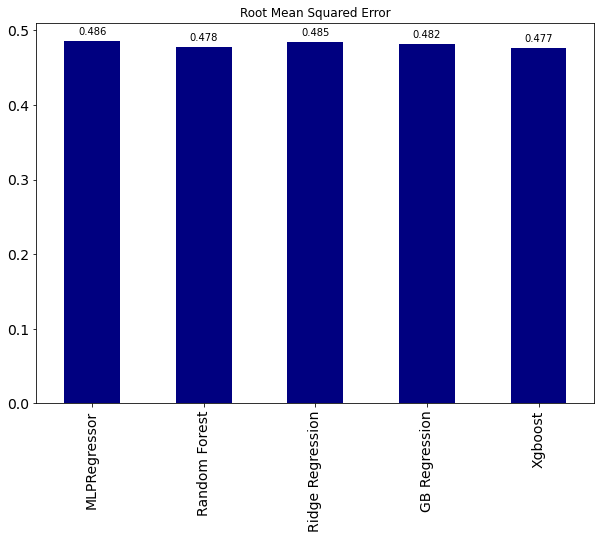

In [ ]:
#Bar plot
bar = df_metrics.plot(kind='bar', color = 'navy', title = "Root Mean Squared Error", fontsize=14, figsize=(10,7))
for p in bar.patches:
    bar.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
bar.get_legend().remove()

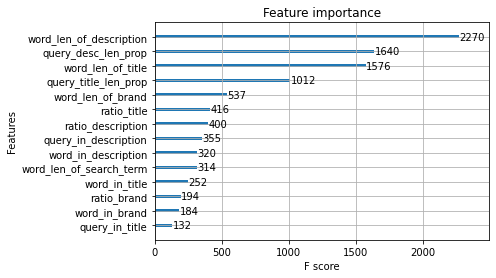

In [ ]:
plot_importance(xgb);